# CNN + GlobalAvgPool
Run this model on all lncRNA cell lines using some theshold. This notebook tests ZERO.

* zero
* RCI threshold set by GMM(2).
* Antilog threshold set by GMM(2).

Show pretty pictures.

10-fold cross-validation.

Compute the sample standard deviation.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-06 19:08:38.297799
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=10      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'
CACHING = False   # have not worked out how to cache multiple cell lines

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1,7]   # use these though they are clearly different

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-06 19:09:11.823810
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        
    def set_sequences(self, allids, allseq):
        # It is critical to keep IDs and sequences in same order!
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order!
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def get_X_y(self, gene_index):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
                next_index += 1
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def rcis_to_labels(self, array_of_rci, rci_threshold):
        IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
        return np.array(list(map(IS_CYTO, array_of_rci)))
    
    def choose_rci_threshold(self, rci_values):
        discrim = 0
        if RCI_THRESHOLD_MECHANISM == 'RCI_GMM':
            gmm2 = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=10) # best of 10
            gmm2.fit(rci_values)
            # Optimal discriminator = weighted average of means of the 2 gaussians
            discrim = gmm2.weights_[0]*gmm2.means_[0]+gmm2.weights_[1]*gmm2.means_[1]
            print('Model params (mean %.2f, wgt %.2f) (mean %.2f, wgt %.2f)' %
                (gmm2.means_[0], gmm2.weights_[0], gmm2.means_[1], gmm2.weights_[1]))
        return discrim
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_train = self.get_X_y(train_index)
            train_based_rci_threshold = self.choose_rci_threshold(y_train)
            y_train = self.rcis_to_labels(y_train,train_based_rci_threshold)
            X_valid,y_valid = self.get_X_y(valid_index)
            y_valid = self.rcis_to_labels(y_valid,train_based_rci_threshold) # yes, train_based
            print('RCI threshold derived from training set:',train_based_rci_threshold)

            #print('Training example')
            #print(X_train[0])
            #print("BUILD MODEL")
            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            
                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-06 19:09:14.997717
Start cell Line 0 A549
Number of RCI values loaded 1447
Num RCI: 1447
Load sequence...
Cross validation...
2023-02-06 19:09:30.640892
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:09:32.866123
PREDICT
2023-02-06 19:09:48.496680


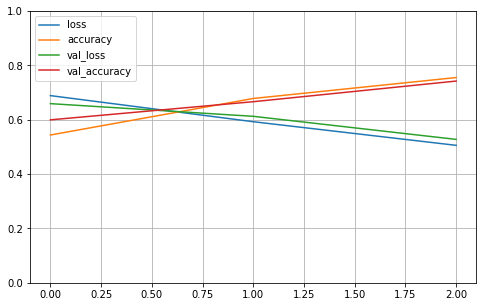

Train set ones/size 4062 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 434 / 869
Range of scores: 0.0057112286 to 0.9874161
Score threshold 0.5
Prediction set ones/size 424 / 869


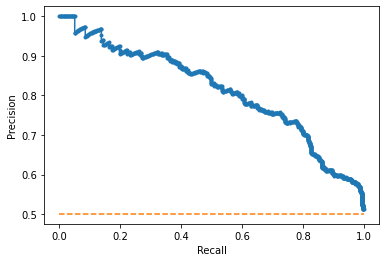

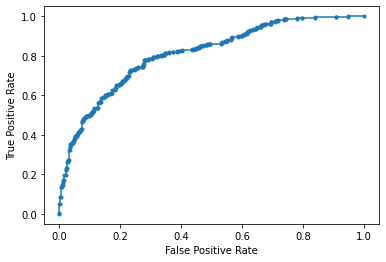

Accuracy: 74.22% Precision: 74.76% Recall: 73.04%
F1: 73.89% AUPRC: 81.31% AUROC: 81.07%
2023-02-06 19:09:49.272216
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:09:54.447890
PREDICT
2023-02-06 19:10:02.679868


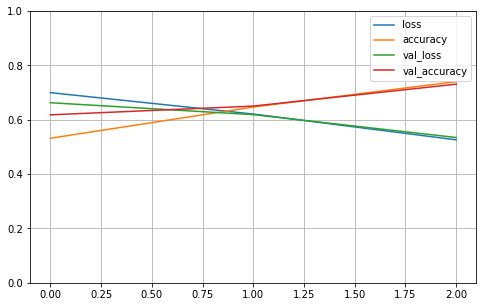

Train set ones/size 4017 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 479 / 869
Range of scores: 0.0062374184 to 0.9800137
Score threshold 0.5
Prediction set ones/size 407 / 869


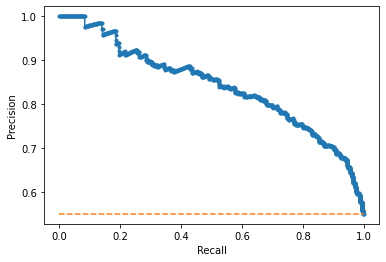

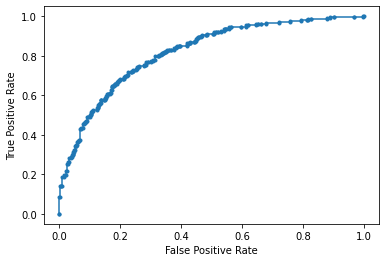

Accuracy: 73.07% Precision: 80.10% Recall: 68.06%
F1: 73.59% AUPRC: 84.29% AUROC: 81.89%
2023-02-06 19:10:03.343793
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:10:08.436596
PREDICT
2023-02-06 19:10:16.949836


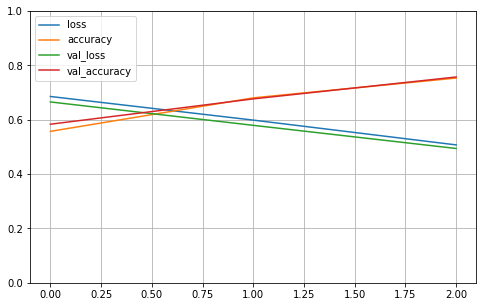

Train set ones/size 4043 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 453 / 869
Range of scores: 0.01188544 to 0.98361266
Score threshold 0.5
Prediction set ones/size 448 / 869


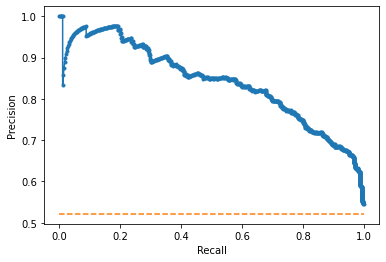

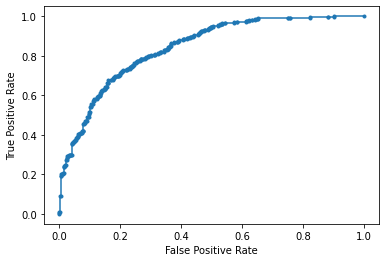

Accuracy: 75.72% Precision: 77.01% Recall: 76.16%
F1: 76.58% AUPRC: 84.13% AUROC: 84.17%
2023-02-06 19:10:17.799099
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:10:22.256769
PREDICT
2023-02-06 19:10:30.594808


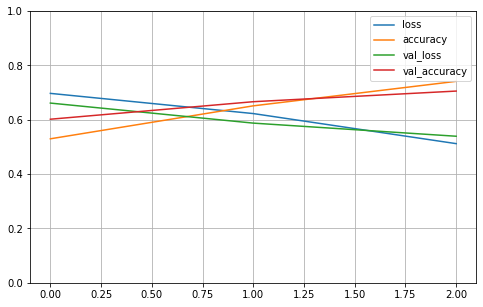

Train set ones/size 4070 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 426 / 869
Range of scores: 0.0099615045 to 0.9918074
Score threshold 0.5
Prediction set ones/size 500 / 869


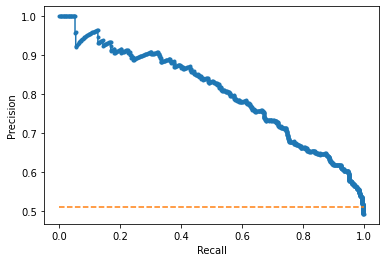

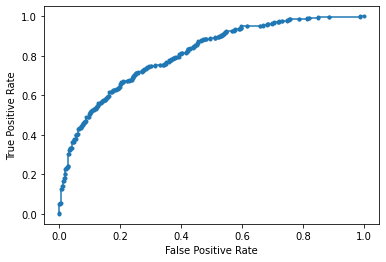

Accuracy: 70.54% Precision: 67.00% Recall: 78.64%
F1: 72.35% AUPRC: 80.39% AUROC: 80.92%
2023-02-06 19:10:31.514005
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:10:35.627308
PREDICT
2023-02-06 19:10:44.041844


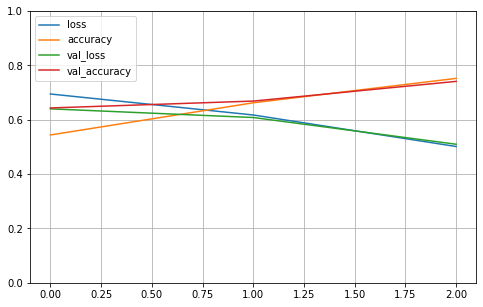

Train set ones/size 4033 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 463 / 869
Range of scores: 0.0047555156 to 0.98945487
Score threshold 0.5
Prediction set ones/size 470 / 869


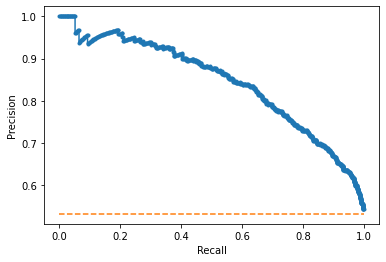

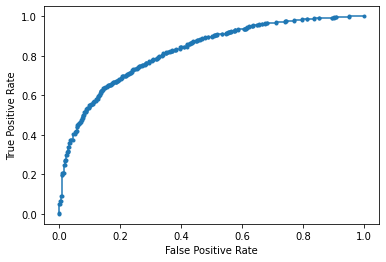

Accuracy: 74.11% Precision: 75.32% Recall: 76.46%
F1: 75.88% AUPRC: 84.53% AUROC: 82.58%
2023-02-06 19:10:45.295472
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:10:49.983887
PREDICT
2023-02-06 19:11:01.257254


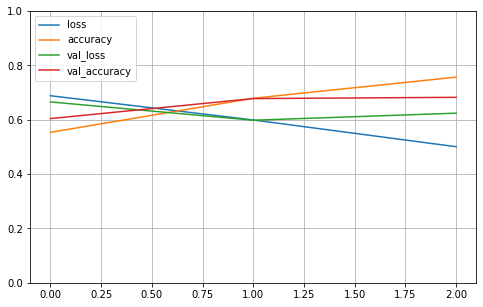

Train set ones/size 4060 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 436 / 869
Range of scores: 0.017061055 to 0.9975079
Score threshold 0.5
Prediction set ones/size 598 / 869


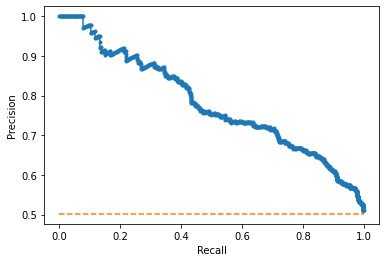

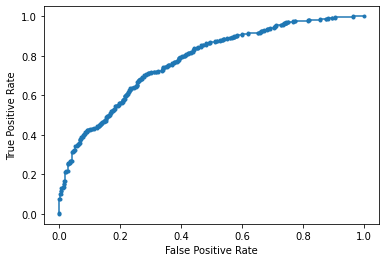

Accuracy: 68.24% Precision: 63.38% Recall: 86.93%
F1: 73.31% AUPRC: 78.12% AUROC: 77.64%
2023-02-06 19:11:01.955023
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:11:05.551760
PREDICT
2023-02-06 19:11:16.850211


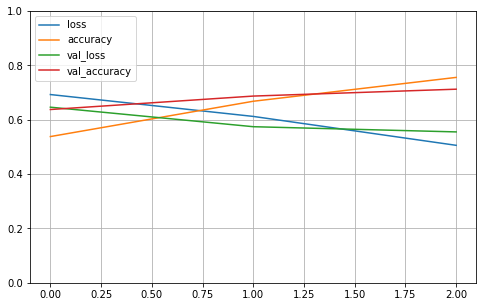

Train set ones/size 4034 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 462 / 869
Range of scores: 0.0068254154 to 0.98696005
Score threshold 0.5
Prediction set ones/size 452 / 869


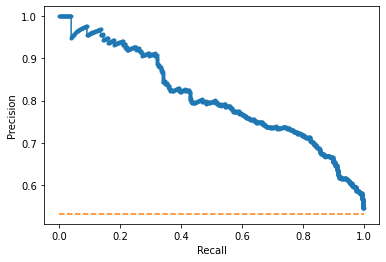

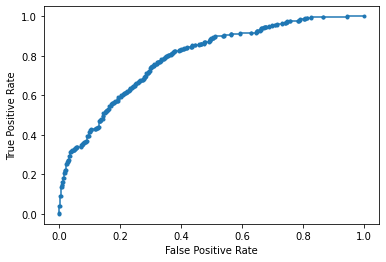

Accuracy: 71.23% Precision: 73.45% Recall: 71.86%
F1: 72.65% AUPRC: 80.73% AUROC: 78.99%
2023-02-06 19:11:17.537722
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:11:21.192469
PREDICT
2023-02-06 19:11:32.466354


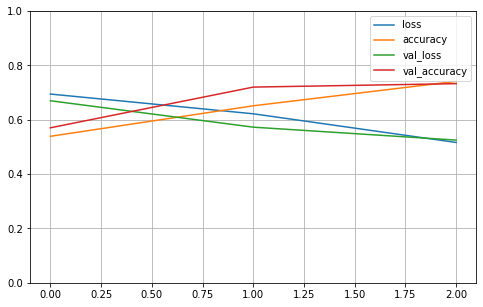

Train set ones/size 4053 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 443 / 868
Range of scores: 0.01328811 to 0.99357504
Score threshold 0.5
Prediction set ones/size 473 / 868


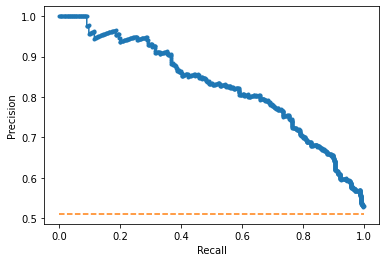

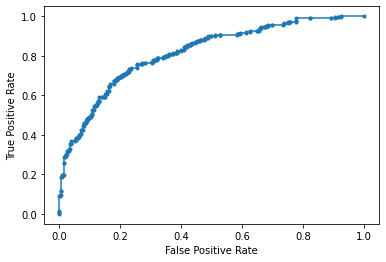

Accuracy: 73.27% Precision: 72.30% Recall: 77.20%
F1: 74.67% AUPRC: 82.78% AUROC: 81.62%
2023-02-06 19:11:33.150371
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:11:36.761290
PREDICT
2023-02-06 19:11:45.778066


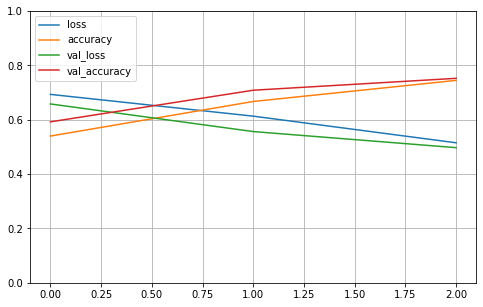

Train set ones/size 4042 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 454 / 868
Range of scores: 0.002719428 to 0.9936294
Score threshold 0.5
Prediction set ones/size 479 / 868


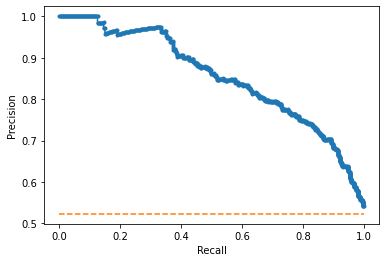

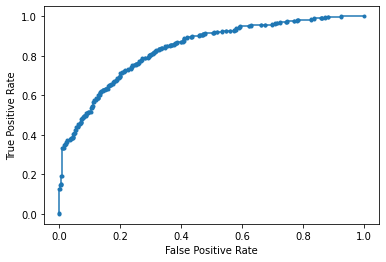

Accuracy: 75.23% Precision: 74.95% Recall: 79.07%
F1: 76.96% AUPRC: 85.49% AUROC: 83.68%
2023-02-06 19:11:46.450085
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:11:50.038368
PREDICT
2023-02-06 19:12:01.602047


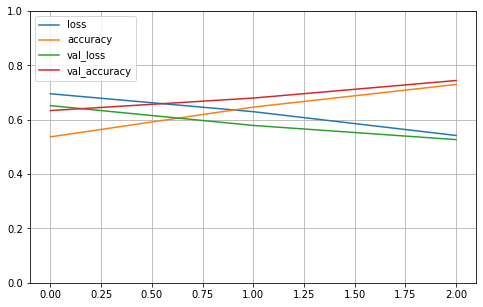

Train set ones/size 4050 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 446 / 868
Range of scores: 0.017299496 to 0.981413
Score threshold 0.5
Prediction set ones/size 388 / 868


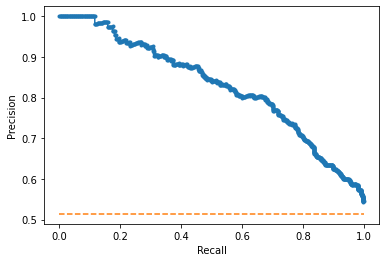

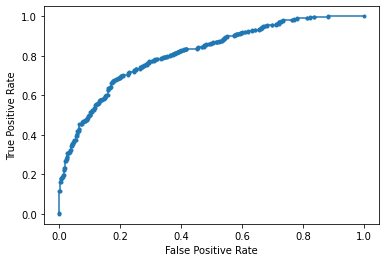

Accuracy: 74.42% Precision: 78.87% Recall: 68.61%
F1: 73.38% AUPRC: 82.95% AUROC: 81.33%
2023-02-06 19:12:02.279436

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.01% +/- 2.33
 precision mean 73.71% +/- 5.14
 recall mean 75.60% +/- 5.57
 F1 mean 74.33% +/- 1.63
 AUPRC mean 82.47% +/- 2.29
 AUROC mean 81.39% +/- 1.97
Finished cell Line 0 A549

2023-02-06 19:12:03.660618
Start cell Line 1 H1.hESC
Number of RCI values loaded 3327
Num RCI: 3327
Load sequence...
Cross validation...
2023-02-06 19:12:30.396886
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:12:36.333821
PREDICT
2023-02-06 19:12:51.948712


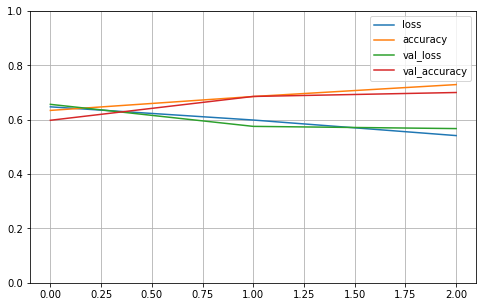

Train set ones/size 5595 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 607 / 1654
Range of scores: 0.018148653 to 0.99045676
Score threshold 0.5
Prediction set ones/size 777 / 1654


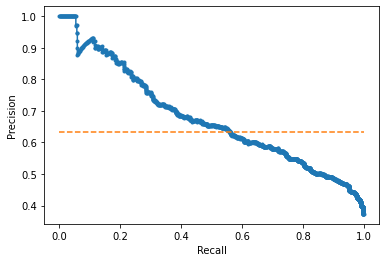

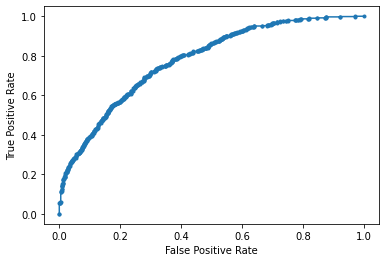

Accuracy: 70.01% Precision: 57.14% Recall: 73.15%
F1: 64.16% AUPRC: 67.81% AUROC: 77.89%
2023-02-06 19:12:52.869648
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:12:58.837963
PREDICT
2023-02-06 19:13:15.203262


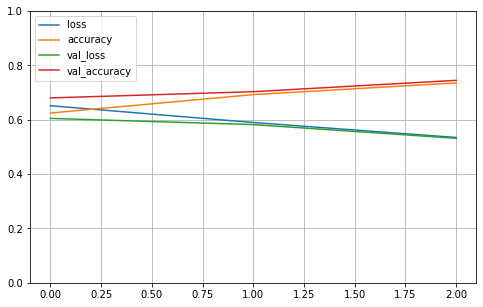

Train set ones/size 5613 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 589 / 1654
Range of scores: 0.0041063493 to 0.95942885
Score threshold 0.5
Prediction set ones/size 321 / 1654


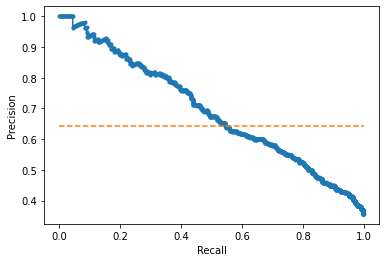

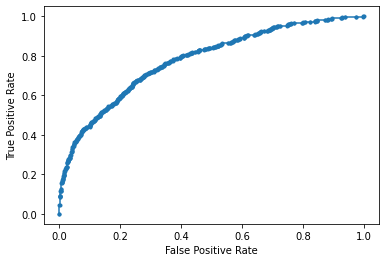

Accuracy: 74.49% Precision: 76.01% Recall: 41.43%
F1: 53.63% AUPRC: 69.38% AUROC: 77.92%
2023-02-06 19:13:16.127173
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:13:21.938278
PREDICT
2023-02-06 19:13:37.819620


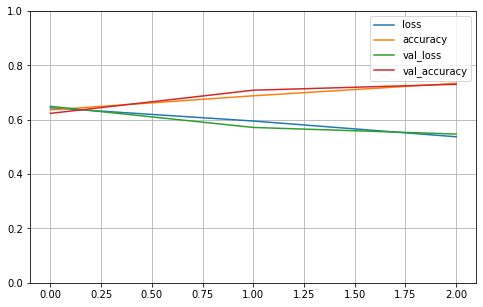

Train set ones/size 5568 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 634 / 1654
Range of scores: 0.0029534341 to 0.98878956
Score threshold 0.5
Prediction set ones/size 526 / 1654


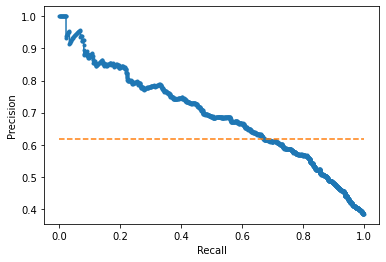

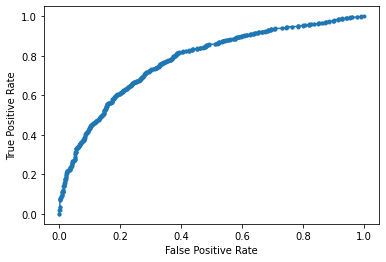

Accuracy: 73.04% Precision: 67.87% Recall: 56.31%
F1: 61.55% AUPRC: 69.37% AUROC: 77.73%
2023-02-06 19:13:38.787106
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:13:45.172142
PREDICT
2023-02-06 19:14:01.028541


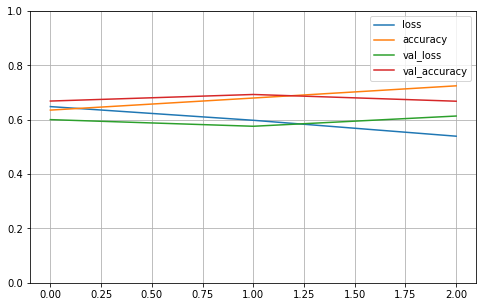

Train set ones/size 5583 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 619 / 1654
Range of scores: 0.024268797 to 0.99596834
Score threshold 0.5
Prediction set ones/size 988 / 1654


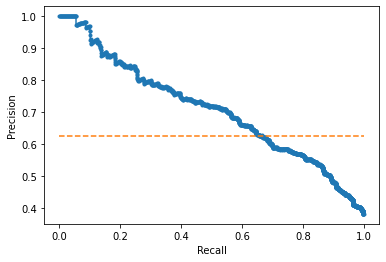

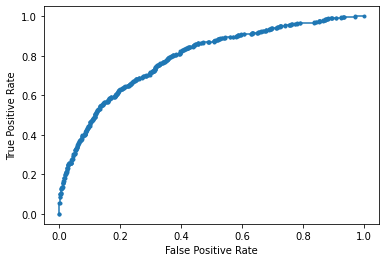

Accuracy: 66.81% Precision: 53.54% Recall: 85.46%
F1: 65.84% AUPRC: 70.81% AUROC: 78.92%
2023-02-06 19:14:01.939068
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:14:09.239062
PREDICT
2023-02-06 19:14:31.218315


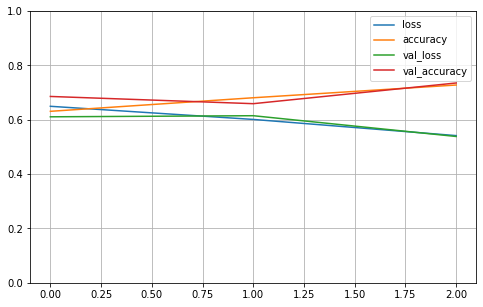

Train set ones/size 5540 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 662 / 1654
Range of scores: 0.010228134 to 0.98989314
Score threshold 0.5
Prediction set ones/size 590 / 1654


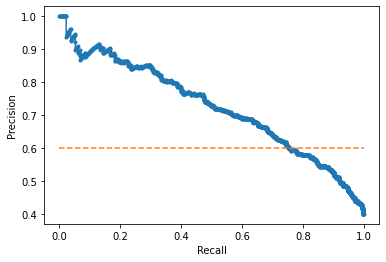

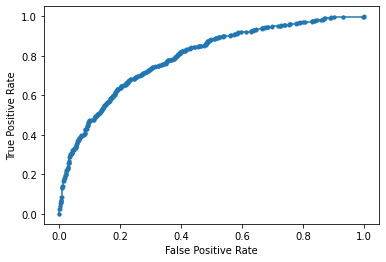

Accuracy: 73.52% Precision: 68.98% Recall: 61.48%
F1: 65.02% AUPRC: 72.54% AUROC: 79.32%
2023-02-06 19:14:32.176840
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:14:38.498647
PREDICT
2023-02-06 19:14:54.355360


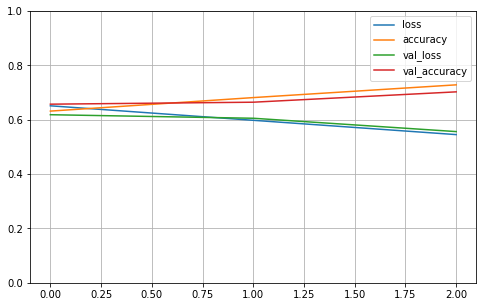

Train set ones/size 5560 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 642 / 1654
Range of scores: 0.026708942 to 0.955386
Score threshold 0.5
Prediction set ones/size 518 / 1654


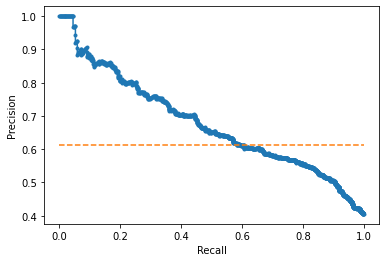

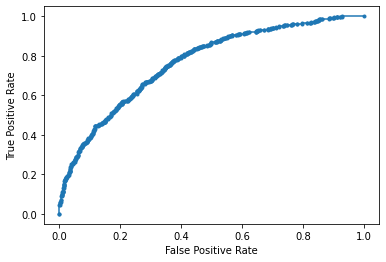

Accuracy: 70.25% Precision: 64.48% Recall: 52.02%
F1: 57.59% AUPRC: 67.87% AUROC: 76.61%
2023-02-06 19:14:55.192110
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:15:02.514005
PREDICT
2023-02-06 19:15:18.508093


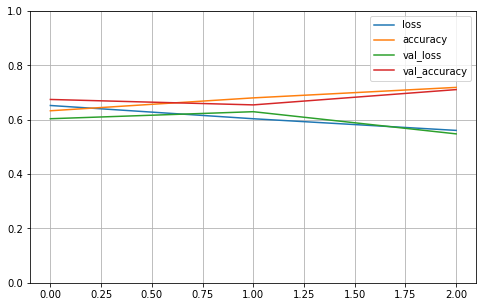

Train set ones/size 5587 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 615 / 1653
Range of scores: 0.009155751 to 0.98244035
Score threshold 0.5
Prediction set ones/size 331 / 1653


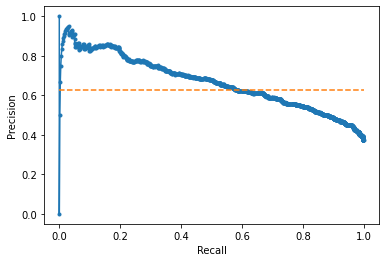

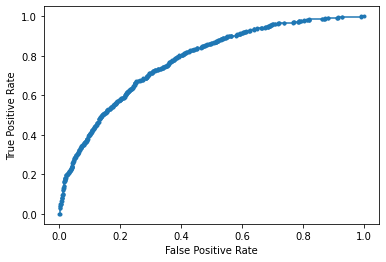

Accuracy: 71.08% Precision: 70.69% Recall: 38.05%
F1: 49.47% AUPRC: 66.78% AUROC: 77.79%
2023-02-06 19:15:19.427121
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:15:25.228107
PREDICT
2023-02-06 19:15:47.618260


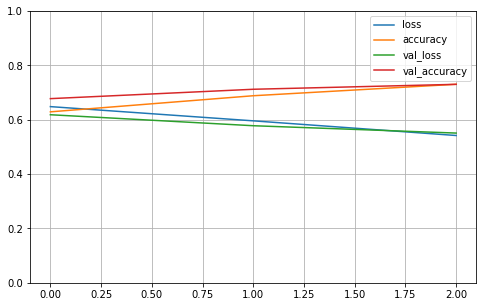

Train set ones/size 5607 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 595 / 1653
Range of scores: 0.016524898 to 0.99867934
Score threshold 0.5
Prediction set ones/size 669 / 1653


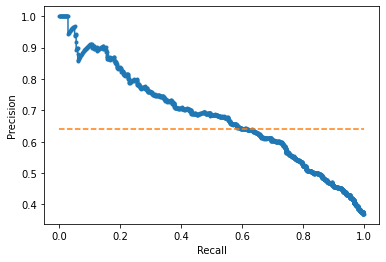

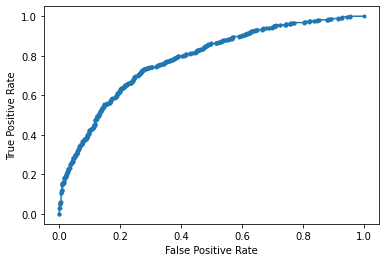

Accuracy: 73.02% Precision: 61.14% Recall: 68.74%
F1: 64.72% AUPRC: 68.17% AUROC: 78.40%
2023-02-06 19:15:48.536426
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:15:55.898975
PREDICT
2023-02-06 19:16:11.898273


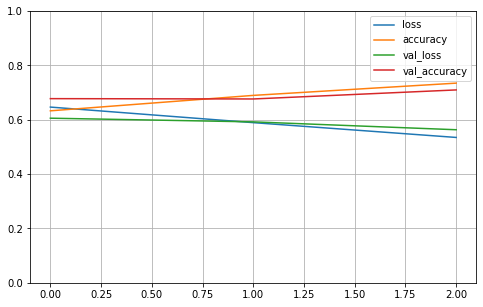

Train set ones/size 5598 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 604 / 1653
Range of scores: 0.014906909 to 0.9933528
Score threshold 0.5
Prediction set ones/size 654 / 1653


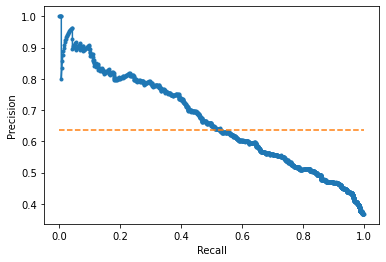

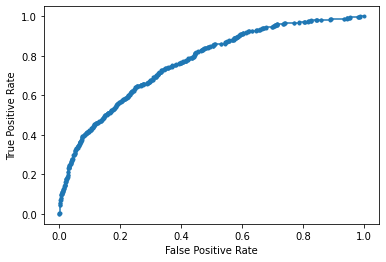

Accuracy: 70.96% Precision: 59.48% Recall: 64.40%
F1: 61.84% AUPRC: 66.56% AUROC: 76.80%
2023-02-06 19:16:12.711511
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:16:18.456000
PREDICT
2023-02-06 19:16:40.828317


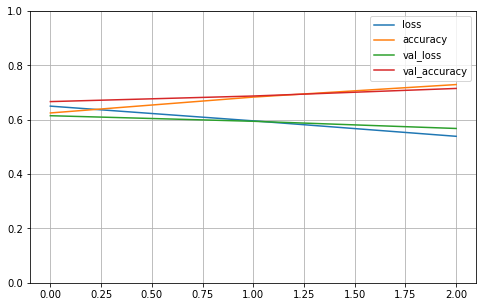

Train set ones/size 5567 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 635 / 1653
Range of scores: 0.005605314 to 0.9661152
Score threshold 0.5
Prediction set ones/size 374 / 1653


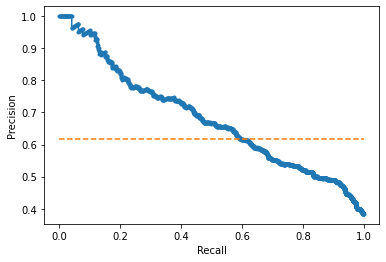

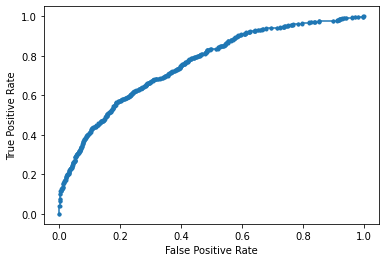

Accuracy: 71.51% Precision: 71.93% Recall: 42.36%
F1: 53.32% AUPRC: 68.01% AUROC: 75.84%
2023-02-06 19:16:41.745262

Completed cross validation 10 folds 3 epochs
 accuracy mean 71.47% +/- 2.21
 precision mean 65.13% +/- 7.18
 recall mean 58.34% +/- 15.30
 F1 mean 59.71% +/- 5.83
 AUPRC mean 68.73% +/- 1.84
 AUROC mean 77.72% +/- 1.06
Finished cell Line 1 H1.hESC

2023-02-06 19:16:43.311301
Start cell Line 2 HeLa.S3
Number of RCI values loaded 919
Num RCI: 919
Load sequence...
Cross validation...
2023-02-06 19:16:53.238315
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:16:54.917769
PREDICT
2023-02-06 19:17:05.925360


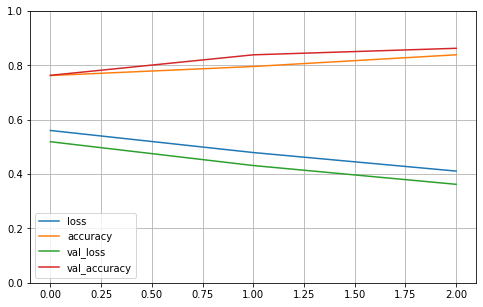

Train set ones/size 1208 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 138 / 583
Range of scores: 0.0037757186 to 0.9619501
Score threshold 0.5
Prediction set ones/size 68 / 583


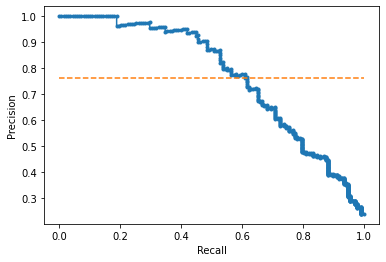

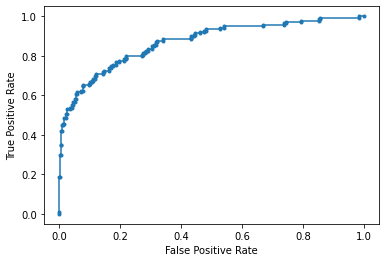

Accuracy: 86.28% Precision: 92.65% Recall: 45.65%
F1: 61.17% AUPRC: 76.92% AUROC: 87.01%
2023-02-06 19:17:06.549009
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:17:09.355128
PREDICT
2023-02-06 19:17:15.558069


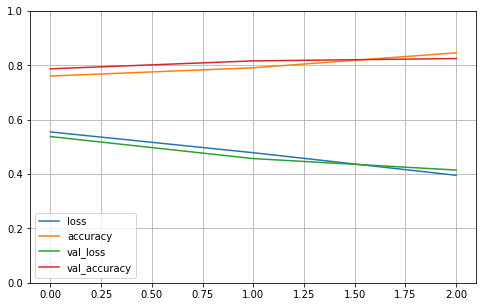

Train set ones/size 1215 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 131 / 583
Range of scores: 0.0021890763 to 0.98403025
Score threshold 0.5
Prediction set ones/size 55 / 583


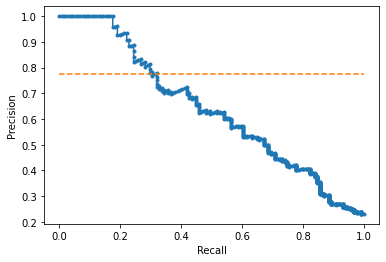

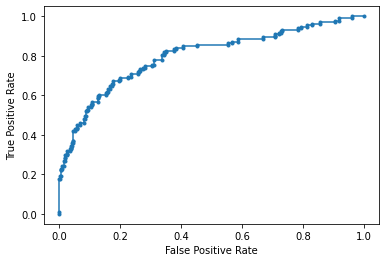

Accuracy: 82.50% Precision: 76.36% Recall: 32.06%
F1: 45.16% AUPRC: 63.81% AUROC: 80.00%
2023-02-06 19:17:16.232626
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:17:19.062796
PREDICT
2023-02-06 19:17:24.883028


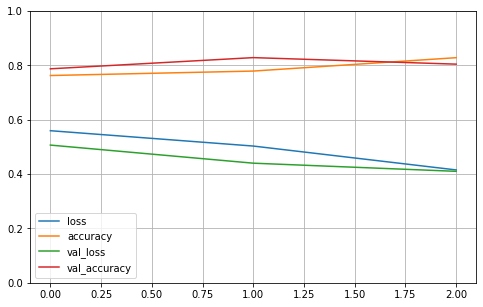

Train set ones/size 1222 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 124 / 583
Range of scores: 0.00066304015 to 0.87306803
Score threshold 0.5
Prediction set ones/size 14 / 583


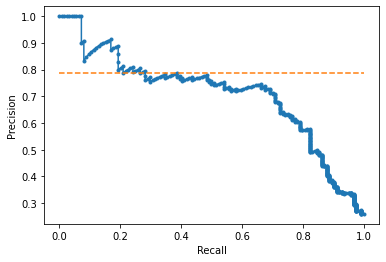

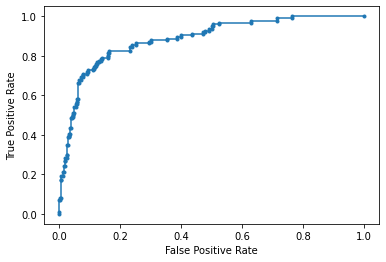

Accuracy: 80.45% Precision: 85.71% Recall: 9.68%
F1: 17.39% AUPRC: 70.81% AUROC: 88.59%
2023-02-06 19:17:25.574794
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:17:29.105430
PREDICT
2023-02-06 19:17:40.087154


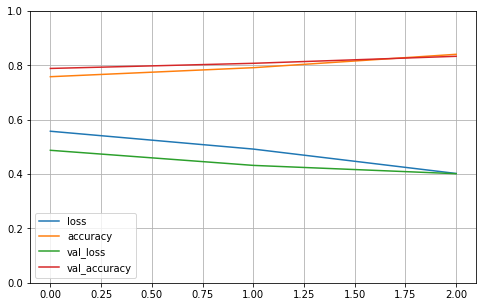

Train set ones/size 1223 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 123 / 582
Range of scores: 0.0060689477 to 0.99536264
Score threshold 0.5
Prediction set ones/size 124 / 582


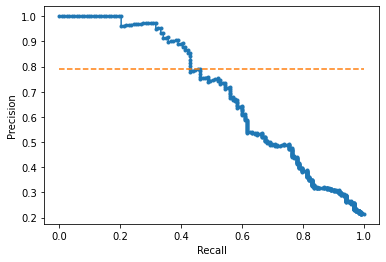

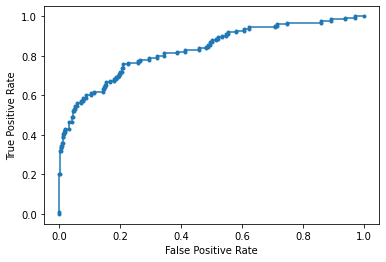

Accuracy: 83.33% Precision: 60.48% Recall: 60.98%
F1: 60.73% AUPRC: 69.98% AUROC: 83.20%
2023-02-06 19:17:40.902834
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:17:43.704991
PREDICT
2023-02-06 19:17:49.591091


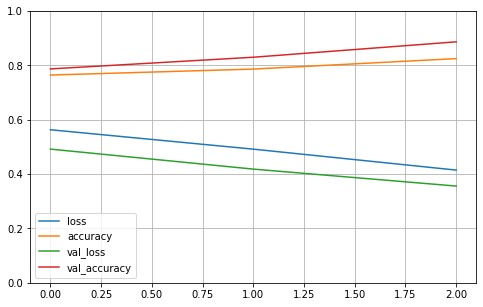

Train set ones/size 1222 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 124 / 582
Range of scores: 0.0030928703 to 0.9746142
Score threshold 0.5
Prediction set ones/size 92 / 582


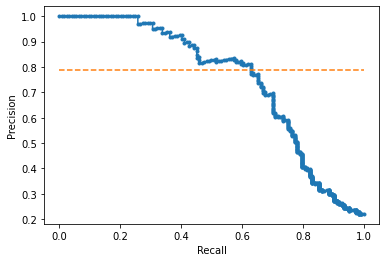

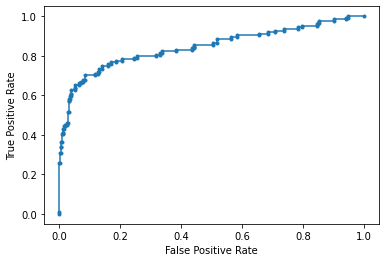

Accuracy: 88.66% Precision: 81.52% Recall: 60.48%
F1: 69.44% AUPRC: 75.07% AUROC: 84.59%
2023-02-06 19:17:50.274492
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:17:53.945642
PREDICT
2023-02-06 19:18:04.940154


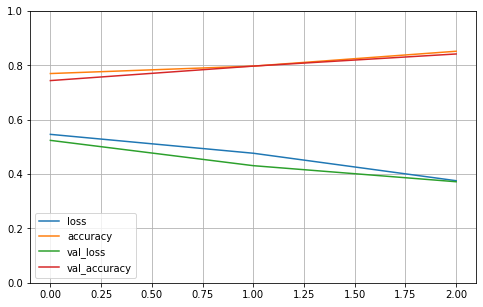

Train set ones/size 1197 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 149 / 582
Range of scores: 0.0010056808 to 0.9735064
Score threshold 0.5
Prediction set ones/size 65 / 582


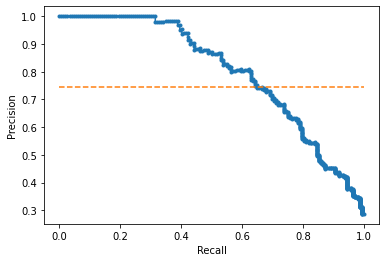

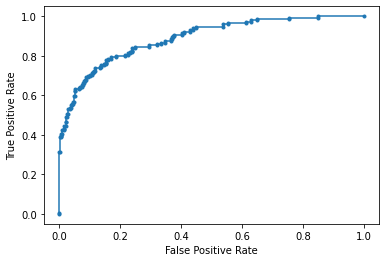

Accuracy: 84.19% Precision: 93.85% Recall: 40.94%
F1: 57.01% AUPRC: 80.11% AUROC: 88.95%
2023-02-06 19:18:05.832321
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:18:08.741855
PREDICT
2023-02-06 19:18:14.676262


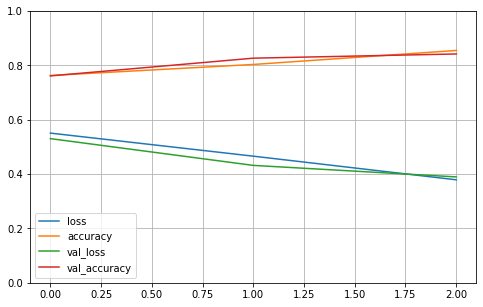

Train set ones/size 1207 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 139 / 582
Range of scores: 0.0006344809 to 0.9653449
Score threshold 0.5
Prediction set ones/size 65 / 582


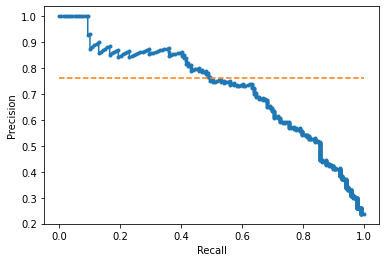

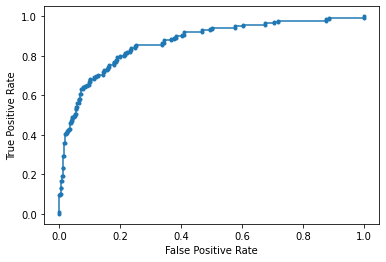

Accuracy: 84.19% Precision: 86.15% Recall: 40.29%
F1: 54.90% AUPRC: 72.37% AUROC: 86.97%
2023-02-06 19:18:15.358434
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:18:19.345902
PREDICT
2023-02-06 19:18:25.290382


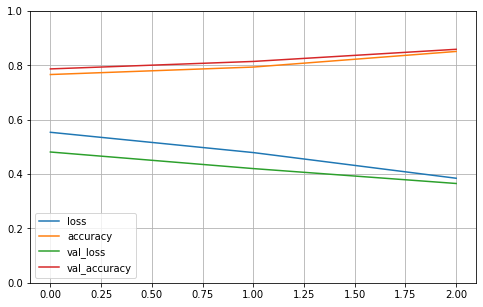

Train set ones/size 1222 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 124 / 582
Range of scores: 0.00024918903 to 0.95405805
Score threshold 0.5
Prediction set ones/size 54 / 582


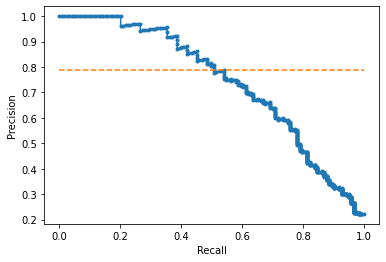

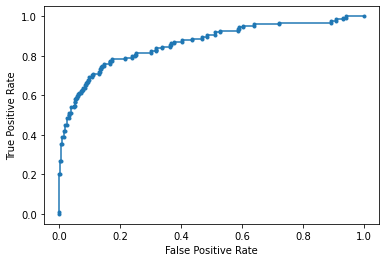

Accuracy: 85.91% Precision: 88.89% Recall: 38.71%
F1: 53.93% AUPRC: 74.22% AUROC: 86.30%
2023-02-06 19:18:25.967466
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:18:28.757208
PREDICT
2023-02-06 19:18:35.249205


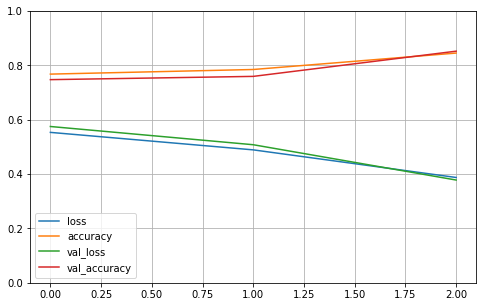

Train set ones/size 1199 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 147 / 582
Range of scores: 0.003210097 to 0.98116726
Score threshold 0.5
Prediction set ones/size 125 / 582


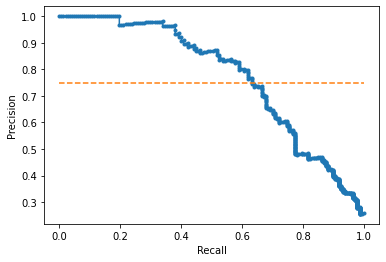

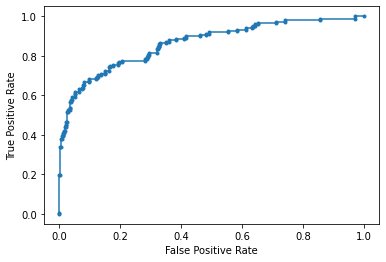

Accuracy: 85.22% Precision: 74.40% Recall: 63.27%
F1: 68.38% AUPRC: 77.41% AUROC: 86.40%
2023-02-06 19:18:35.917980
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:18:38.767746
PREDICT
2023-02-06 19:18:44.911847


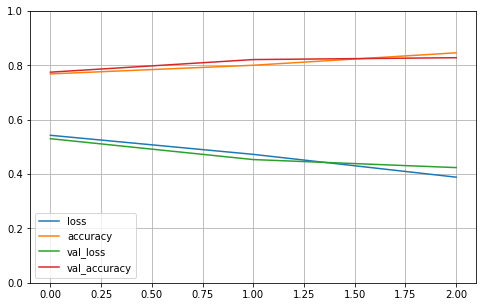

Train set ones/size 1199 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 147 / 582
Range of scores: 0.002759682 to 0.9573629
Score threshold 0.5
Prediction set ones/size 59 / 582


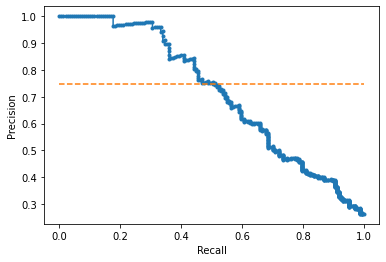

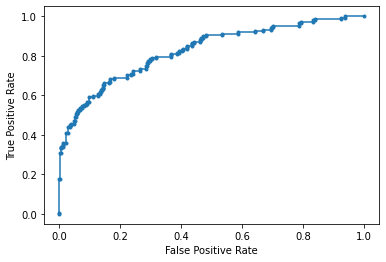

Accuracy: 82.82% Precision: 89.83% Recall: 36.05%
F1: 51.46% AUPRC: 71.36% AUROC: 82.63%
2023-02-06 19:18:45.836558

Completed cross validation 10 folds 3 epochs
 accuracy mean 84.36% +/- 2.30
 precision mean 82.98% +/- 10.20
 recall mean 42.81% +/- 16.17
 F1 mean 53.96% +/- 14.82
 AUPRC mean 73.21% +/- 4.62
 AUROC mean 85.47% +/- 2.83
Finished cell Line 2 HeLa.S3

2023-02-06 19:18:47.284984
Start cell Line 3 HepG2
Number of RCI values loaded 1362
Num RCI: 1362
Load sequence...
Cross validation...
2023-02-06 19:19:00.901949
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:19:03.188277
PREDICT
2023-02-06 19:19:11.733039


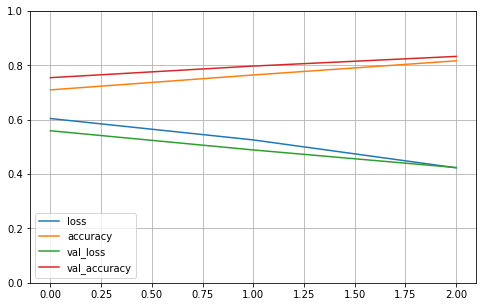

Train set ones/size 2149 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 237 / 844
Range of scores: 0.002998031 to 0.9876587
Score threshold 0.5
Prediction set ones/size 148 / 844


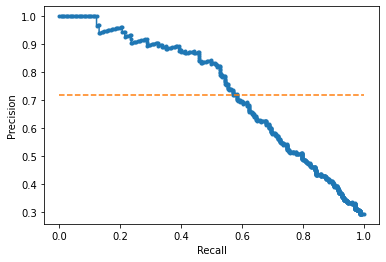

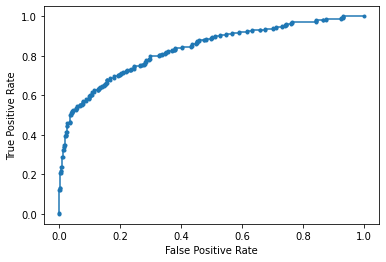

Accuracy: 83.29% Precision: 82.43% Recall: 51.48%
F1: 63.38% AUPRC: 73.58% AUROC: 83.23%
2023-02-06 19:19:12.733461
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:19:16.401388
PREDICT
2023-02-06 19:19:27.704667


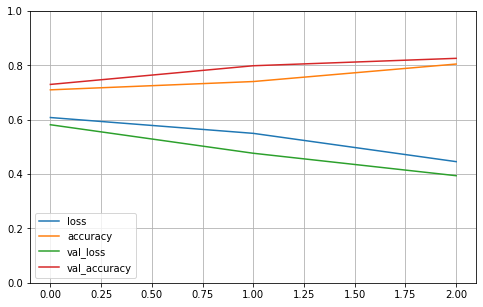

Train set ones/size 2155 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 231 / 844
Range of scores: 0.007619292 to 0.96906495
Score threshold 0.5
Prediction set ones/size 124 / 844


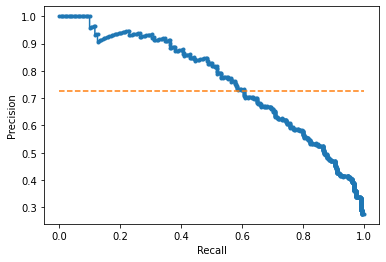

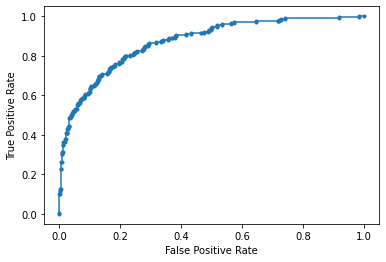

Accuracy: 82.58% Precision: 83.87% Recall: 45.02%
F1: 58.59% AUPRC: 76.00% AUROC: 87.12%
2023-02-06 19:19:28.377510
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:19:31.927011
PREDICT
2023-02-06 19:19:43.253727


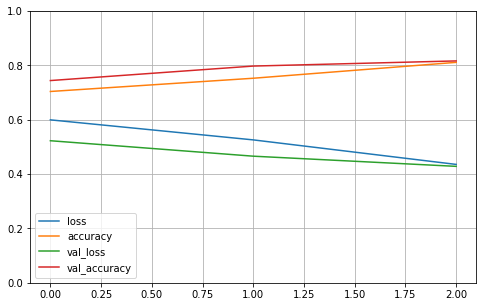

Train set ones/size 2160 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 226 / 844
Range of scores: 0.003094887 to 0.9848704
Score threshold 0.5
Prediction set ones/size 145 / 844


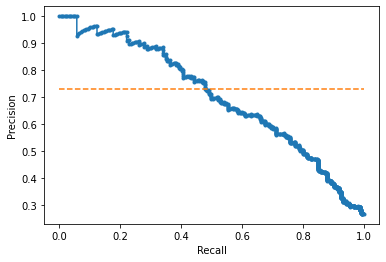

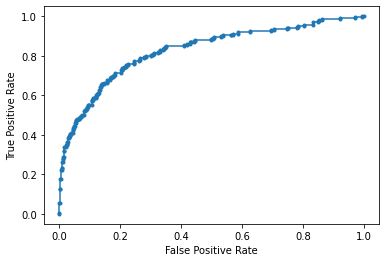

Accuracy: 81.64% Precision: 74.48% Recall: 47.79%
F1: 58.22% AUPRC: 70.40% AUROC: 82.74%
2023-02-06 19:19:43.908243
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:19:47.457070
PREDICT
2023-02-06 19:19:56.201310


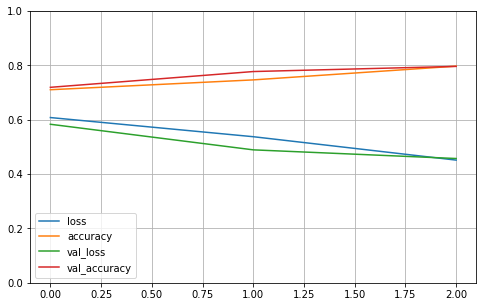

Train set ones/size 2149 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 237 / 844
Range of scores: 0.010663342 to 0.9887482
Score threshold 0.5
Prediction set ones/size 231 / 844


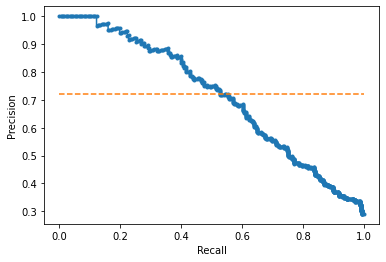

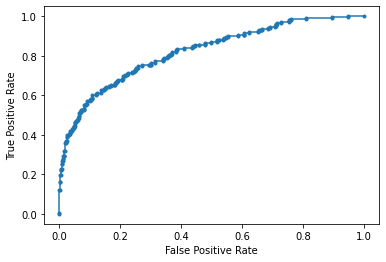

Accuracy: 79.62% Precision: 64.07% Recall: 62.45%
F1: 63.25% AUPRC: 71.32% AUROC: 82.11%
2023-02-06 19:19:56.848810
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:20:00.386960
PREDICT
2023-02-06 19:20:11.696772


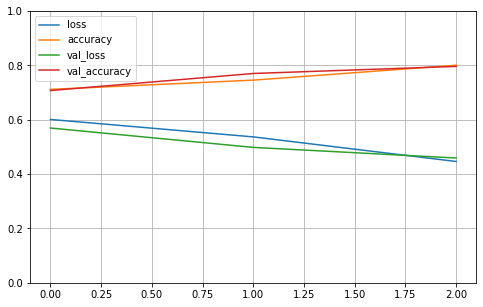

Train set ones/size 2139 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 247 / 844
Range of scores: 0.002331493 to 0.9530291
Score threshold 0.5
Prediction set ones/size 99 / 844


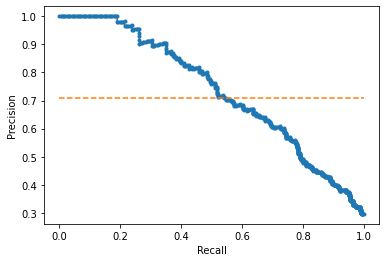

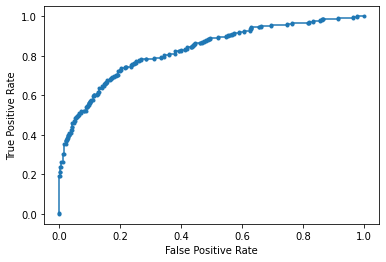

Accuracy: 79.62% Precision: 87.88% Recall: 35.22%
F1: 50.29% AUPRC: 73.60% AUROC: 82.86%
2023-02-06 19:20:12.385186
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:20:15.950988
PREDICT
2023-02-06 19:20:27.525426


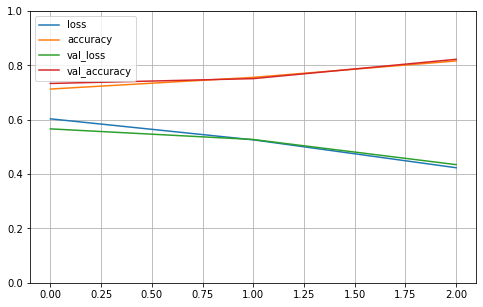

Train set ones/size 2142 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 244 / 844
Range of scores: 0.0024942541 to 0.9663738
Score threshold 0.5
Prediction set ones/size 116 / 844


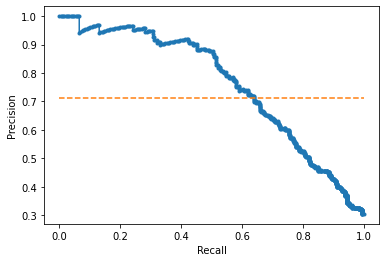

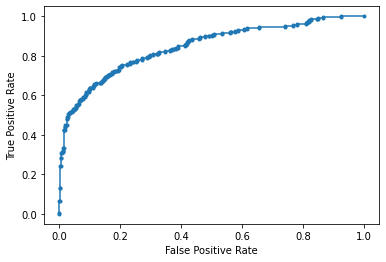

Accuracy: 82.23% Precision: 90.52% Recall: 43.03%
F1: 58.33% AUPRC: 76.09% AUROC: 84.59%
2023-02-06 19:20:28.198035
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:20:33.237481
PREDICT
2023-02-06 19:20:41.614211


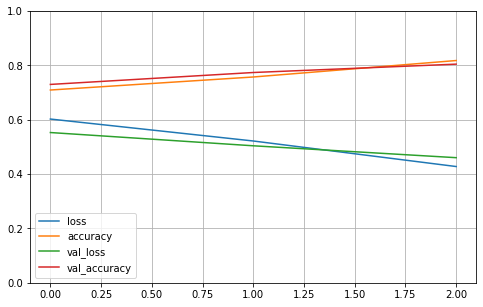

Train set ones/size 2157 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 229 / 844
Range of scores: 0.0027333652 to 0.9794901
Score threshold 0.5
Prediction set ones/size 166 / 844


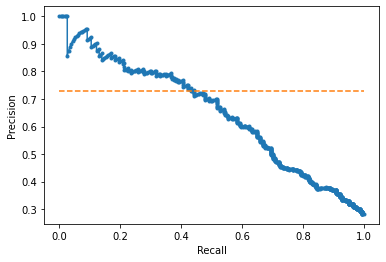

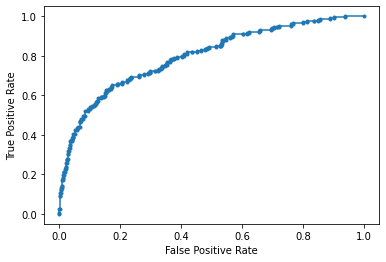

Accuracy: 80.45% Precision: 69.28% Recall: 50.22%
F1: 58.23% AUPRC: 65.01% AUROC: 79.83%
2023-02-06 19:20:42.288734
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:20:47.183674
PREDICT
2023-02-06 19:20:58.488641


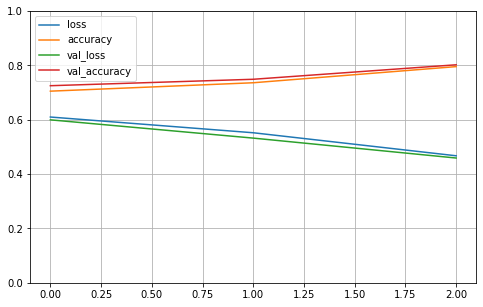

Train set ones/size 2140 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 246 / 844
Range of scores: 0.010651823 to 0.957501
Score threshold 0.5
Prediction set ones/size 123 / 844


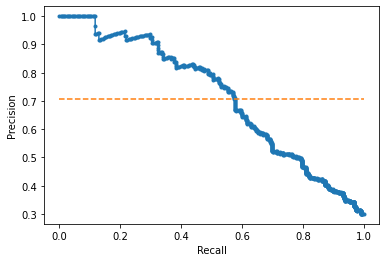

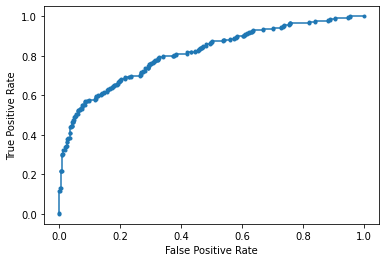

Accuracy: 80.21% Precision: 82.11% Recall: 41.06%
F1: 54.74% AUPRC: 71.62% AUROC: 81.27%
2023-02-06 19:20:59.277576
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:21:02.860060
PREDICT
2023-02-06 19:21:11.493931


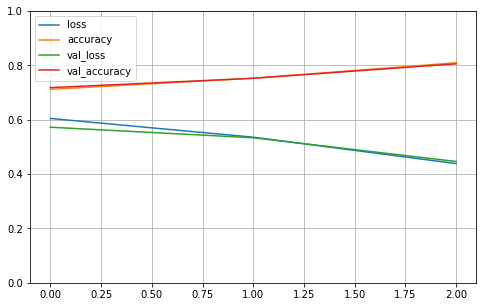

Train set ones/size 2148 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 238 / 844
Range of scores: 0.002433097 to 0.9765455
Score threshold 0.5
Prediction set ones/size 122 / 844


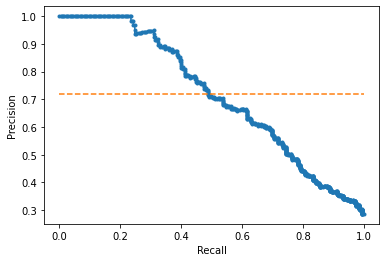

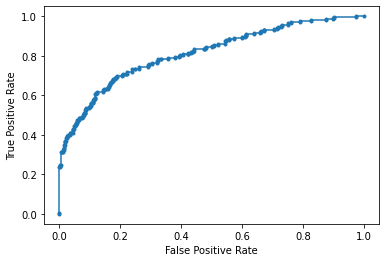

Accuracy: 80.57% Precision: 80.33% Recall: 41.18%
F1: 54.44% AUPRC: 71.71% AUROC: 81.29%
2023-02-06 19:21:12.443291
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:21:16.038895
PREDICT
2023-02-06 19:21:24.643950


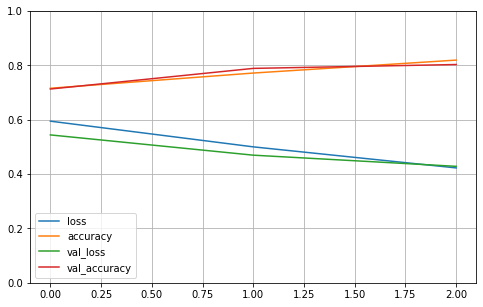

Train set ones/size 2135 / 7596
Compute valiation accuracy
Valid sizes (843, 4997) (843,)
Valid set ones/size 251 / 843
Range of scores: 0.0020390868 to 0.9887333
Score threshold 0.5
Prediction set ones/size 207 / 843


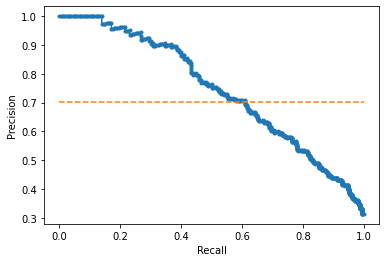

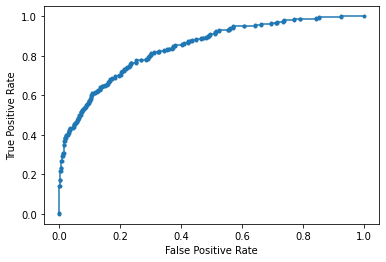

Accuracy: 80.31% Precision: 70.53% Recall: 58.17%
F1: 63.76% AUPRC: 74.50% AUROC: 84.25%
2023-02-06 19:21:25.583196

Completed cross validation 10 folds 3 epochs
 accuracy mean 81.05% +/- 1.29
 precision mean 78.55% +/- 8.60
 recall mean 47.56% +/- 8.29
 F1 mean 58.32% +/- 4.37
 AUPRC mean 72.38% +/- 3.24
 AUROC mean 82.93% +/- 2.05
Finished cell Line 3 HepG2

2023-02-06 19:21:27.105472
Start cell Line 4 HT1080
Number of RCI values loaded 936
Num RCI: 936
Load sequence...
Cross validation...
2023-02-06 19:21:37.980677
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:21:40.701988
PREDICT
2023-02-06 19:21:52.006244


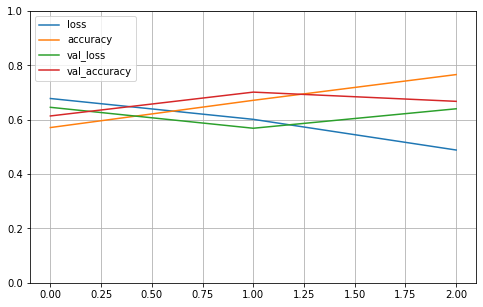

Train set ones/size 2800 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 311 / 707
Range of scores: 0.004913995 to 0.9992054
Score threshold 0.5
Prediction set ones/size 490 / 707


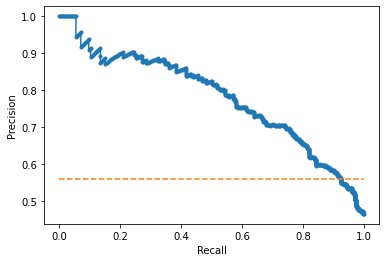

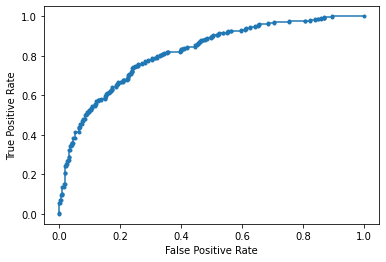

Accuracy: 66.76% Precision: 57.76% Recall: 91.00%
F1: 70.66% AUPRC: 78.10% AUROC: 81.77%
2023-02-06 19:21:52.675939
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:21:55.836671
PREDICT
2023-02-06 19:22:03.121627


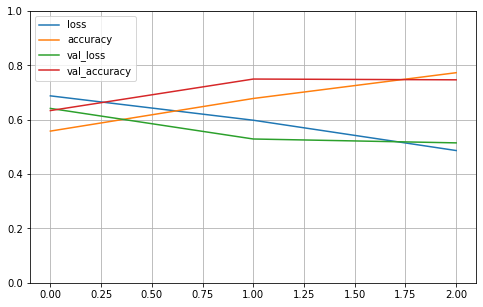

Train set ones/size 2806 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 305 / 707
Range of scores: 0.005421464 to 0.9964585
Score threshold 0.5
Prediction set ones/size 422 / 707


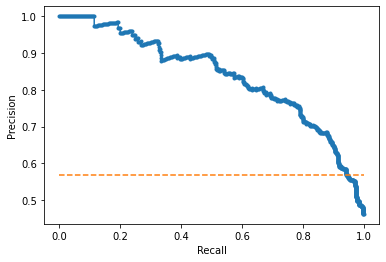

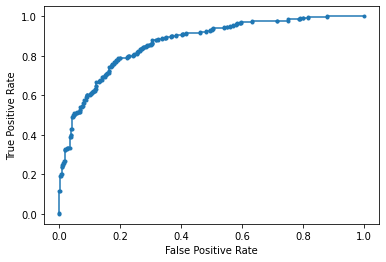

Accuracy: 74.68% Precision: 64.93% Recall: 89.84%
F1: 75.38% AUPRC: 83.77% AUROC: 86.64%
2023-02-06 19:22:04.038370
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:22:07.415971
PREDICT
2023-02-06 19:22:18.631855


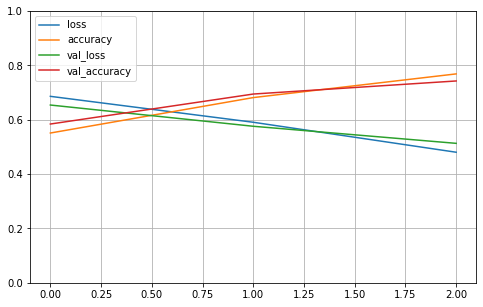

Train set ones/size 2804 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 307 / 707
Range of scores: 0.0020932306 to 0.9875115
Score threshold 0.5
Prediction set ones/size 383 / 707


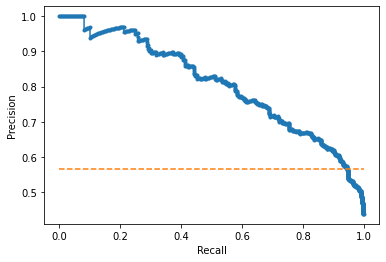

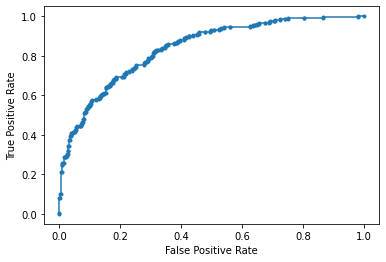

Accuracy: 74.26% Precision: 66.32% Recall: 82.74%
F1: 73.62% AUPRC: 80.74% AUROC: 83.86%
2023-02-06 19:22:19.295592
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:22:22.470877
PREDICT
2023-02-06 19:22:29.945752


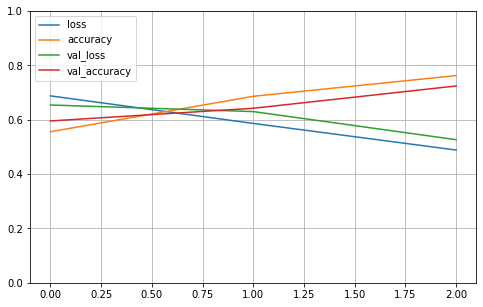

Train set ones/size 2780 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 331 / 707
Range of scores: 0.0021871305 to 0.99026346
Score threshold 0.5
Prediction set ones/size 294 / 707


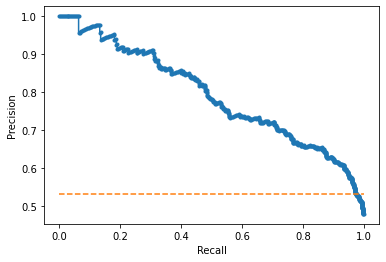

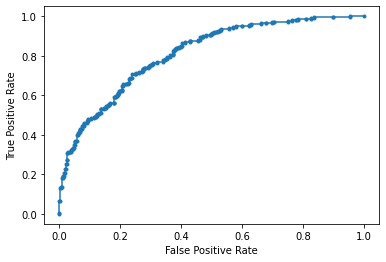

Accuracy: 72.42% Precision: 73.13% Recall: 64.95%
F1: 68.80% AUPRC: 79.27% AUROC: 81.15%
2023-02-06 19:22:30.825303
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:22:34.034495
PREDICT
2023-02-06 19:22:45.257141


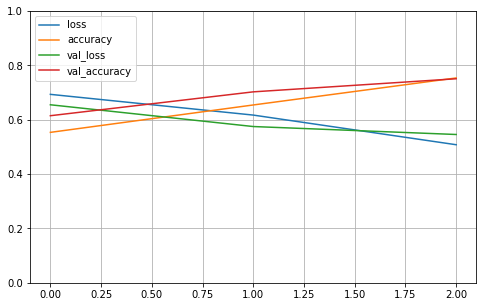

Train set ones/size 2795 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 316 / 706
Range of scores: 0.002147975 to 0.98548394
Score threshold 0.5
Prediction set ones/size 244 / 706


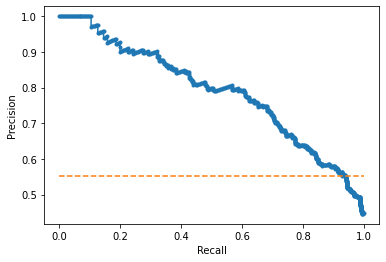

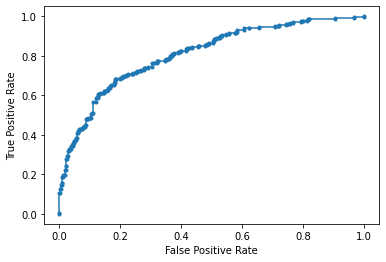

Accuracy: 75.07% Precision: 78.69% Recall: 60.76%
F1: 68.57% AUPRC: 78.90% AUROC: 80.97%
2023-02-06 19:22:45.931579
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:22:49.155116
PREDICT
2023-02-06 19:22:56.698502


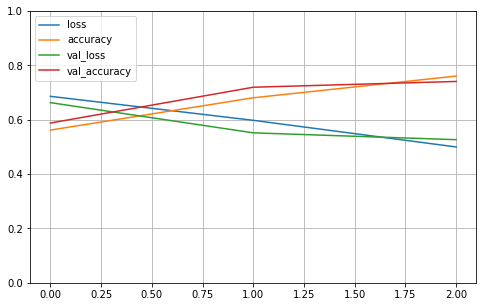

Train set ones/size 2798 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 313 / 706
Range of scores: 0.0035508166 to 0.9794232
Score threshold 0.5
Prediction set ones/size 234 / 706


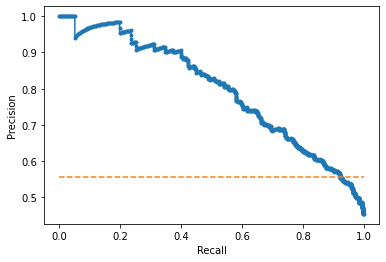

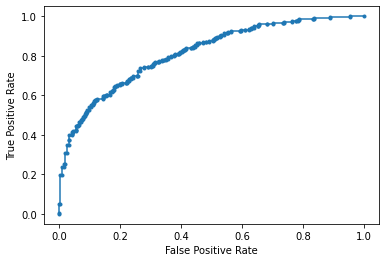

Accuracy: 74.08% Precision: 77.78% Recall: 58.15%
F1: 66.54% AUPRC: 79.75% AUROC: 81.52%
2023-02-06 19:22:57.345784
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:23:00.529299
PREDICT
2023-02-06 19:23:11.745266


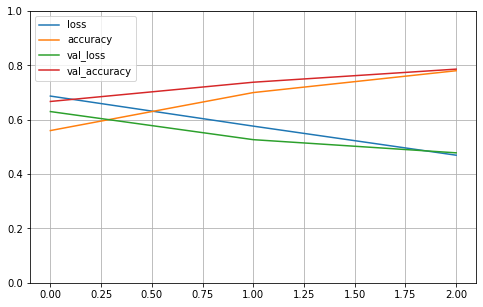

Train set ones/size 2787 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 324 / 706
Range of scores: 0.005386159 to 0.9979736
Score threshold 0.5
Prediction set ones/size 339 / 706


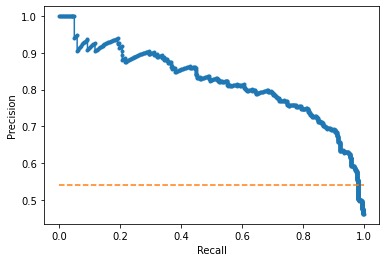

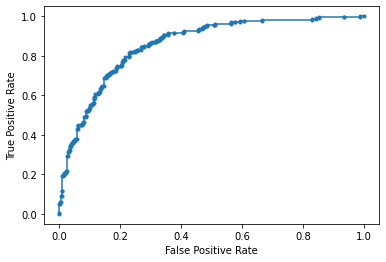

Accuracy: 78.61% Precision: 75.52% Recall: 79.01%
F1: 77.22% AUPRC: 82.04% AUROC: 85.74%
2023-02-06 19:23:12.458015
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:23:15.650711
PREDICT
2023-02-06 19:23:23.198439


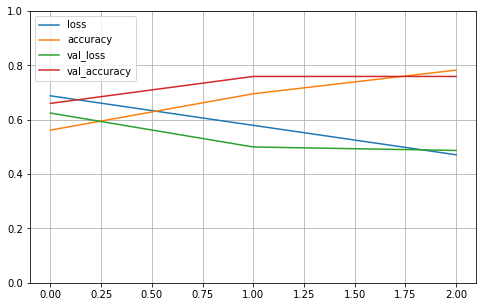

Train set ones/size 2820 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 291 / 706
Range of scores: 0.0012124181 to 0.99740666
Score threshold 0.5
Prediction set ones/size 371 / 706


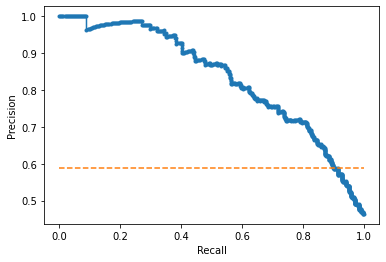

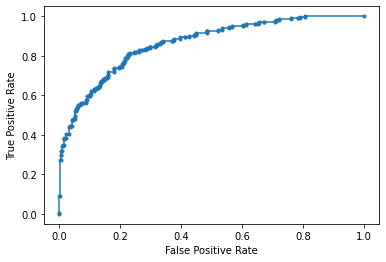

Accuracy: 75.92% Precision: 66.31% Recall: 84.54%
F1: 74.32% AUPRC: 83.42% AUROC: 86.33%
2023-02-06 19:23:23.821113
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:23:26.995029
PREDICT
2023-02-06 19:23:38.214192


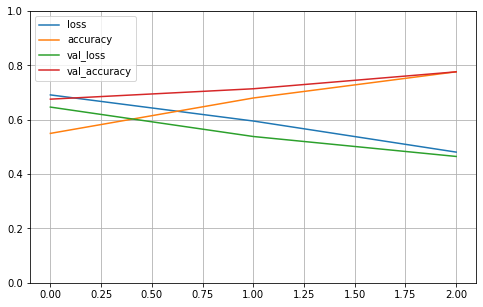

Train set ones/size 2806 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 305 / 706
Range of scores: 0.0033947034 to 0.98376024
Score threshold 0.5
Prediction set ones/size 323 / 706


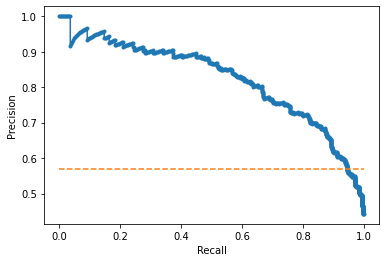

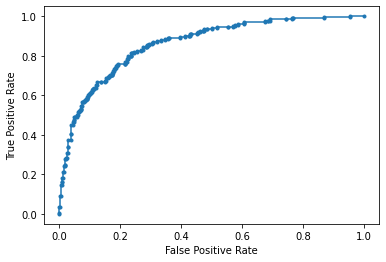

Accuracy: 77.62% Precision: 72.76% Recall: 77.05%
F1: 74.84% AUPRC: 82.31% AUROC: 86.13%
2023-02-06 19:23:38.866242
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:23:42.071914
PREDICT
2023-02-06 19:23:53.304334


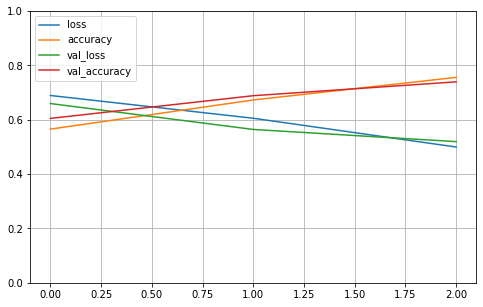

Train set ones/size 2803 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 308 / 706
Range of scores: 0.002834373 to 0.98864144
Score threshold 0.5
Prediction set ones/size 216 / 706


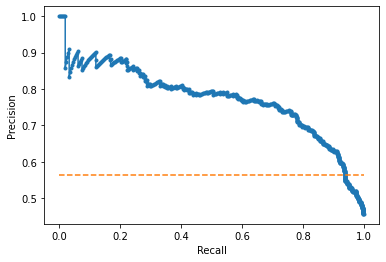

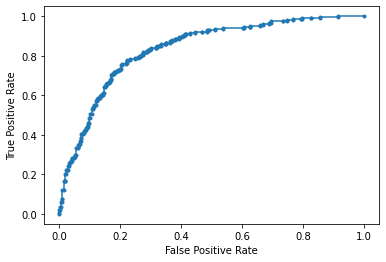

Accuracy: 73.94% Precision: 78.70% Recall: 55.19%
F1: 64.89% AUPRC: 77.31% AUROC: 83.54%
2023-02-06 19:23:53.983941

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.34% +/- 3.22
 precision mean 71.19% +/- 7.06
 recall mean 74.32% +/- 13.43
 F1 mean 71.49% +/- 4.17
 AUPRC mean 80.56% +/- 2.25
 AUROC mean 83.76% +/- 2.31
Finished cell Line 4 HT1080

2023-02-06 19:23:55.350237
Start cell Line 5 HUVEC
Number of RCI values loaded 1488
Num RCI: 1488
Load sequence...
Cross validation...
2023-02-06 19:24:10.686248
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:24:13.680936
PREDICT
2023-02-06 19:24:25.420196


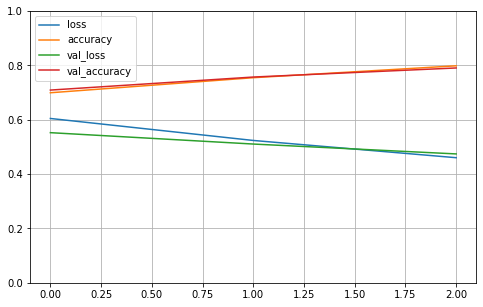

Train set ones/size 2524 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 287 / 959
Range of scores: 0.0031039375 to 0.9372175
Score threshold 0.5
Prediction set ones/size 106 / 959


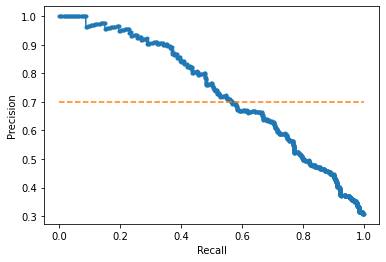

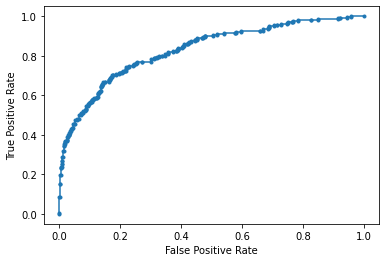

Accuracy: 79.04% Precision: 90.57% Recall: 33.45%
F1: 48.85% AUPRC: 73.59% AUROC: 83.10%
2023-02-06 19:24:26.210335
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:24:30.692390
PREDICT
2023-02-06 19:24:42.079167


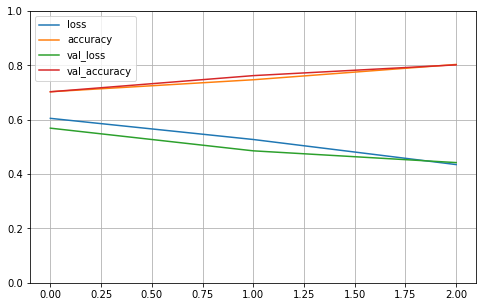

Train set ones/size 2525 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 286 / 959
Range of scores: 0.0025423851 to 0.9700817
Score threshold 0.5
Prediction set ones/size 152 / 959


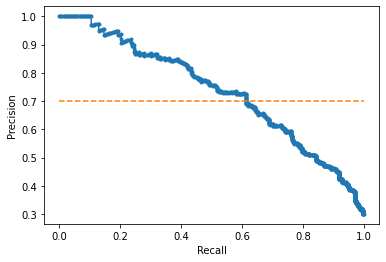

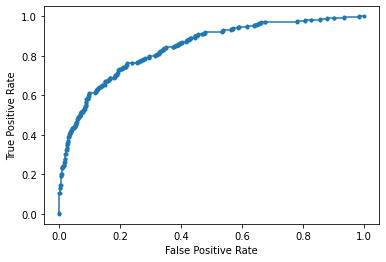

Accuracy: 80.19% Precision: 81.58% Recall: 43.36%
F1: 56.62% AUPRC: 73.48% AUROC: 84.23%
2023-02-06 19:24:42.813594
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:24:46.692785
PREDICT
2023-02-06 19:24:56.575039


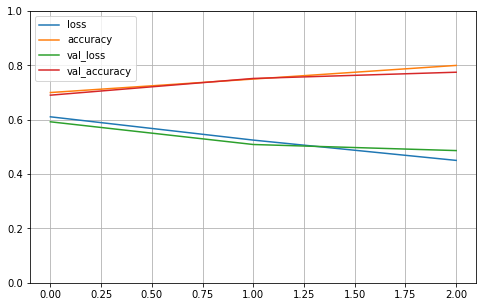

Train set ones/size 2513 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 298 / 959
Range of scores: 0.0077728685 to 0.98475987
Score threshold 0.5
Prediction set ones/size 282 / 959


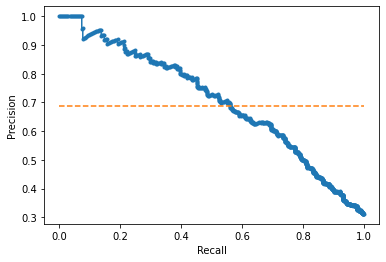

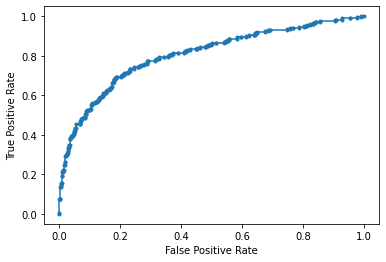

Accuracy: 77.48% Precision: 64.54% Recall: 61.07%
F1: 62.76% AUPRC: 70.63% AUROC: 80.57%
2023-02-06 19:24:57.258627
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:25:01.137780
PREDICT
2023-02-06 19:25:11.140380


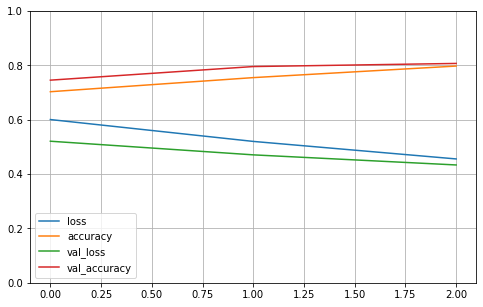

Train set ones/size 2548 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 263 / 959
Range of scores: 0.00020673485 to 0.97857153
Score threshold 0.5
Prediction set ones/size 124 / 959


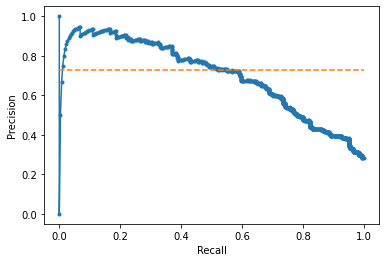

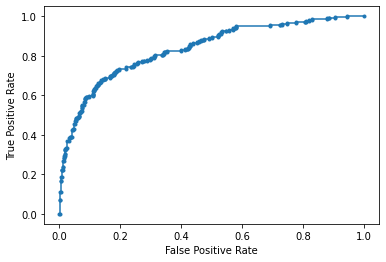

Accuracy: 80.71% Precision: 81.45% Recall: 38.40%
F1: 52.20% AUPRC: 69.83% AUROC: 83.52%
2023-02-06 19:25:11.819642
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:25:15.693620
PREDICT
2023-02-06 19:25:27.067036


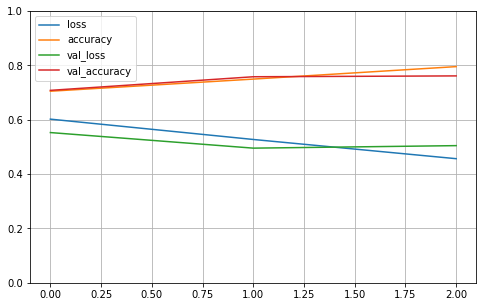

Train set ones/size 2512 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 299 / 959
Range of scores: 0.0040351674 to 0.9127971
Score threshold 0.5
Prediction set ones/size 84 / 959


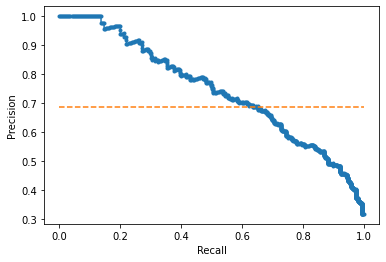

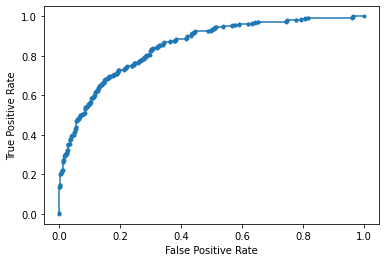

Accuracy: 76.12% Precision: 91.67% Recall: 25.75%
F1: 40.21% AUPRC: 74.69% AUROC: 84.92%
2023-02-06 19:25:27.776350
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:25:31.637755
PREDICT
2023-02-06 19:25:41.487490


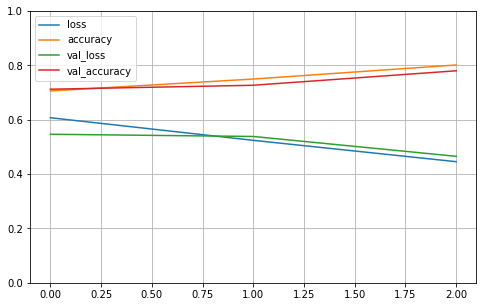

Train set ones/size 2533 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 278 / 959
Range of scores: 1.771157e-05 to 0.926323
Score threshold 0.5
Prediction set ones/size 103 / 959


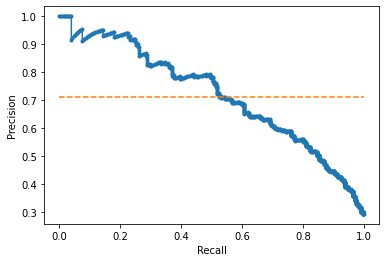

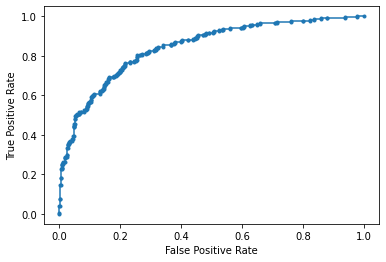

Accuracy: 78.00% Precision: 82.52% Recall: 30.58%
F1: 44.62% AUPRC: 72.11% AUROC: 84.31%
2023-02-06 19:25:42.145053
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:25:46.738789
PREDICT
2023-02-06 19:25:58.447673


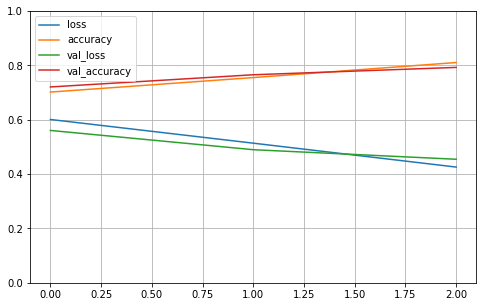

Train set ones/size 2531 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 280 / 959
Range of scores: 0.0061172186 to 0.9918093
Score threshold 0.5
Prediction set ones/size 263 / 959


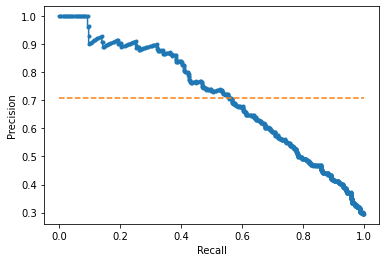

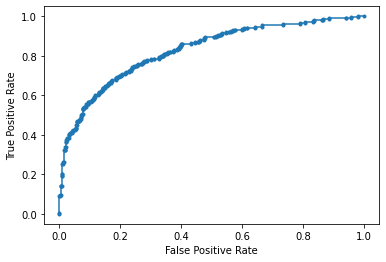

Accuracy: 79.25% Precision: 65.40% Recall: 61.43%
F1: 63.35% AUPRC: 71.49% AUROC: 82.74%
2023-02-06 19:25:59.525511
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:26:03.691291
PREDICT
2023-02-06 19:26:13.225840


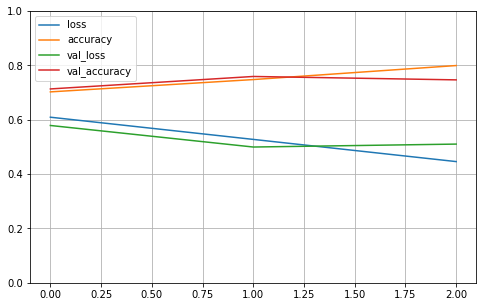

Train set ones/size 2539 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 272 / 959
Range of scores: 0.002453154 to 0.9953784
Score threshold 0.5
Prediction set ones/size 339 / 959


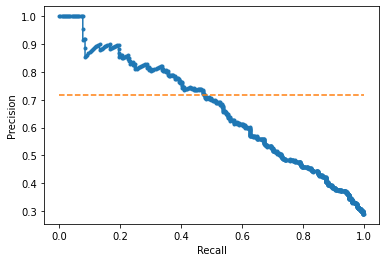

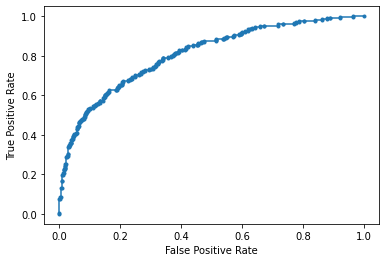

Accuracy: 74.66% Precision: 54.28% Recall: 67.65%
F1: 60.23% AUPRC: 67.05% AUROC: 80.77%
2023-02-06 19:26:14.178155
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:26:18.215280
PREDICT
2023-02-06 19:26:27.860045


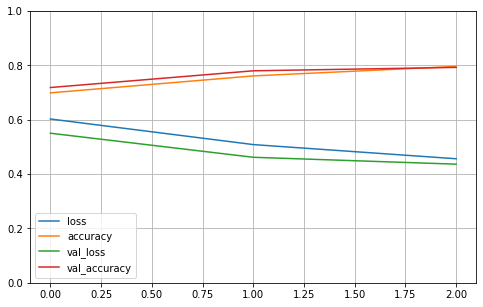

Train set ones/size 2540 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 271 / 959
Range of scores: 0.00360153 to 0.9636213
Score threshold 0.5
Prediction set ones/size 220 / 959


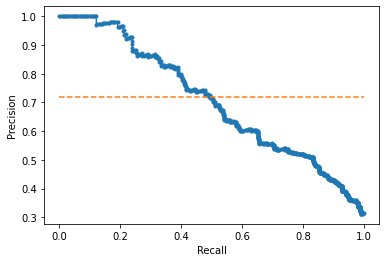

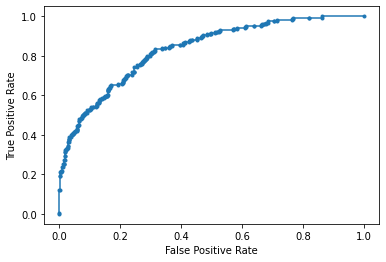

Accuracy: 79.25% Precision: 66.36% Recall: 53.87%
F1: 59.47% AUPRC: 70.69% AUROC: 83.22%
2023-02-06 19:26:28.803095
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:26:32.691605
PREDICT
2023-02-06 19:26:42.583924


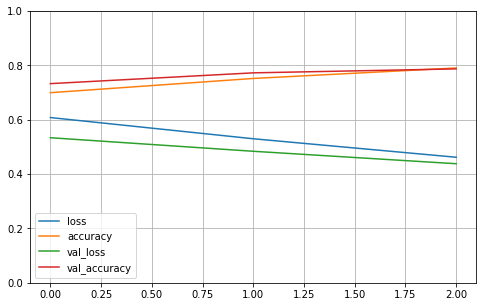

Train set ones/size 2534 / 8631
Compute valiation accuracy
Valid sizes (958, 4997) (958,)
Valid set ones/size 277 / 958
Range of scores: 0.0057607107 to 0.97261107
Score threshold 0.5
Prediction set ones/size 181 / 958


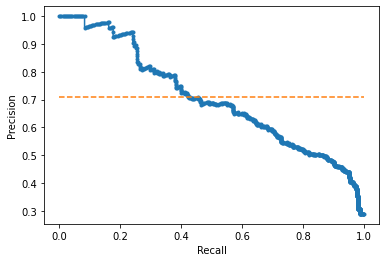

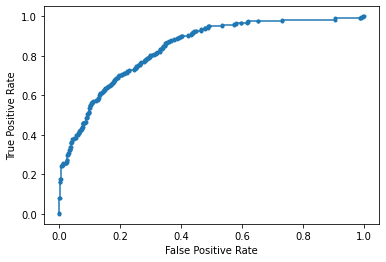

Accuracy: 78.71% Precision: 70.17% Recall: 45.85%
F1: 55.46% AUPRC: 70.66% AUROC: 83.98%
2023-02-06 19:26:43.329047

Completed cross validation 10 folds 3 epochs
 accuracy mean 78.34% +/- 1.84
 precision mean 74.85% +/- 12.43
 recall mean 46.14% +/- 14.40
 F1 mean 54.38% +/- 7.81
 AUPRC mean 71.42% +/- 2.20
 AUROC mean 83.14% +/- 1.45
Finished cell Line 5 HUVEC

2023-02-06 19:26:44.764934
Start cell Line 6 MCF.7
Number of RCI values loaded 2156
Num RCI: 2156
Load sequence...
Cross validation...
2023-02-06 19:27:02.374808
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:27:05.398552
PREDICT
2023-02-06 19:27:17.187562


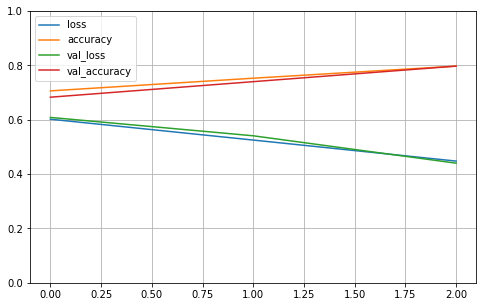

Train set ones/size 2986 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 351 / 1154
Range of scores: 0.002341882 to 0.99210066
Score threshold 0.5
Prediction set ones/size 259 / 1154


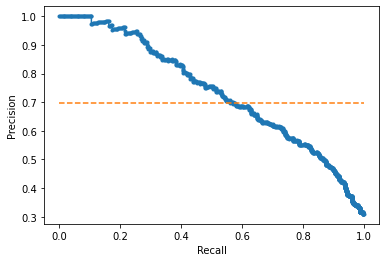

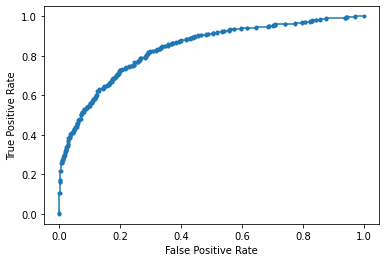

Accuracy: 79.72% Precision: 72.59% Recall: 53.56%
F1: 61.64% AUPRC: 73.86% AUROC: 83.80%
2023-02-06 19:27:17.946280
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:27:23.860392
PREDICT
2023-02-06 19:27:45.585945


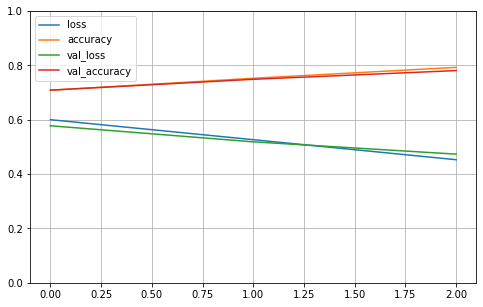

Train set ones/size 2980 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 357 / 1154
Range of scores: 0.0021176331 to 0.98577905
Score threshold 0.5
Prediction set ones/size 156 / 1154


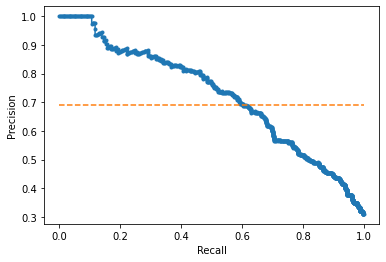

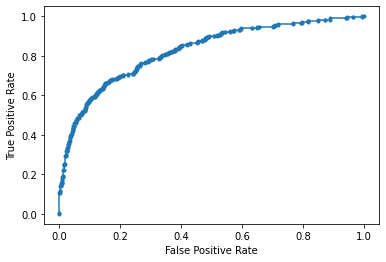

Accuracy: 78.08% Precision: 83.33% Recall: 36.41%
F1: 50.68% AUPRC: 72.41% AUROC: 82.60%
2023-02-06 19:27:46.725779
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:27:51.517057
PREDICT
2023-02-06 19:28:13.238716


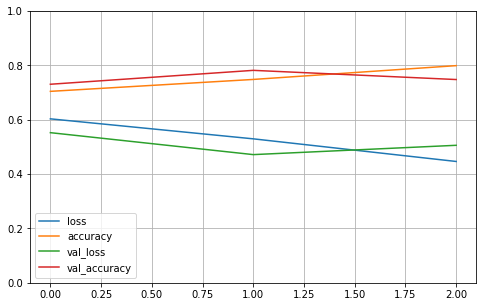

Train set ones/size 3020 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 317 / 1154
Range of scores: 0.012756395 to 0.9885194
Score threshold 0.5
Prediction set ones/size 426 / 1154


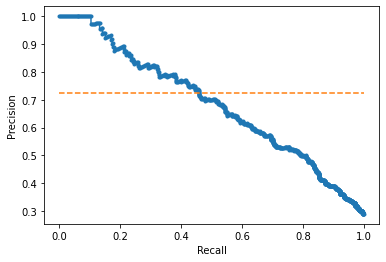

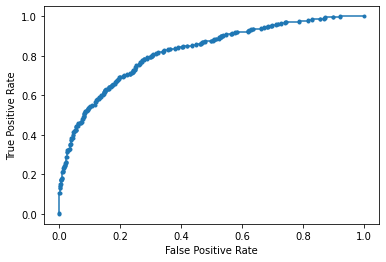

Accuracy: 74.78% Precision: 53.05% Recall: 71.29%
F1: 60.83% AUPRC: 68.61% AUROC: 82.19%
2023-02-06 19:28:14.456842
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:28:19.061358
PREDICT
2023-02-06 19:28:30.746441


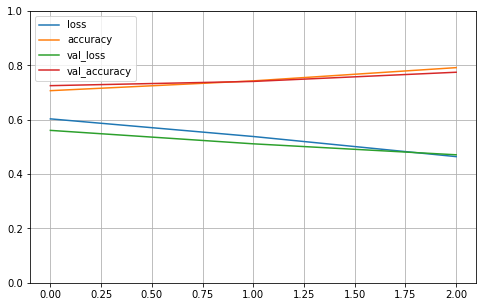

Train set ones/size 3003 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 334 / 1154
Range of scores: 0.0031613384 to 0.985152
Score threshold 0.5
Prediction set ones/size 246 / 1154


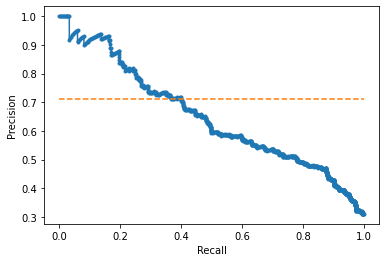

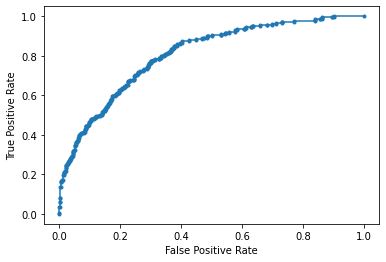

Accuracy: 77.47% Precision: 65.04% Recall: 47.90%
F1: 55.17% AUPRC: 65.16% AUROC: 80.72%
2023-02-06 19:28:31.693455
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:28:36.082049
PREDICT
2023-02-06 19:28:57.792229


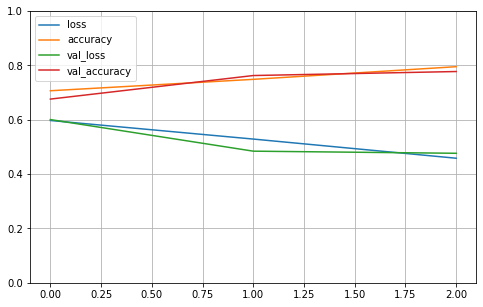

Train set ones/size 2993 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 344 / 1154
Range of scores: 0.006766088 to 0.9806505
Score threshold 0.5
Prediction set ones/size 373 / 1154


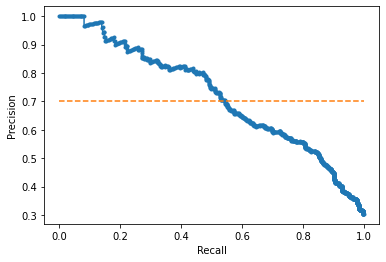

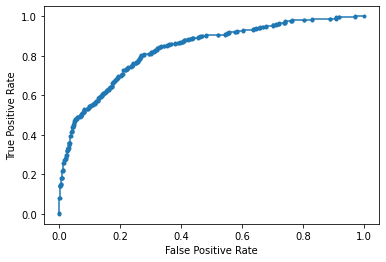

Accuracy: 77.73% Precision: 61.66% Recall: 66.86%
F1: 64.16% AUPRC: 72.04% AUROC: 83.36%
2023-02-06 19:28:58.686444
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:29:03.066217
PREDICT
2023-02-06 19:29:14.753273


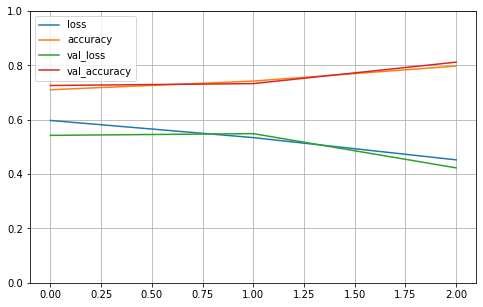

Train set ones/size 3015 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 322 / 1153
Range of scores: 0.002065246 to 0.98719984
Score threshold 0.5
Prediction set ones/size 183 / 1153


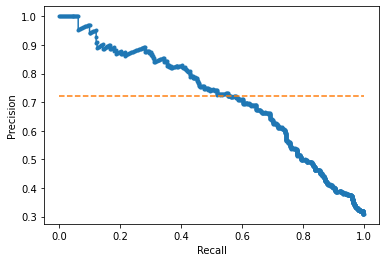

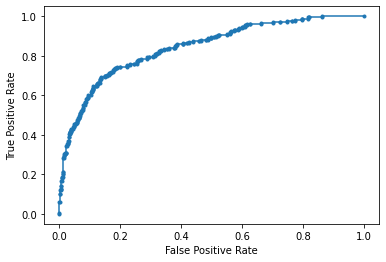

Accuracy: 81.18% Precision: 78.69% Recall: 44.72%
F1: 57.03% AUPRC: 71.73% AUROC: 84.28%
2023-02-06 19:29:15.541830
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:29:21.531737
PREDICT
2023-02-06 19:29:33.239668


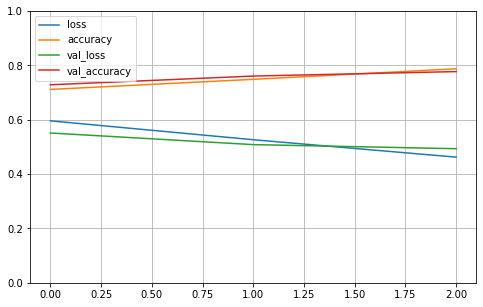

Train set ones/size 3013 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 324 / 1153
Range of scores: 0.00016690562 to 0.995378
Score threshold 0.5
Prediction set ones/size 269 / 1153


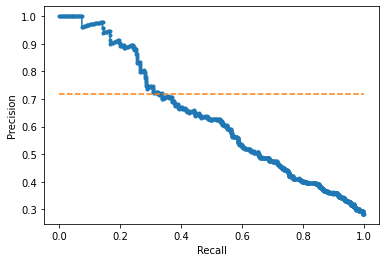

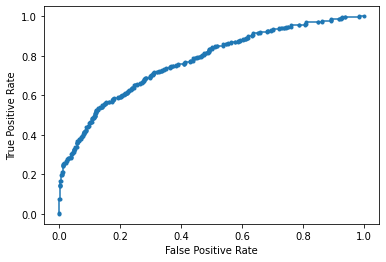

Accuracy: 77.71% Precision: 62.45% Recall: 51.85%
F1: 56.66% AUPRC: 63.69% AUROC: 77.21%
2023-02-06 19:29:34.374139
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:29:38.774633
PREDICT
2023-02-06 19:29:50.680100


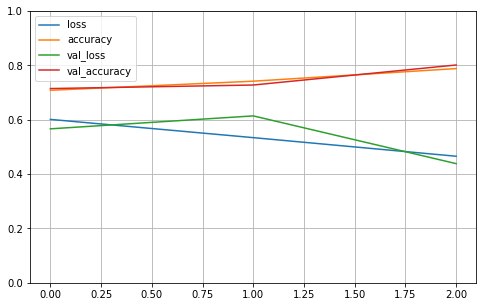

Train set ones/size 3005 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 332 / 1153
Range of scores: 0.0034560843 to 0.98524934
Score threshold 0.5
Prediction set ones/size 153 / 1153


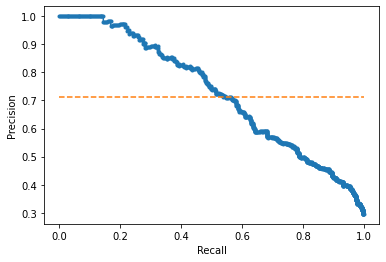

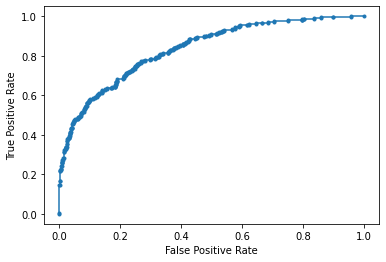

Accuracy: 80.14% Precision: 83.66% Recall: 38.55%
F1: 52.78% AUPRC: 72.74% AUROC: 83.59%
2023-02-06 19:29:51.460653
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:29:55.983690
PREDICT
2023-02-06 19:30:07.728235


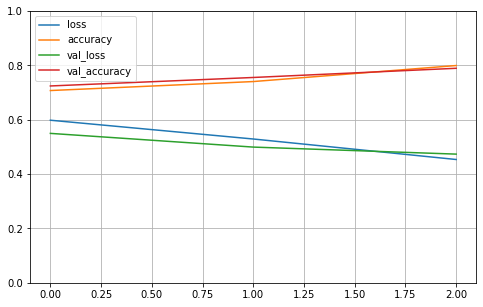

Train set ones/size 3010 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 327 / 1153
Range of scores: 0.001045844 to 0.97056186
Score threshold 0.5
Prediction set ones/size 156 / 1153


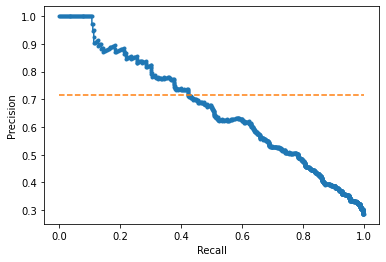

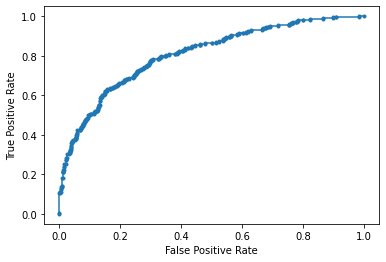

Accuracy: 78.92% Precision: 76.92% Recall: 36.70%
F1: 49.69% AUPRC: 67.08% AUROC: 80.73%
2023-02-06 19:30:08.510490
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:30:14.335904
PREDICT
2023-02-06 19:30:25.758724


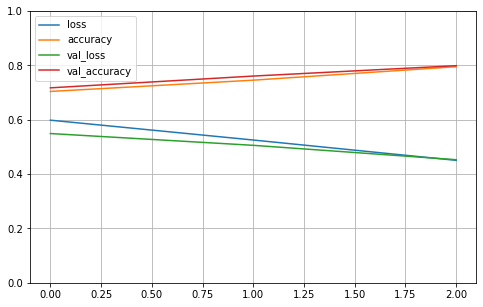

Train set ones/size 3008 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 329 / 1153
Range of scores: 0.0028445632 to 0.9954803
Score threshold 0.5
Prediction set ones/size 235 / 1153


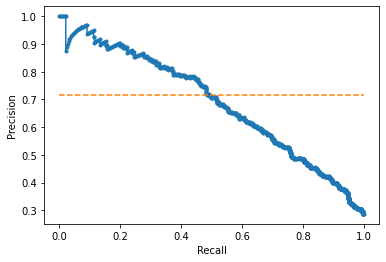

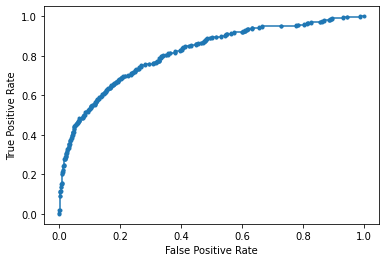

Accuracy: 79.88% Precision: 70.64% Recall: 50.46%
F1: 58.87% AUPRC: 68.74% AUROC: 81.56%
2023-02-06 19:30:26.931781

Completed cross validation 10 folds 3 epochs
 accuracy mean 78.56% +/- 1.82
 precision mean 70.80% +/- 10.15
 recall mean 49.83% +/- 11.92
 F1 mean 56.75% +/- 4.77
 AUPRC mean 69.61% +/- 3.48
 AUROC mean 82.00% +/- 2.10
Finished cell Line 6 MCF.7

2023-02-06 19:30:28.582963
Start cell Line 7 NCI.H460
Number of RCI values loaded 610
Num RCI: 610
Load sequence...
Cross validation...
2023-02-06 19:30:35.881762
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:30:37.377658
PREDICT
2023-02-06 19:30:43.577143


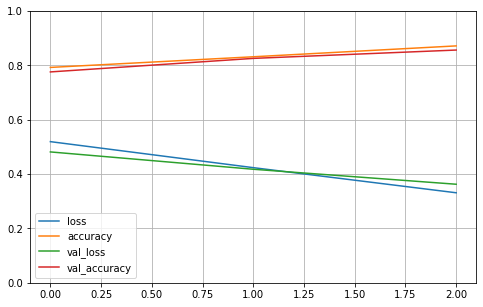

Train set ones/size 938 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 111 / 522
Range of scores: 0.0053637 to 0.99626595
Score threshold 0.5
Prediction set ones/size 86 / 522


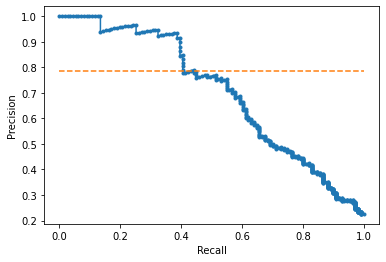

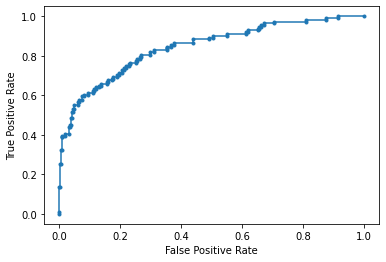

Accuracy: 85.63% Precision: 70.93% Recall: 54.95%
F1: 61.93% AUPRC: 70.32% AUROC: 84.42%
2023-02-06 19:30:44.220104
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:30:46.919597
PREDICT
2023-02-06 19:30:52.673928


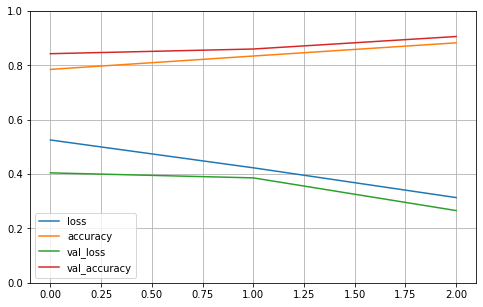

Train set ones/size 965 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 84 / 522
Range of scores: 0.0006896894 to 0.9726857
Score threshold 0.5
Prediction set ones/size 61 / 522


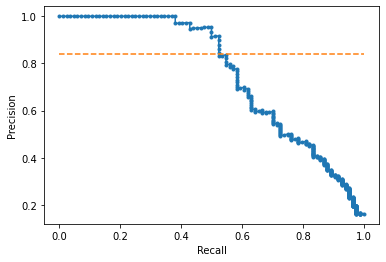

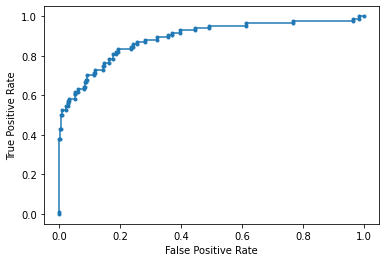

Accuracy: 90.61% Precision: 78.69% Recall: 57.14%
F1: 66.21% AUPRC: 75.38% AUROC: 88.85%
2023-02-06 19:30:53.659057
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:30:56.463121
PREDICT
2023-02-06 19:31:02.464549


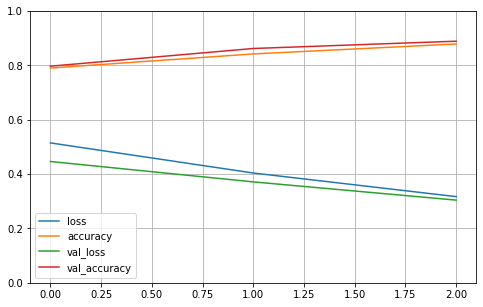

Train set ones/size 941 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 108 / 522
Range of scores: 0.005329113 to 0.9884183
Score threshold 0.5
Prediction set ones/size 74 / 522


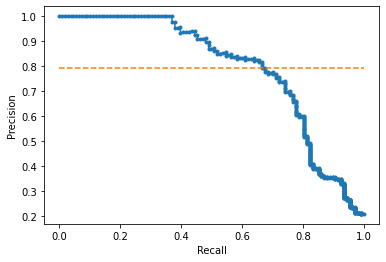

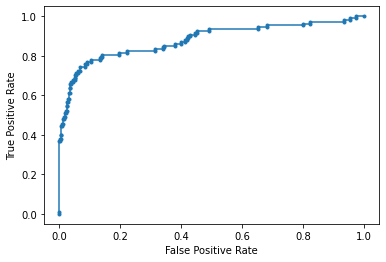

Accuracy: 88.89% Precision: 83.78% Recall: 57.41%
F1: 68.13% AUPRC: 79.43% AUROC: 87.97%
2023-02-06 19:31:03.101409
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:31:06.689958
PREDICT
2023-02-06 19:31:12.984610


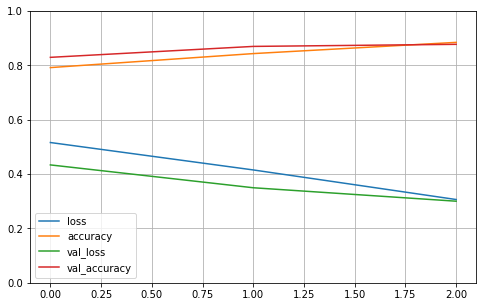

Train set ones/size 956 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 93 / 522
Range of scores: 0.001289451 to 0.99742174
Score threshold 0.5
Prediction set ones/size 83 / 522


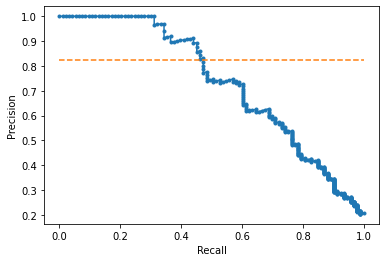

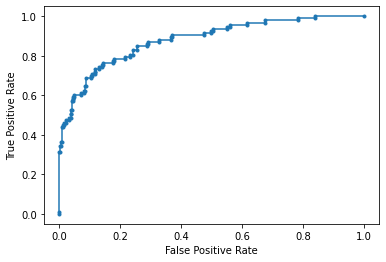

Accuracy: 87.74% Precision: 67.47% Recall: 60.22%
F1: 63.64% AUPRC: 73.26% AUROC: 88.05%
2023-02-06 19:31:13.717978
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:31:16.455277
PREDICT
2023-02-06 19:31:22.443786


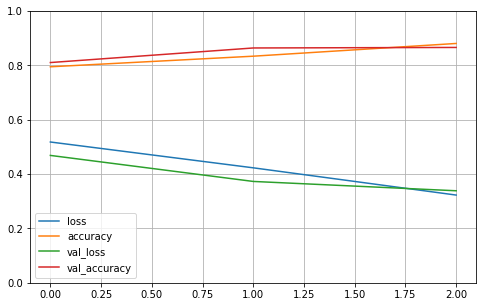

Train set ones/size 947 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 102 / 522
Range of scores: 0.0003331641 to 0.9930782
Score threshold 0.5
Prediction set ones/size 40 / 522


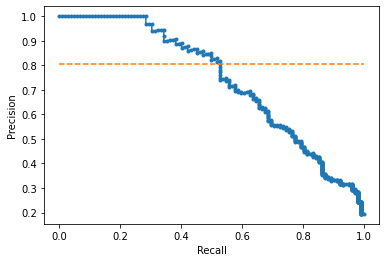

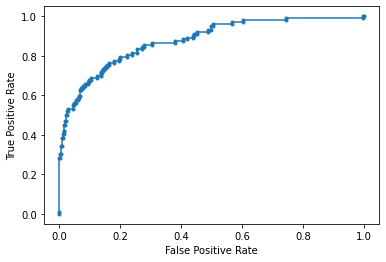

Accuracy: 86.59% Precision: 90.00% Recall: 35.29%
F1: 50.70% AUPRC: 73.91% AUROC: 87.79%
2023-02-06 19:31:23.130146
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:31:25.828886
PREDICT
2023-02-06 19:31:31.844313


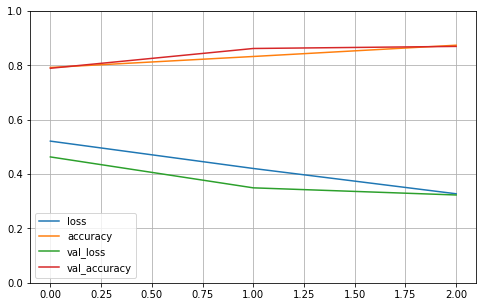

Train set ones/size 939 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 110 / 522
Range of scores: 0.0052455575 to 0.9821087
Score threshold 0.5
Prediction set ones/size 68 / 522


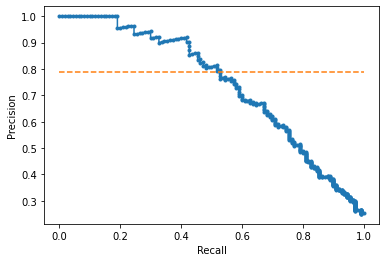

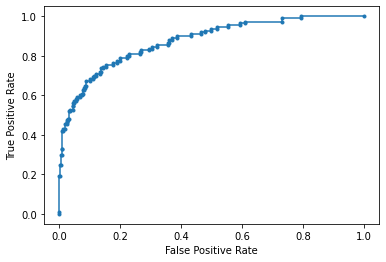

Accuracy: 86.97% Precision: 80.88% Recall: 50.00%
F1: 61.80% AUPRC: 74.14% AUROC: 87.62%
2023-02-06 19:31:32.773763
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:31:35.695876
PREDICT
2023-02-06 19:31:41.728643


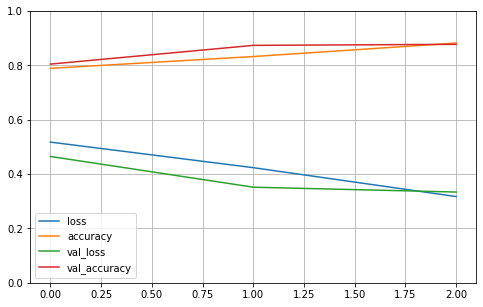

Train set ones/size 942 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 107 / 522
Range of scores: 0.0011983794 to 0.9957618
Score threshold 0.5
Prediction set ones/size 57 / 522


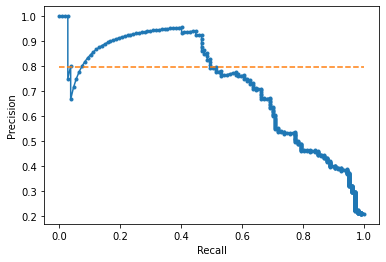

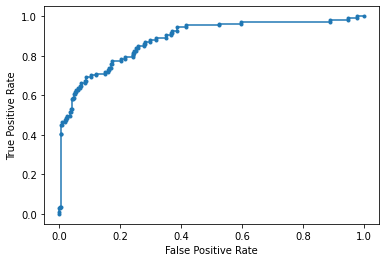

Accuracy: 87.74% Precision: 87.72% Recall: 46.73%
F1: 60.98% AUPRC: 72.78% AUROC: 88.32%
2023-02-06 19:31:42.426162
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:31:45.657957
PREDICT
2023-02-06 19:31:51.715073


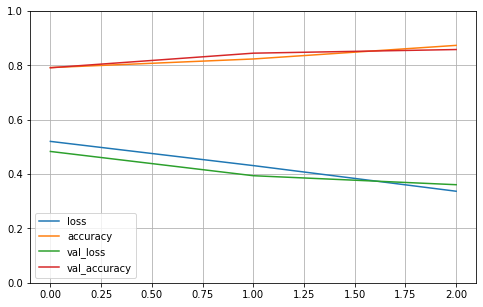

Train set ones/size 940 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 109 / 522
Range of scores: 0.0010272955 to 0.989902
Score threshold 0.5
Prediction set ones/size 65 / 522


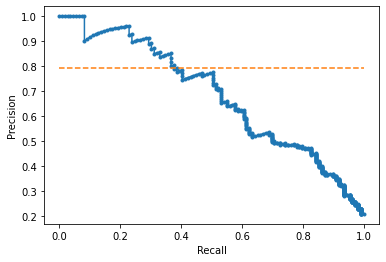

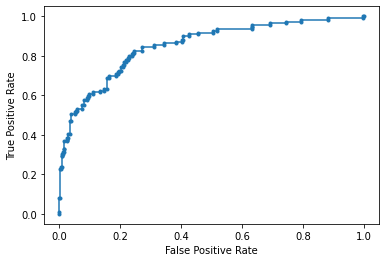

Accuracy: 85.82% Precision: 76.92% Recall: 45.87%
F1: 57.47% AUPRC: 68.32% AUROC: 85.17%
2023-02-06 19:31:52.359276
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:31:55.098385
PREDICT
2023-02-06 19:32:01.069279


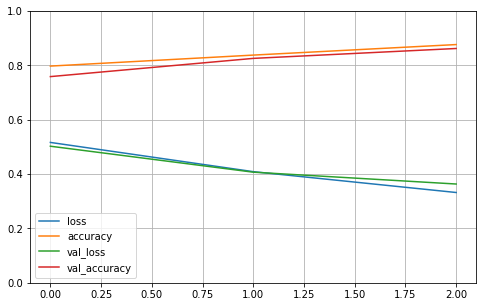

Train set ones/size 923 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 126 / 522
Range of scores: 0.0029156208 to 0.99050444
Score threshold 0.5
Prediction set ones/size 62 / 522


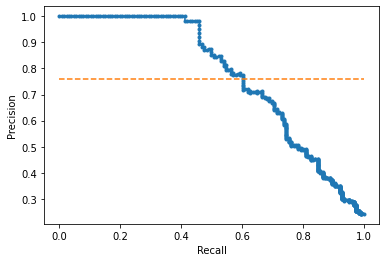

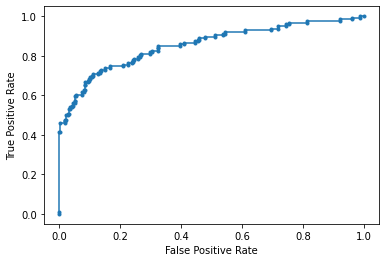

Accuracy: 86.21% Precision: 93.55% Recall: 46.03%
F1: 61.70% AUPRC: 77.37% AUROC: 85.52%
2023-02-06 19:32:01.819138
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:32:04.521926
PREDICT
2023-02-06 19:32:10.540480


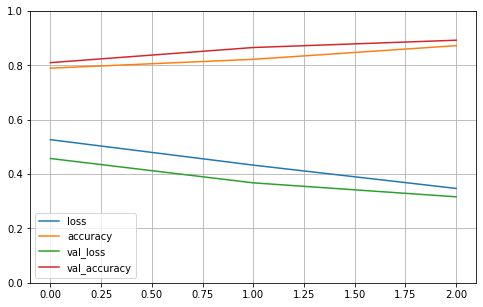

Train set ones/size 950 / 4698
Compute valiation accuracy
Valid sizes (521, 4997) (521,)
Valid set ones/size 99 / 521
Range of scores: 0.00435164 to 0.9838255
Score threshold 0.5
Prediction set ones/size 57 / 521


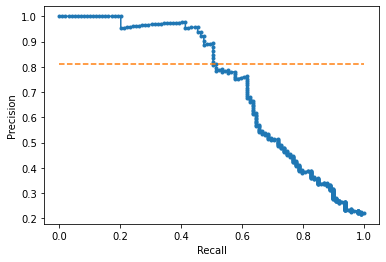

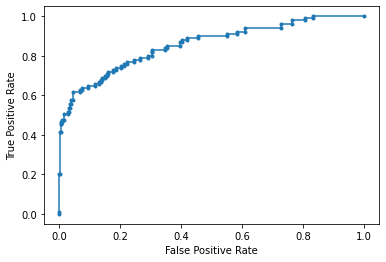

Accuracy: 89.25% Precision: 87.72% Recall: 50.51%
F1: 64.10% AUPRC: 73.12% AUROC: 85.61%
2023-02-06 19:32:11.185032

Completed cross validation 10 folds 3 epochs
 accuracy mean 87.55% +/- 1.63
 precision mean 81.77% +/- 8.41
 recall mean 50.42% +/- 7.40
 F1 mean 61.67% +/- 4.84
 AUPRC mean 73.80% +/- 3.18
 AUROC mean 86.93% +/- 1.57
Finished cell Line 7 NCI.H460

2023-02-06 19:32:12.566096
Start cell Line 8 NHEK
Number of RCI values loaded 1080
Num RCI: 1080
Load sequence...
Cross validation...
2023-02-06 19:32:25.202143
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:32:28.672987
PREDICT
2023-02-06 19:32:36.738428


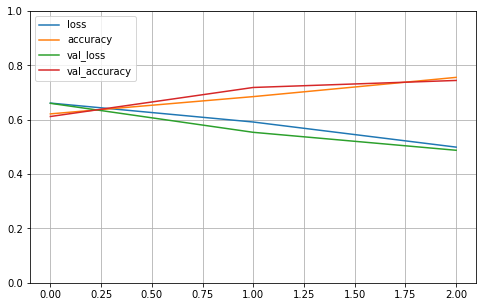

Train set ones/size 2762 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 317 / 814
Range of scores: 0.0025817868 to 0.9924408
Score threshold 0.5
Prediction set ones/size 349 / 814


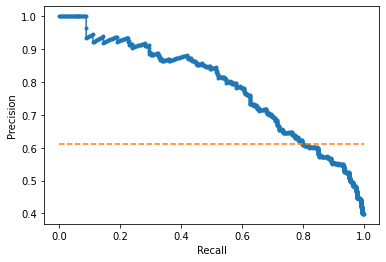

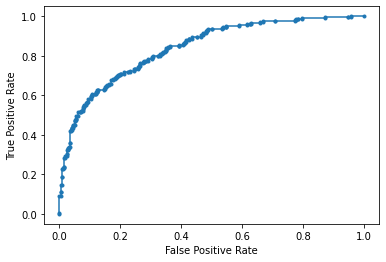

Accuracy: 74.45% Precision: 65.62% Recall: 72.24%
F1: 68.77% AUPRC: 78.50% AUROC: 84.02%
2023-02-06 19:32:37.442220
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:32:41.878339
PREDICT
2023-02-06 19:32:53.174659


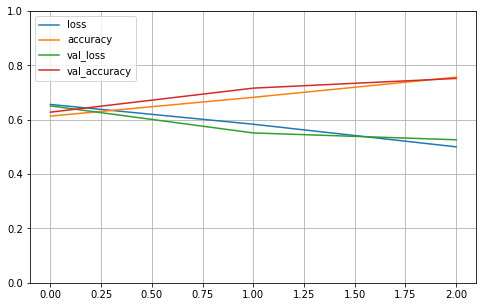

Train set ones/size 2770 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 309 / 814
Range of scores: 0.0034468311 to 0.9821062
Score threshold 0.5
Prediction set ones/size 187 / 814


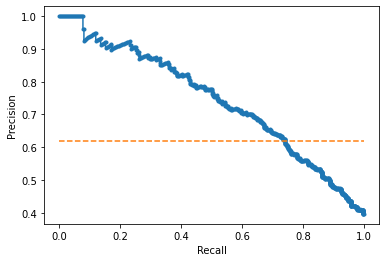

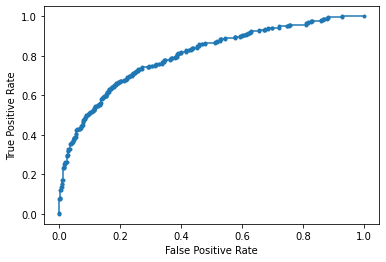

Accuracy: 75.18% Precision: 78.61% Recall: 47.57%
F1: 59.27% AUPRC: 74.29% AUROC: 80.30%
2023-02-06 19:32:53.878219
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:32:57.402525
PREDICT
2023-02-06 19:33:08.708866


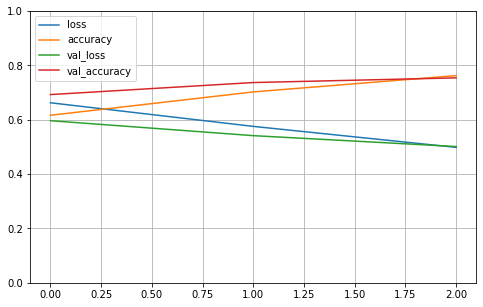

Train set ones/size 2787 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 292 / 813
Range of scores: 0.0046091084 to 0.990742
Score threshold 0.5
Prediction set ones/size 292 / 813


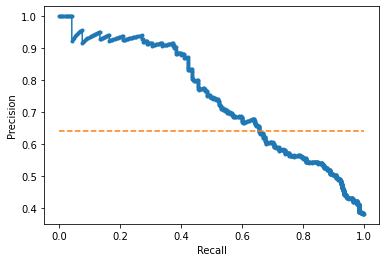

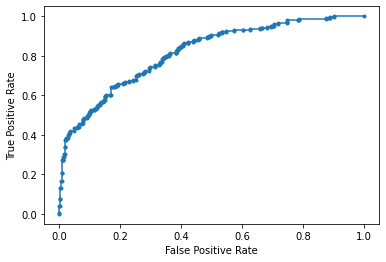

Accuracy: 75.40% Precision: 65.75% Recall: 65.75%
F1: 65.75% AUPRC: 74.50% AUROC: 81.63%
2023-02-06 19:33:09.432207
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:33:12.941150
PREDICT
2023-02-06 19:33:21.532146


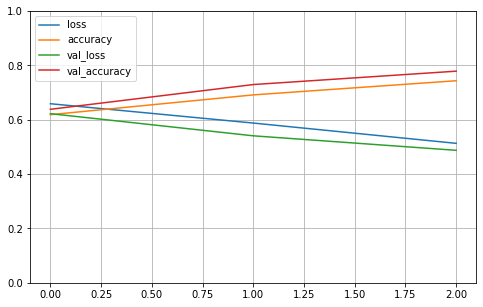

Train set ones/size 2763 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 316 / 813
Range of scores: 0.010911207 to 0.97430915
Score threshold 0.5
Prediction set ones/size 242 / 813


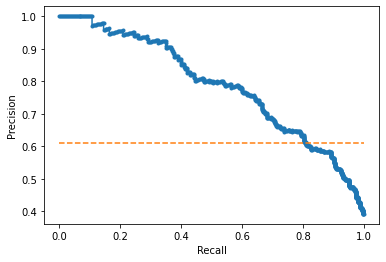

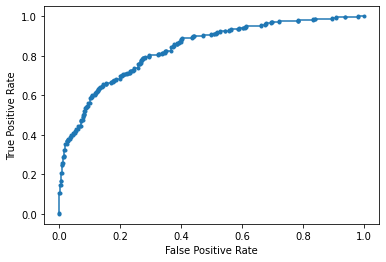

Accuracy: 77.86% Precision: 78.10% Recall: 59.81%
F1: 67.74% AUPRC: 78.79% AUROC: 83.62%
2023-02-06 19:33:22.273574
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:33:25.803303
PREDICT
2023-02-06 19:33:34.326749


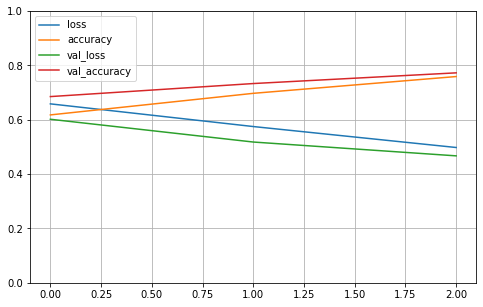

Train set ones/size 2772 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 307 / 813
Range of scores: 0.008737439 to 0.99369735
Score threshold 0.5
Prediction set ones/size 246 / 813


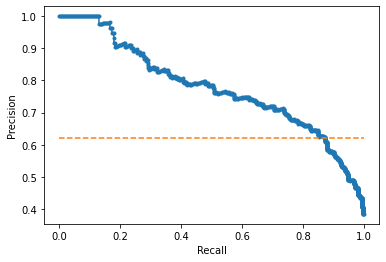

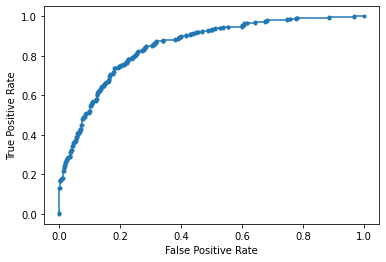

Accuracy: 77.24% Precision: 74.80% Recall: 59.93%
F1: 66.55% AUPRC: 77.81% AUROC: 85.02%
2023-02-06 19:33:35.038150
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:33:38.566255
PREDICT
2023-02-06 19:33:46.948534


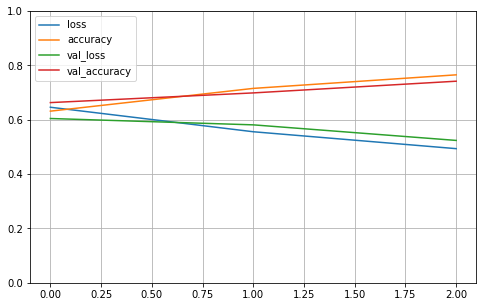

Train set ones/size 2778 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 301 / 813
Range of scores: 0.0034680527 to 0.9818209
Score threshold 0.5
Prediction set ones/size 247 / 813


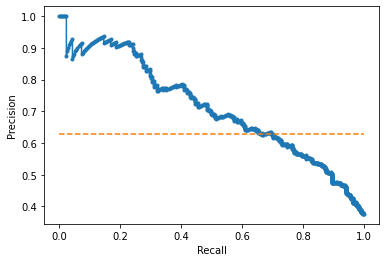

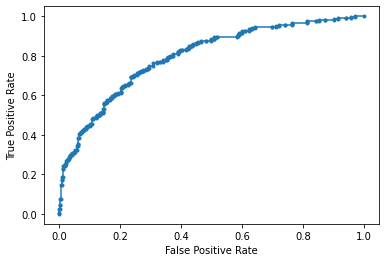

Accuracy: 74.17% Precision: 68.42% Recall: 56.15%
F1: 61.68% AUPRC: 71.16% AUROC: 79.63%
2023-02-06 19:33:47.653255
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:33:51.161261
PREDICT
2023-02-06 19:33:59.576560


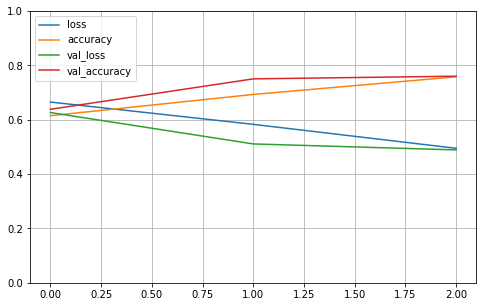

Train set ones/size 2757 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 322 / 813
Range of scores: 0.020547332 to 0.9926785
Score threshold 0.5
Prediction set ones/size 425 / 813


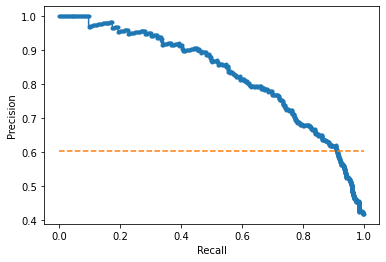

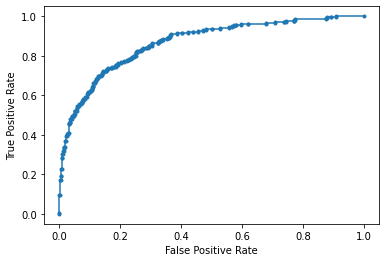

Accuracy: 76.01% Precision: 64.94% Recall: 85.71%
F1: 73.90% AUPRC: 82.87% AUROC: 86.70%
2023-02-06 19:34:00.492091
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:34:03.979975
PREDICT
2023-02-06 19:34:15.265005


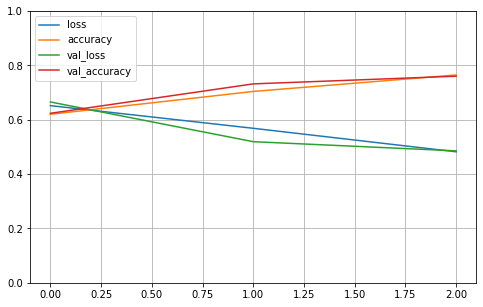

Train set ones/size 2772 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 307 / 813
Range of scores: 0.00857809 to 0.98446596
Score threshold 0.5
Prediction set ones/size 274 / 813


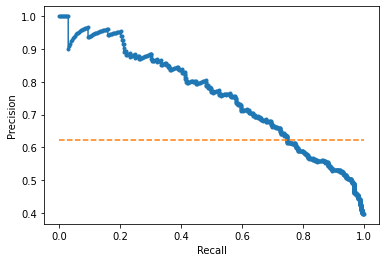

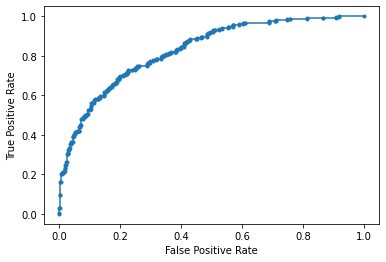

Accuracy: 76.01% Precision: 70.44% Recall: 62.87%
F1: 66.44% AUPRC: 75.77% AUROC: 82.93%
2023-02-06 19:34:15.976245
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:34:19.592515
PREDICT
2023-02-06 19:34:28.237377


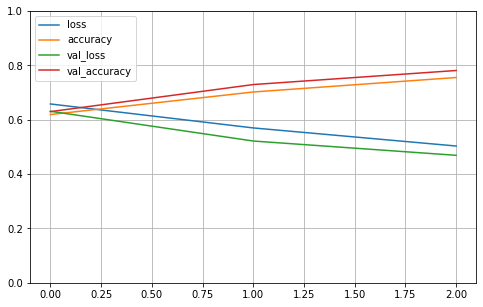

Train set ones/size 2784 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 295 / 813
Range of scores: 0.0064662495 to 0.99018973
Score threshold 0.5
Prediction set ones/size 303 / 813


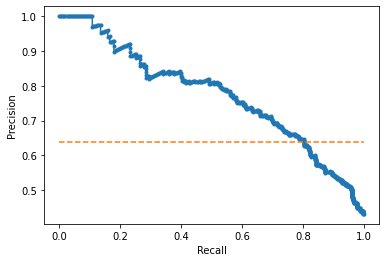

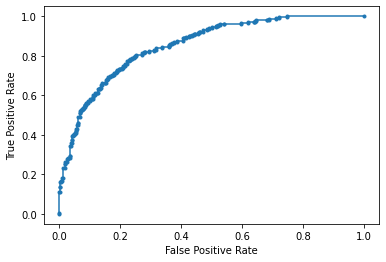

Accuracy: 78.11% Precision: 69.31% Recall: 71.19%
F1: 70.23% AUPRC: 77.37% AUROC: 85.33%
2023-02-06 19:34:28.948399
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:34:32.447993
PREDICT
2023-02-06 19:34:43.754442


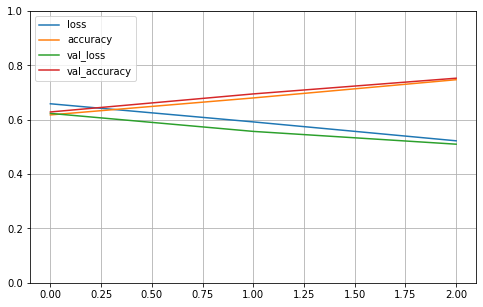

Train set ones/size 2766 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 313 / 813
Range of scores: 0.01257063 to 0.973961
Score threshold 0.5
Prediction set ones/size 268 / 813


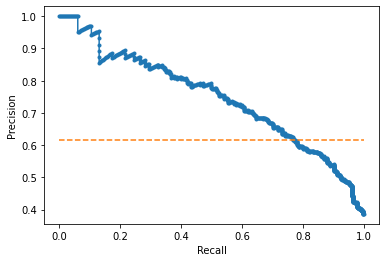

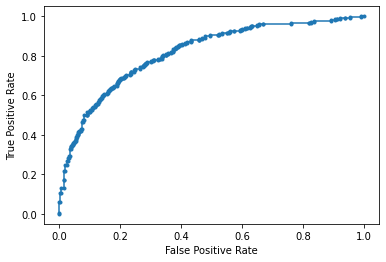

Accuracy: 75.28% Precision: 70.90% Recall: 60.70%
F1: 65.40% AUPRC: 74.73% AUROC: 81.58%
2023-02-06 19:34:44.488713

Completed cross validation 10 folds 3 epochs
 accuracy mean 75.97% +/- 1.36
 precision mean 70.69% +/- 5.00
 recall mean 64.19% +/- 10.39
 F1 mean 66.57% +/- 4.12
 AUPRC mean 76.58% +/- 3.22
 AUROC mean 83.08% +/- 2.29
Finished cell Line 8 NHEK

2023-02-06 19:34:45.899363
Start cell Line 9 SK.MEL.5
Number of RCI values loaded 534
Num RCI: 534
Load sequence...
Cross validation...
2023-02-06 19:34:55.098882
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:34:56.516665
PREDICT
2023-02-06 19:35:02.565889


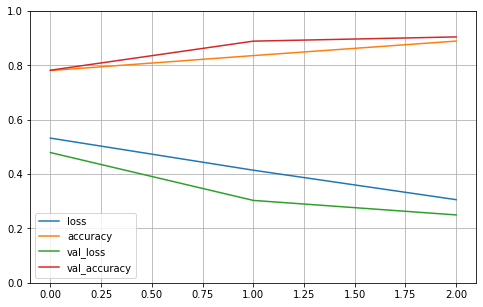

Train set ones/size 968 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 113 / 514
Range of scores: 0.0007948637 to 0.990131
Score threshold 0.5
Prediction set ones/size 76 / 514


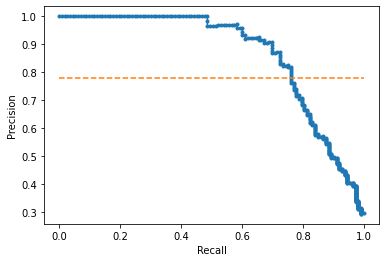

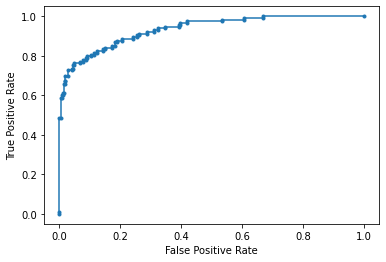

Accuracy: 90.47% Precision: 92.11% Recall: 61.95%
F1: 74.07% AUPRC: 86.73% AUROC: 93.39%
2023-02-06 19:35:03.279951
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:35:06.934141
PREDICT
2023-02-06 19:35:12.967257


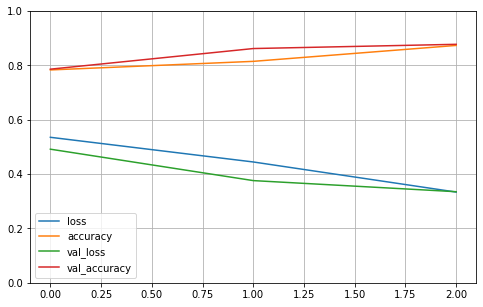

Train set ones/size 971 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 110 / 514
Range of scores: 0.0006923407 to 0.9892917
Score threshold 0.5
Prediction set ones/size 59 / 514


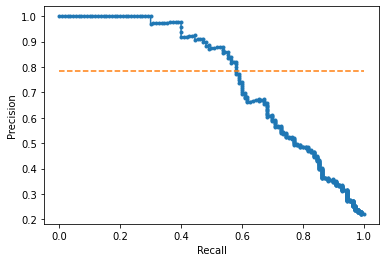

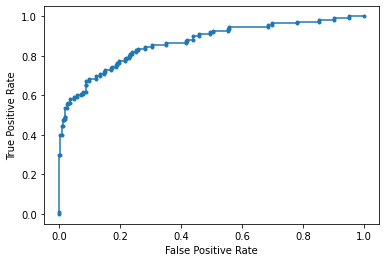

Accuracy: 87.74% Precision: 89.83% Recall: 48.18%
F1: 62.72% AUPRC: 76.14% AUROC: 86.72%
2023-02-06 19:35:13.636847
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:35:16.305231
PREDICT
2023-02-06 19:35:22.442607


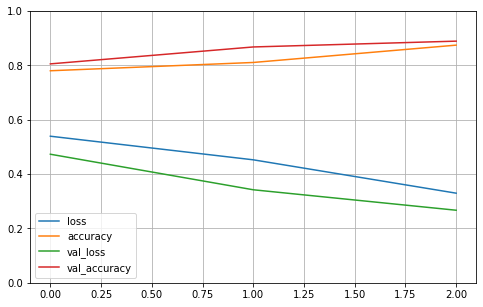

Train set ones/size 981 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 100 / 514
Range of scores: 0.00060970144 to 0.9838395
Score threshold 0.5
Prediction set ones/size 47 / 514


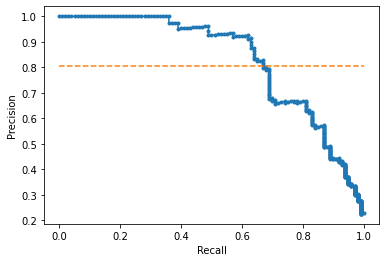

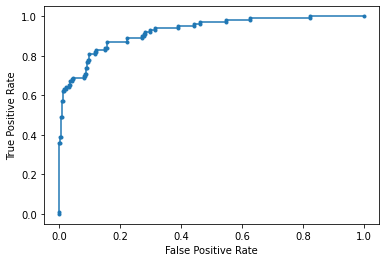

Accuracy: 88.91% Precision: 95.74% Recall: 45.00%
F1: 61.22% AUPRC: 82.91% AUROC: 92.46%
2023-02-06 19:35:23.156575
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:35:25.815285
PREDICT
2023-02-06 19:35:31.835644


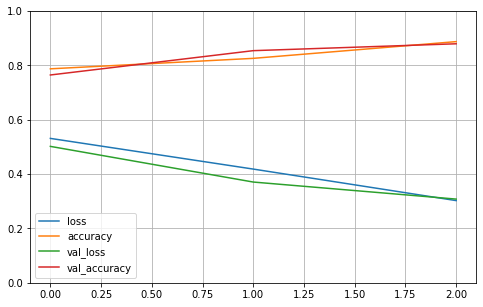

Train set ones/size 962 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 119 / 514
Range of scores: 0.00035310618 to 0.9939693
Score threshold 0.5
Prediction set ones/size 95 / 514


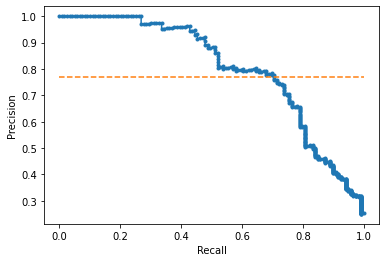

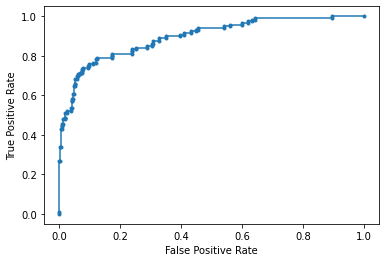

Accuracy: 87.94% Precision: 80.00% Recall: 63.87%
F1: 71.03% AUPRC: 80.15% AUROC: 89.56%
2023-02-06 19:35:32.842860
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:35:35.649683
PREDICT
2023-02-06 19:35:41.674788


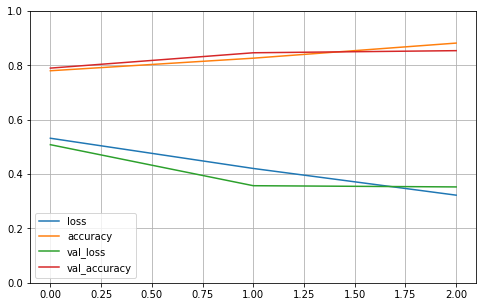

Train set ones/size 971 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 110 / 514
Range of scores: 0.00019211865 to 0.9730953
Score threshold 0.5
Prediction set ones/size 39 / 514


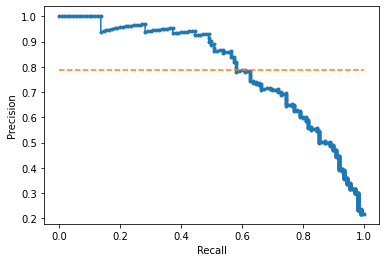

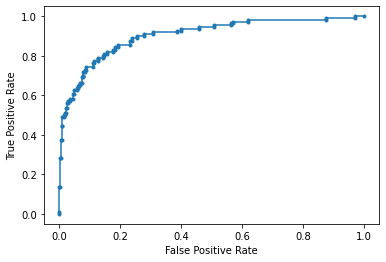

Accuracy: 85.41% Precision: 94.87% Recall: 33.64%
F1: 49.66% AUPRC: 79.29% AUROC: 90.41%
2023-02-06 19:35:42.343154
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:35:46.157912
PREDICT
2023-02-06 19:35:51.820201


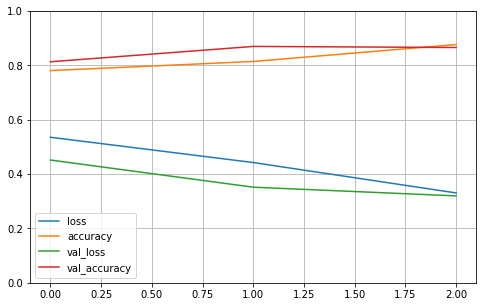

Train set ones/size 985 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 96 / 514
Range of scores: 0.0010450353 to 0.9929853
Score threshold 0.5
Prediction set ones/size 97 / 514


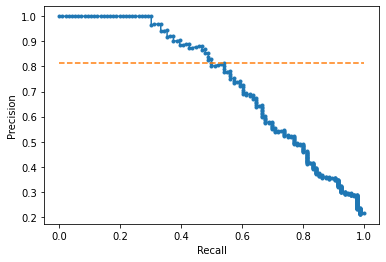

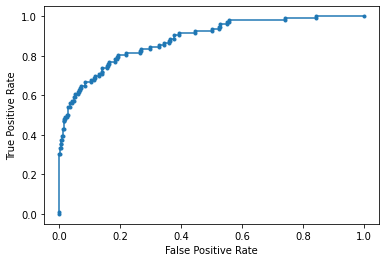

Accuracy: 86.58% Precision: 63.92% Recall: 64.58%
F1: 64.25% AUPRC: 74.26% AUROC: 88.31%
2023-02-06 19:35:52.570857
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:35:55.253284
PREDICT
2023-02-06 19:36:01.253702


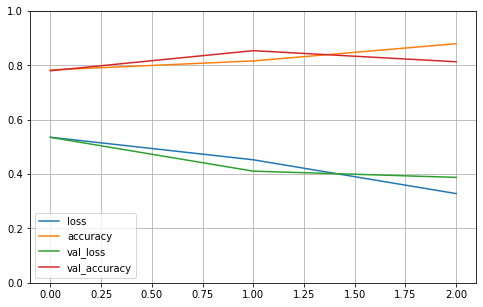

Train set ones/size 964 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 117 / 514
Range of scores: 0.006234478 to 0.9982285
Score threshold 0.5
Prediction set ones/size 179 / 514


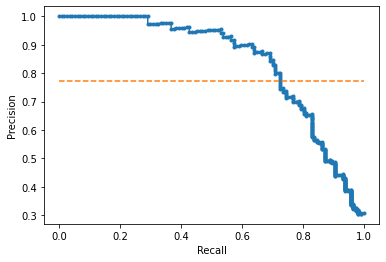

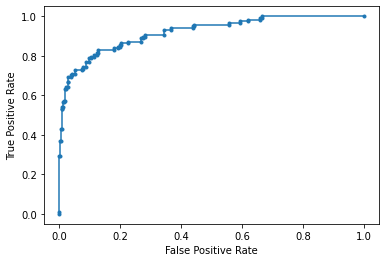

Accuracy: 81.32% Precision: 55.87% Recall: 85.47%
F1: 67.57% AUPRC: 84.12% AUROC: 91.96%
2023-02-06 19:36:01.946757
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:36:04.634828
PREDICT
2023-02-06 19:36:10.089857


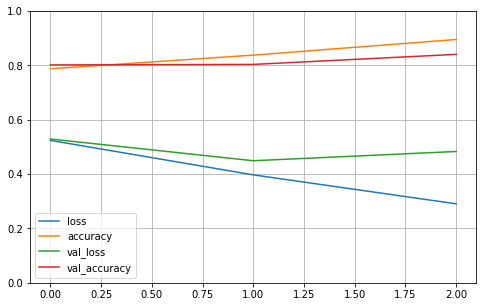

Train set ones/size 965 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 116 / 514
Range of scores: 5.338085e-05 to 0.98282325
Score threshold 0.5
Prediction set ones/size 42 / 514


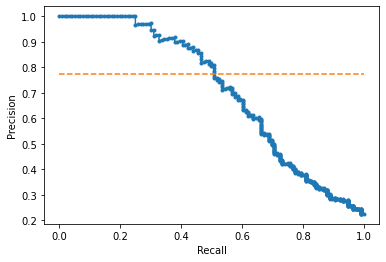

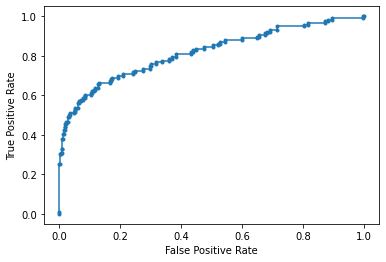

Accuracy: 84.05% Precision: 90.48% Recall: 32.76%
F1: 48.10% AUPRC: 70.80% AUROC: 81.68%
2023-02-06 19:36:10.864731
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:36:14.178575
PREDICT
2023-02-06 19:36:19.705371


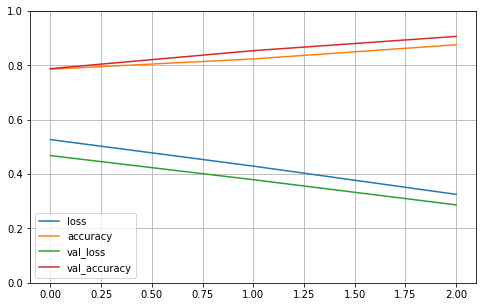

Train set ones/size 972 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 109 / 514
Range of scores: 0.0006560754 to 0.9944026
Score threshold 0.5
Prediction set ones/size 75 / 514


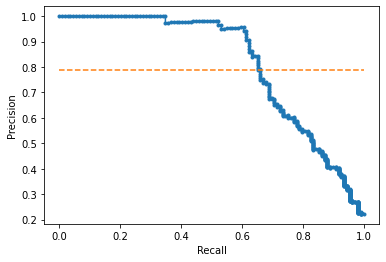

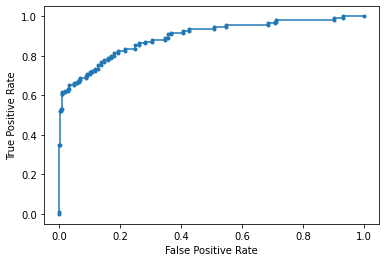

Accuracy: 90.66% Precision: 90.67% Recall: 62.39%
F1: 73.91% AUPRC: 81.42% AUROC: 89.58%
2023-02-06 19:36:20.445129
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:36:23.190140
PREDICT
2023-02-06 19:36:29.489291


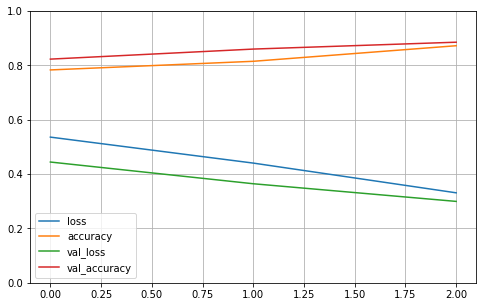

Train set ones/size 990 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 91 / 514
Range of scores: 0.0016369208 to 0.9792997
Score threshold 0.5
Prediction set ones/size 56 / 514


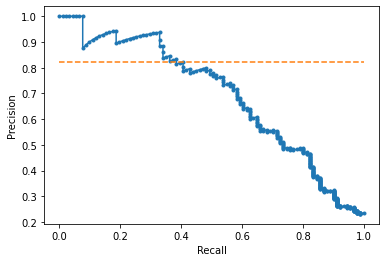

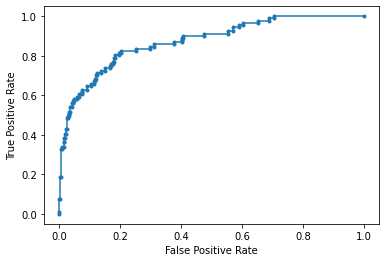

Accuracy: 88.52% Precision: 78.57% Recall: 48.35%
F1: 59.86% AUPRC: 69.37% AUROC: 87.39%
2023-02-06 19:36:30.175379

Completed cross validation 10 folds 3 epochs
 accuracy mean 87.16% +/- 2.91
 precision mean 83.20% +/- 13.65
 recall mean 54.62% +/- 16.13
 F1 mean 63.24% +/- 9.07
 AUPRC mean 78.52% +/- 5.74
 AUROC mean 89.15% +/- 3.40
Finished cell Line 9 SK.MEL.5

2023-02-06 19:36:31.518019
Start cell Line 10 SK.N.DZ
Number of RCI values loaded 603
Num RCI: 603
Load sequence...
Cross validation...
2023-02-06 19:36:41.547743
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:36:43.111113
PREDICT
2023-02-06 19:36:54.378811


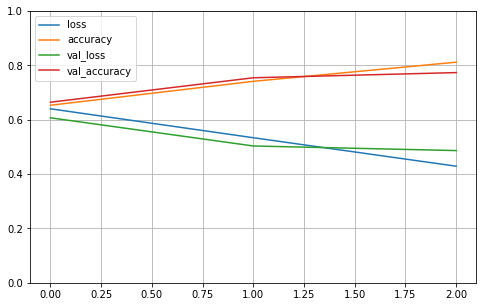

Train set ones/size 1772 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 211 / 578
Range of scores: 0.0012167993 to 0.98179746
Score threshold 0.5
Prediction set ones/size 106 / 578


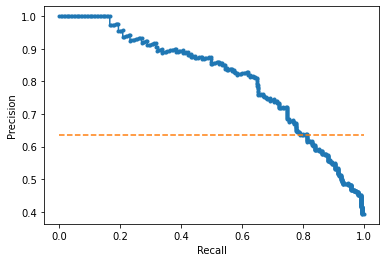

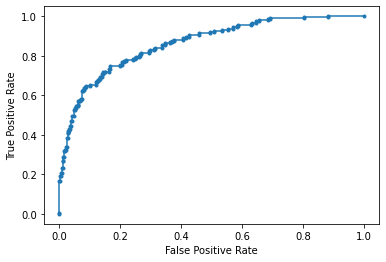

Accuracy: 77.34% Precision: 87.74% Recall: 44.08%
F1: 58.68% AUPRC: 80.93% AUROC: 86.35%
2023-02-06 19:36:55.124263
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:36:57.985247
PREDICT
2023-02-06 19:37:04.120814


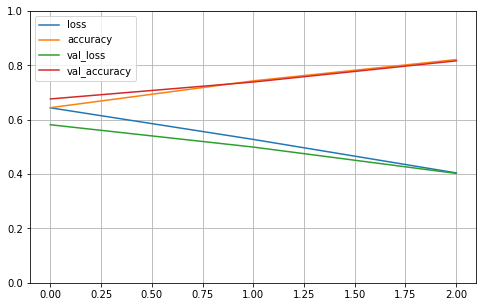

Train set ones/size 1791 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 192 / 578
Range of scores: 0.0005917907 to 0.98582953
Score threshold 0.5
Prediction set ones/size 124 / 578


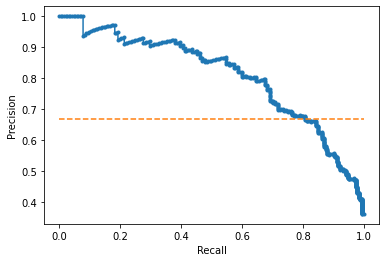

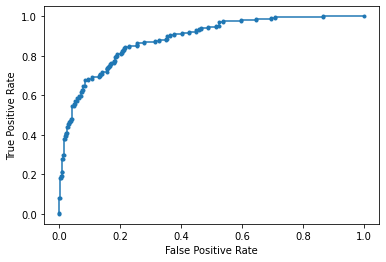

Accuracy: 81.66% Precision: 84.68% Recall: 54.69%
F1: 66.46% AUPRC: 80.98% AUROC: 88.51%
2023-02-06 19:37:05.069804
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:37:08.058320
PREDICT
2023-02-06 19:37:14.235150


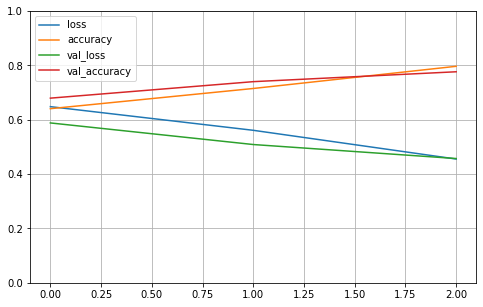

Train set ones/size 1800 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 183 / 577
Range of scores: 0.0037914196 to 0.9908494
Score threshold 0.5
Prediction set ones/size 226 / 577


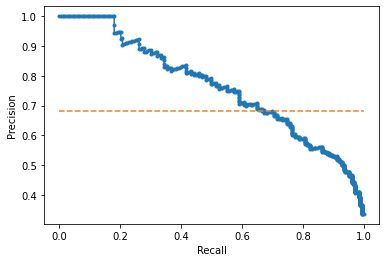

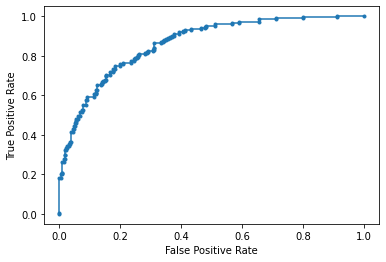

Accuracy: 77.64% Precision: 61.95% Recall: 76.50%
F1: 68.46% AUPRC: 76.41% AUROC: 86.28%
2023-02-06 19:37:14.977417
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:37:19.024369
PREDICT
2023-02-06 19:37:25.180278


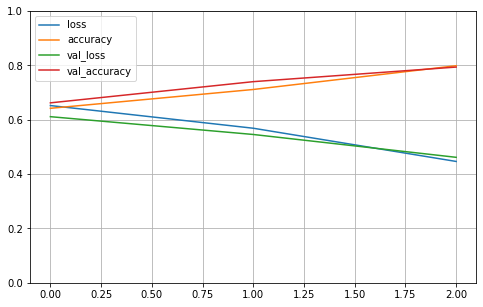

Train set ones/size 1784 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 199 / 577
Range of scores: 0.00080635445 to 0.9565196
Score threshold 0.5
Prediction set ones/size 104 / 577


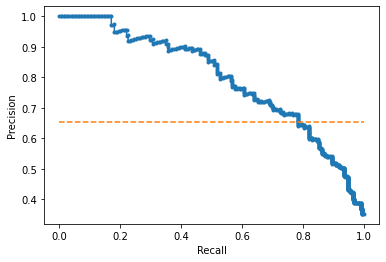

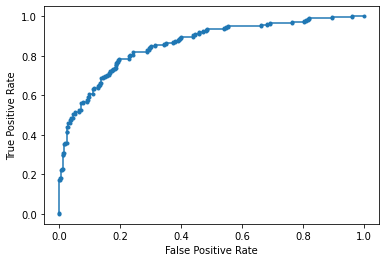

Accuracy: 79.38% Precision: 88.46% Recall: 46.23%
F1: 60.73% AUPRC: 79.49% AUROC: 85.82%
2023-02-06 19:37:25.858235
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:37:28.720891
PREDICT
2023-02-06 19:37:35.390608


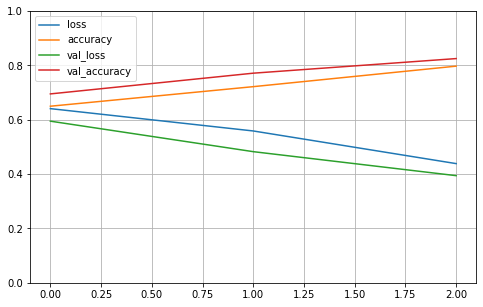

Train set ones/size 1801 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 182 / 577
Range of scores: 0.0027352648 to 0.98872876
Score threshold 0.5
Prediction set ones/size 143 / 577


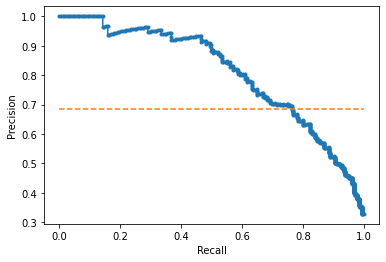

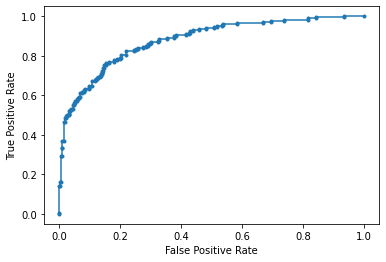

Accuracy: 82.50% Precision: 78.32% Recall: 61.54%
F1: 68.92% AUPRC: 80.90% AUROC: 87.94%
2023-02-06 19:37:36.081853
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:37:38.943584
PREDICT
2023-02-06 19:37:50.123744


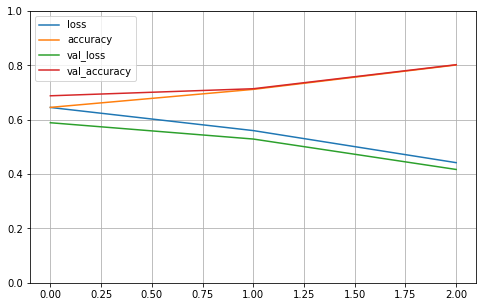

Train set ones/size 1796 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 187 / 577
Range of scores: 0.0008775297 to 0.9847503
Score threshold 0.5
Prediction set ones/size 181 / 577


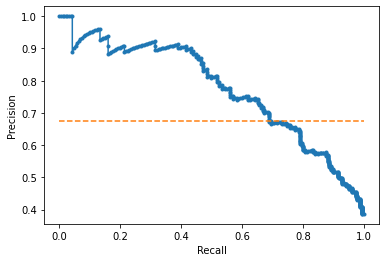

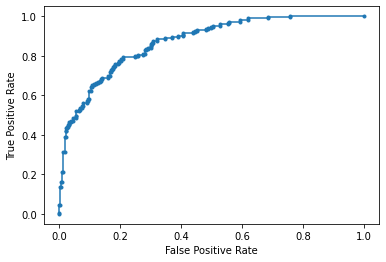

Accuracy: 80.24% Precision: 70.17% Recall: 67.91%
F1: 69.02% AUPRC: 77.57% AUROC: 87.08%
2023-02-06 19:37:50.846855
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:37:53.751651
PREDICT
2023-02-06 19:38:04.974196


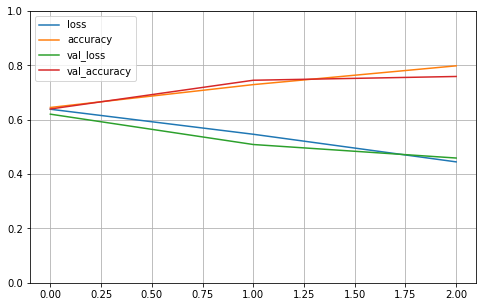

Train set ones/size 1776 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 207 / 577
Range of scores: 0.0063582393 to 0.9875838
Score threshold 0.5
Prediction set ones/size 232 / 577


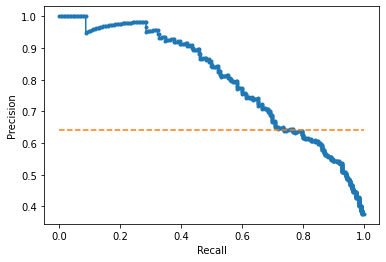

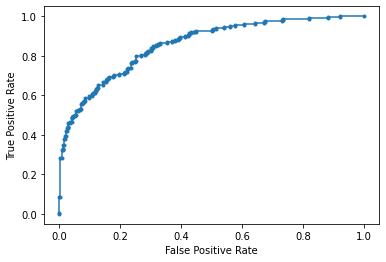

Accuracy: 75.91% Precision: 64.66% Recall: 72.46%
F1: 68.34% AUPRC: 80.09% AUROC: 85.74%
2023-02-06 19:38:05.694075
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:38:08.563242
PREDICT
2023-02-06 19:38:15.163036


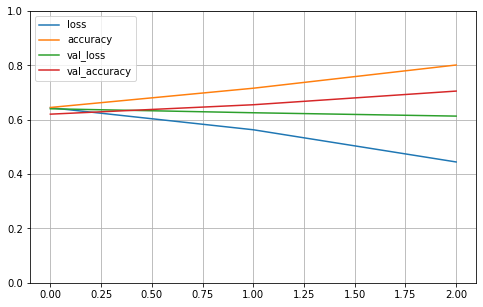

Train set ones/size 1759 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 224 / 577
Range of scores: 0.00025718904 to 0.9662802
Score threshold 0.5
Prediction set ones/size 68 / 577


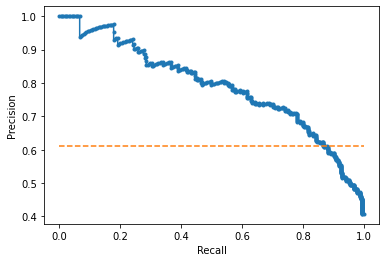

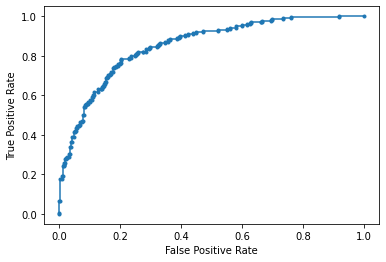

Accuracy: 70.54% Precision: 89.71% Recall: 27.23%
F1: 41.78% AUPRC: 79.06% AUROC: 85.35%
2023-02-06 19:38:15.893220
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:38:18.774888
PREDICT
2023-02-06 19:38:25.098767


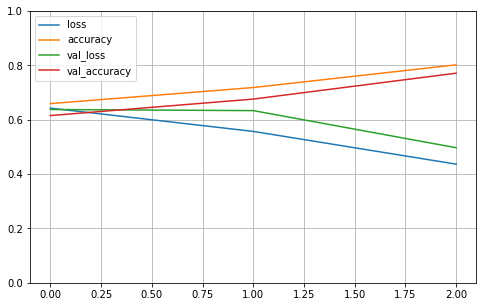

Train set ones/size 1756 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 227 / 577
Range of scores: 0.0018565862 to 0.958925
Score threshold 0.5
Prediction set ones/size 123 / 577


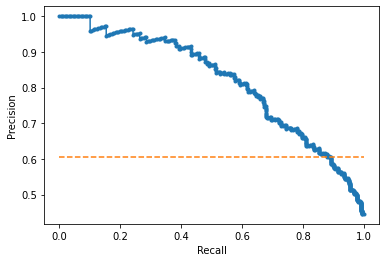

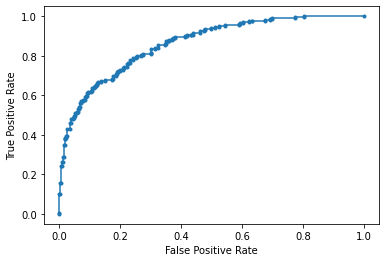

Accuracy: 77.12% Precision: 88.62% Recall: 48.02%
F1: 62.29% AUPRC: 81.83% AUROC: 86.22%
2023-02-06 19:38:26.069742
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:38:29.011942
PREDICT
2023-02-06 19:38:40.196242


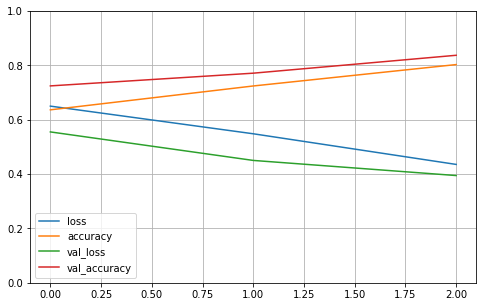

Train set ones/size 1812 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 171 / 577
Range of scores: 0.000791222 to 0.9760827
Score threshold 0.5
Prediction set ones/size 177 / 577


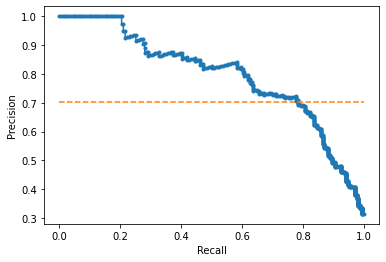

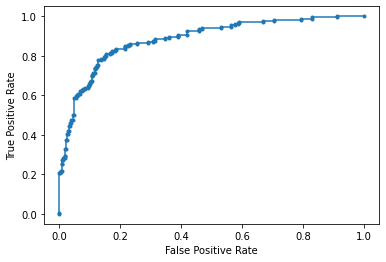

Accuracy: 83.71% Precision: 71.75% Recall: 74.27%
F1: 72.99% AUPRC: 79.54% AUROC: 88.49%
2023-02-06 19:38:40.893990

Completed cross validation 10 folds 3 epochs
 accuracy mean 78.60% +/- 3.81
 precision mean 78.60% +/- 10.70
 recall mean 57.29% +/- 16.03
 F1 mean 63.77% +/- 8.88
 AUPRC mean 79.68% +/- 1.67
 AUROC mean 86.78% +/- 1.16
Finished cell Line 10 SK.N.DZ

2023-02-06 19:38:42.239035
Start cell Line 11 SK.N.SH
Number of RCI values loaded 1647
Num RCI: 1647
Load sequence...
Cross validation...
2023-02-06 19:38:58.518467
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:39:01.261514
PREDICT
2023-02-06 19:39:12.905481


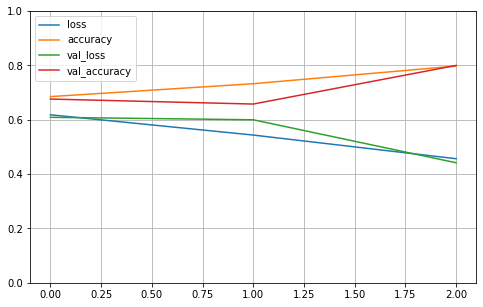

Train set ones/size 2846 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 339 / 1034
Range of scores: 0.0027861095 to 0.9880243
Score threshold 0.5
Prediction set ones/size 230 / 1034


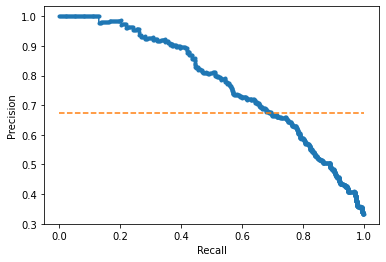

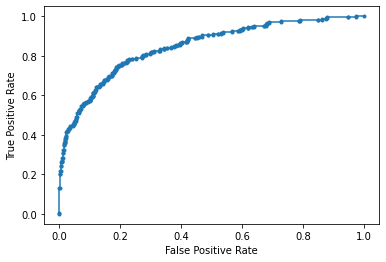

Accuracy: 79.98% Precision: 78.70% Recall: 53.39%
F1: 63.62% AUPRC: 77.50% AUROC: 84.62%
2023-02-06 19:39:13.649279
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:39:19.285339
PREDICT
2023-02-06 19:39:30.727192


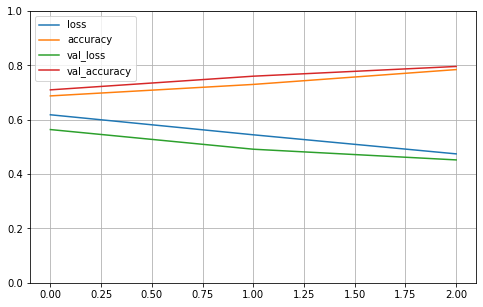

Train set ones/size 2870 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 315 / 1034
Range of scores: 0.003069431 to 0.9809902
Score threshold 0.5
Prediction set ones/size 212 / 1034


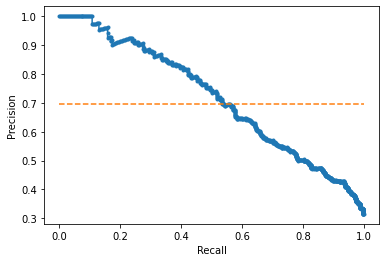

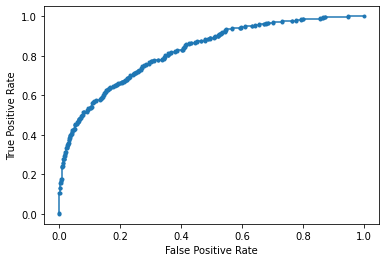

Accuracy: 79.59% Precision: 74.53% Recall: 50.16%
F1: 59.96% AUPRC: 71.84% AUROC: 82.42%
2023-02-06 19:39:31.831872
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:39:35.943102
PREDICT
2023-02-06 19:39:47.386478


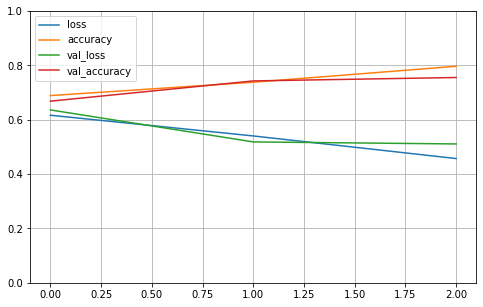

Train set ones/size 2839 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 346 / 1034
Range of scores: 0.0013925638 to 0.99661887
Score threshold 0.5
Prediction set ones/size 183 / 1034


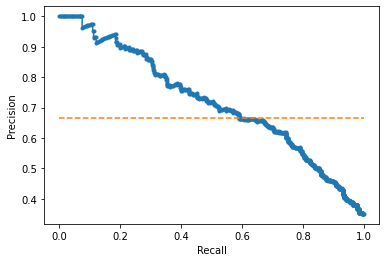

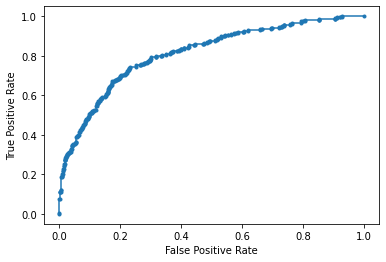

Accuracy: 75.53% Precision: 75.41% Recall: 39.88%
F1: 52.17% AUPRC: 71.79% AUROC: 81.30%
2023-02-06 19:39:48.122166
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:39:52.216953
PREDICT
2023-02-06 19:40:03.641301


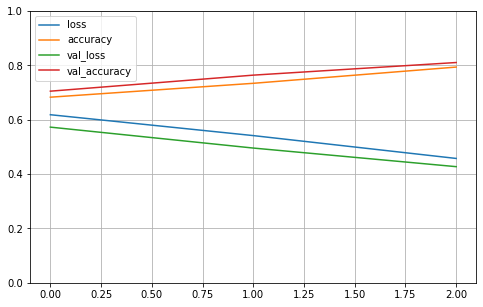

Train set ones/size 2877 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 308 / 1034
Range of scores: 0.0035443234 to 0.99353164
Score threshold 0.5
Prediction set ones/size 192 / 1034


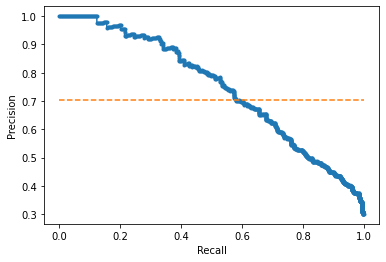

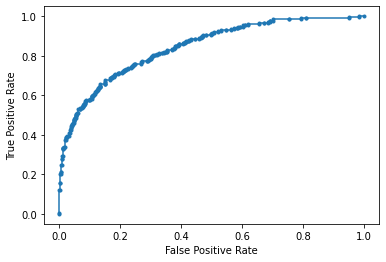

Accuracy: 81.04% Precision: 79.17% Recall: 49.35%
F1: 60.80% AUPRC: 74.76% AUROC: 84.41%
2023-02-06 19:40:04.402458
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:40:08.561163
PREDICT
2023-02-06 19:40:20.399825


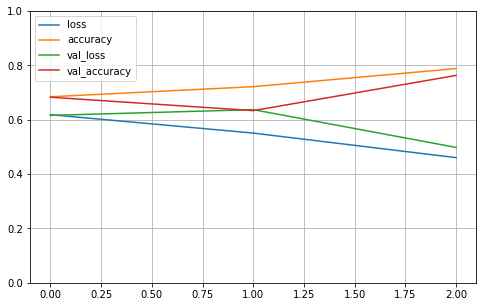

Train set ones/size 2858 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 327 / 1034
Range of scores: 0.0010200678 to 0.97843426
Score threshold 0.5
Prediction set ones/size 118 / 1034


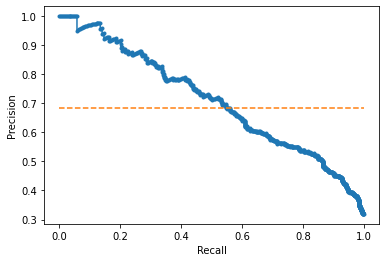

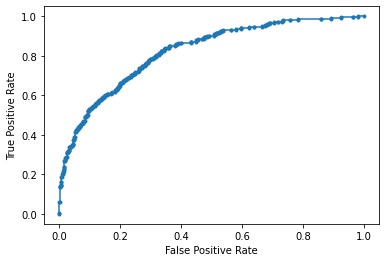

Accuracy: 76.31% Precision: 84.75% Recall: 30.58%
F1: 44.94% AUPRC: 71.05% AUROC: 82.19%
2023-02-06 19:40:21.160534
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:40:26.383730
PREDICT
2023-02-06 19:40:37.822066


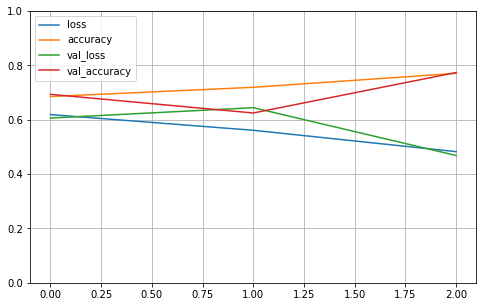

Train set ones/size 2867 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 318 / 1034
Range of scores: 0.0035617016 to 0.982541
Score threshold 0.5
Prediction set ones/size 300 / 1034


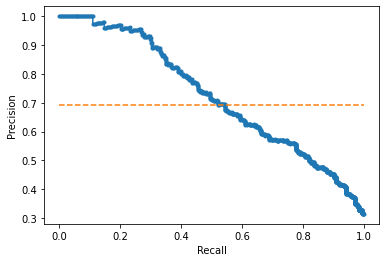

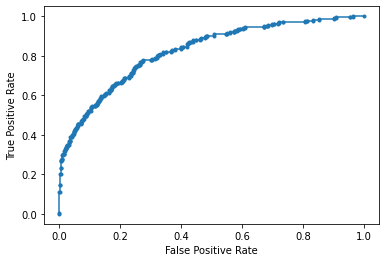

Accuracy: 77.37% Precision: 64.00% Recall: 60.38%
F1: 62.14% AUPRC: 72.45% AUROC: 82.31%
2023-02-06 19:40:38.607587
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:40:42.747617
PREDICT
2023-02-06 19:40:53.102038


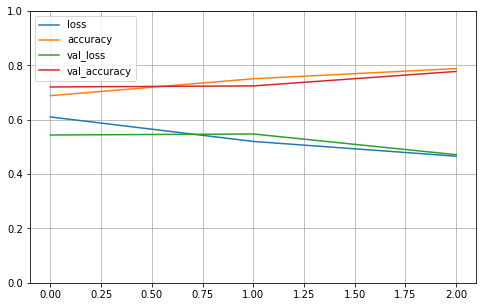

Train set ones/size 2877 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 308 / 1034
Range of scores: 0.0015658911 to 0.9683814
Score threshold 0.5
Prediction set ones/size 142 / 1034


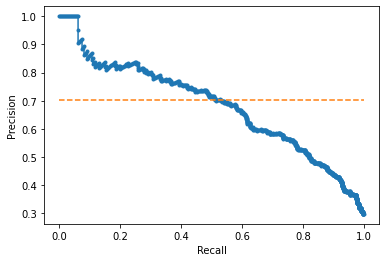

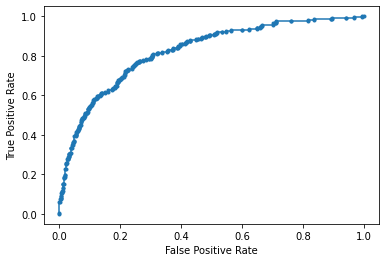

Accuracy: 77.76% Precision: 77.46% Recall: 35.71%
F1: 48.89% AUPRC: 68.31% AUROC: 82.36%
2023-02-06 19:40:53.835931
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:40:57.995148
PREDICT
2023-02-06 19:41:08.519894


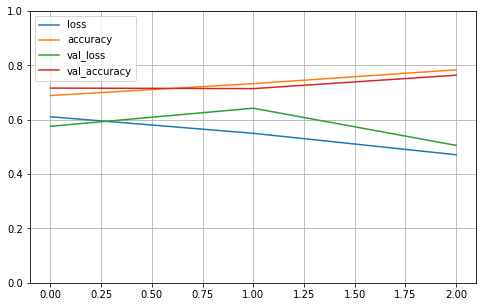

Train set ones/size 2880 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 305 / 1033
Range of scores: 0.000543551 to 0.9858532
Score threshold 0.5
Prediction set ones/size 293 / 1033


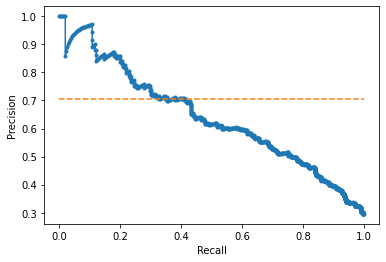

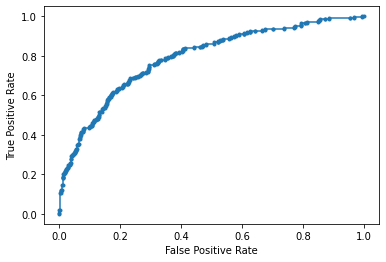

Accuracy: 76.38% Precision: 60.41% Recall: 58.03%
F1: 59.20% AUPRC: 64.17% AUROC: 78.98%
2023-02-06 19:41:09.280513
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:41:13.415906
PREDICT
2023-02-06 19:41:23.902127


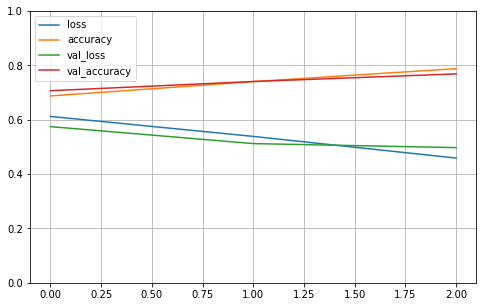

Train set ones/size 2852 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 333 / 1033
Range of scores: 0.002558313 to 0.9701025
Score threshold 0.5
Prediction set ones/size 142 / 1033


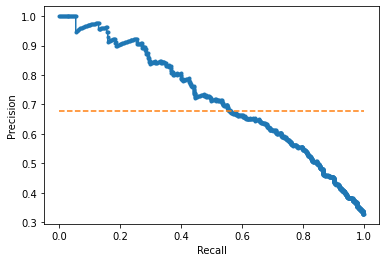

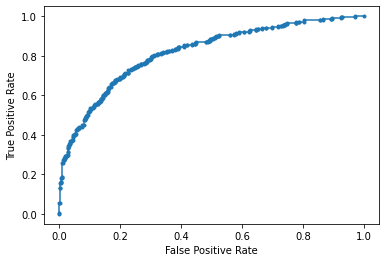

Accuracy: 76.86% Precision: 83.10% Recall: 35.44%
F1: 49.68% AUPRC: 72.01% AUROC: 81.80%
2023-02-06 19:41:24.655394
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:41:29.577076
PREDICT
2023-02-06 19:41:40.214594


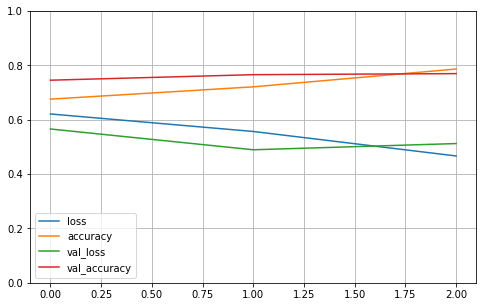

Train set ones/size 2899 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 286 / 1033
Range of scores: 0.0010174114 to 0.97460335
Score threshold 0.5
Prediction set ones/size 66 / 1033


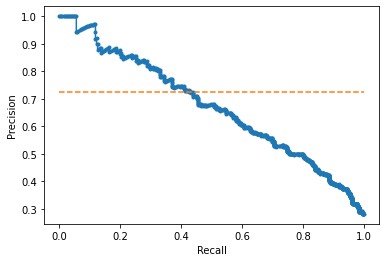

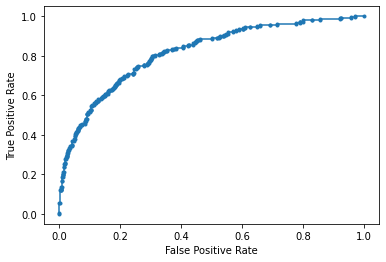

Accuracy: 76.96% Precision: 86.36% Recall: 19.93%
F1: 32.39% AUPRC: 67.31% AUROC: 81.80%
2023-02-06 19:41:40.963906

Completed cross validation 10 folds 3 epochs
 accuracy mean 77.78% +/- 1.82
 precision mean 76.39% +/- 8.44
 recall mean 43.29% +/- 13.05
 F1 mean 53.38% +/- 9.78
 AUPRC mean 71.12% +/- 3.77
 AUROC mean 82.22% +/- 1.58
Finished cell Line 11 SK.N.SH

2023-02-06 19:41:42.472428
Start cell Line 12 GM12878
Number of RCI values loaded 1698
Num RCI: 1698
Load sequence...
Cross validation...
2023-02-06 19:41:59.033248
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:42:01.679474
PREDICT
2023-02-06 19:42:13.116696


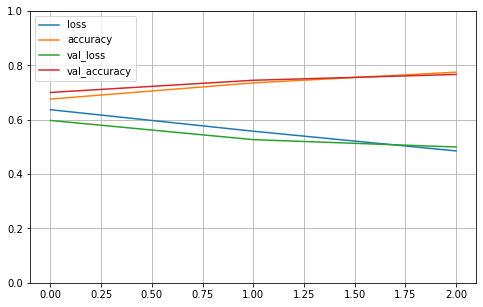

Train set ones/size 2814 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 326 / 981
Range of scores: 0.00284906 to 0.98719525
Score threshold 0.5
Prediction set ones/size 131 / 981


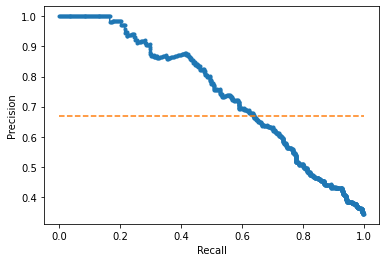

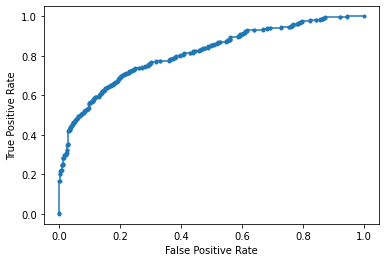

Accuracy: 76.66% Precision: 87.02% Recall: 34.97%
F1: 49.89% AUPRC: 74.48% AUROC: 81.31%
2023-02-06 19:42:13.905208
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:42:17.906461
PREDICT
2023-02-06 19:42:27.992661


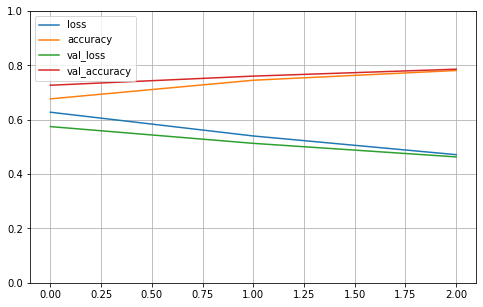

Train set ones/size 2824 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 316 / 981
Range of scores: 0.006902749 to 0.98821914
Score threshold 0.5
Prediction set ones/size 264 / 981


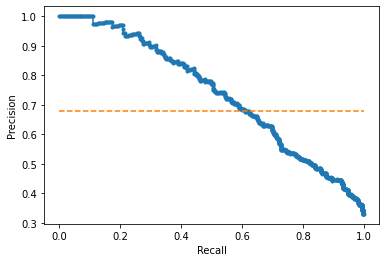

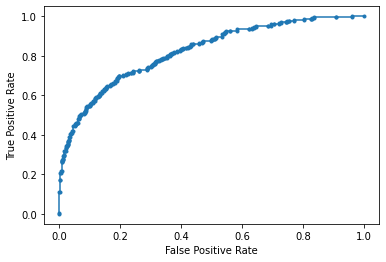

Accuracy: 78.59% Precision: 70.08% Recall: 58.54%
F1: 63.79% AUPRC: 73.91% AUROC: 82.34%
2023-02-06 19:42:28.741309
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:42:32.732937
PREDICT
2023-02-06 19:42:44.136552


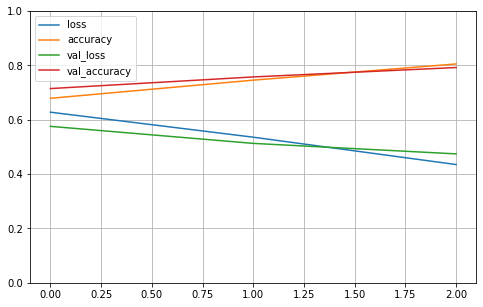

Train set ones/size 2811 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 329 / 981
Range of scores: 0.0012398803 to 0.99436283
Score threshold 0.5
Prediction set ones/size 191 / 981


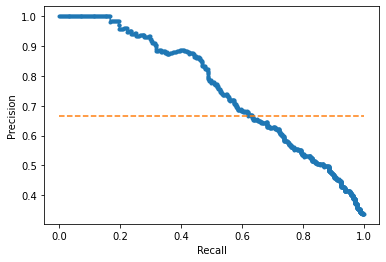

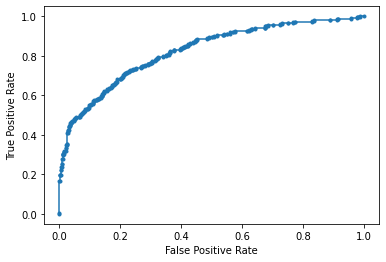

Accuracy: 79.20% Precision: 82.72% Recall: 48.02%
F1: 60.77% AUPRC: 75.57% AUROC: 82.40%
2023-02-06 19:42:44.887863
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:42:49.471831
PREDICT
2023-02-06 19:43:01.246371


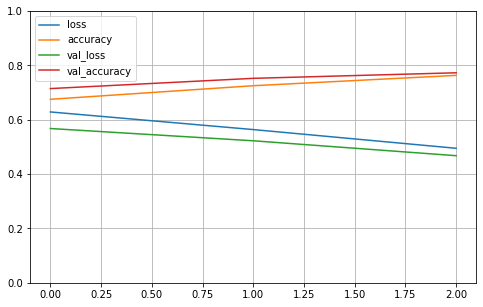

Train set ones/size 2834 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 306 / 981
Range of scores: 0.015748689 to 0.989234
Score threshold 0.5
Prediction set ones/size 173 / 981


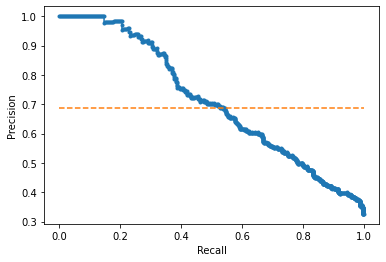

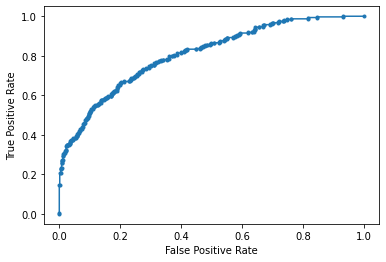

Accuracy: 77.27% Precision: 73.99% Recall: 41.83%
F1: 53.44% AUPRC: 71.13% AUROC: 80.82%
2023-02-06 19:43:02.319710
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:43:06.812145
PREDICT
2023-02-06 19:43:18.220428


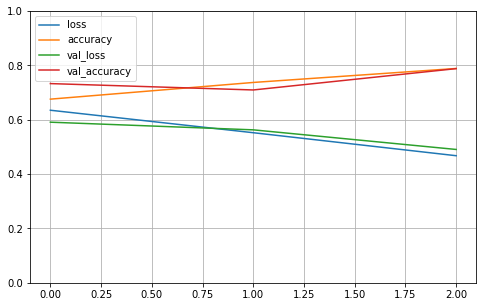

Train set ones/size 2828 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 312 / 981
Range of scores: 0.0032131302 to 0.98961484
Score threshold 0.5
Prediction set ones/size 132 / 981


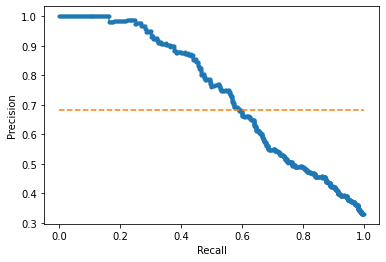

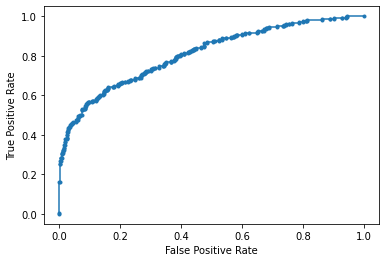

Accuracy: 78.80% Precision: 89.39% Recall: 37.82%
F1: 53.15% AUPRC: 74.02% AUROC: 81.00%
2023-02-06 19:43:18.986572
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:43:22.960318
PREDICT
2023-02-06 19:43:34.370332


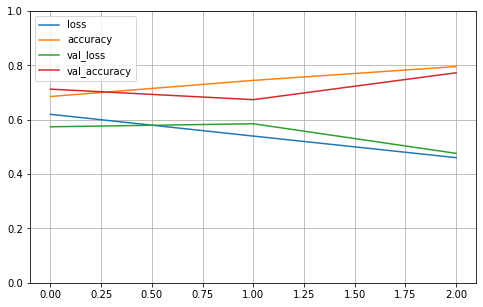

Train set ones/size 2812 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 328 / 981
Range of scores: 0.0058519244 to 0.99600935
Score threshold 0.5
Prediction set ones/size 241 / 981


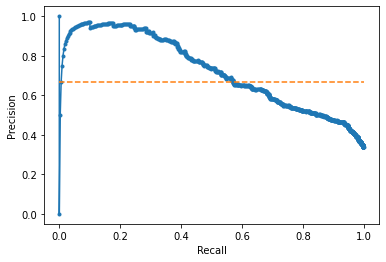

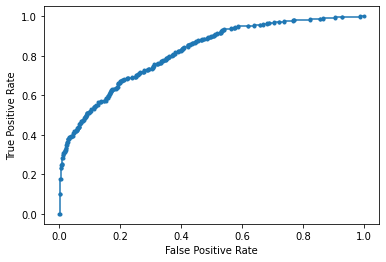

Accuracy: 77.27% Precision: 71.78% Recall: 52.74%
F1: 60.81% AUPRC: 72.39% AUROC: 81.83%
2023-02-06 19:43:35.151581
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:43:39.139696
PREDICT
2023-02-06 19:43:50.575276


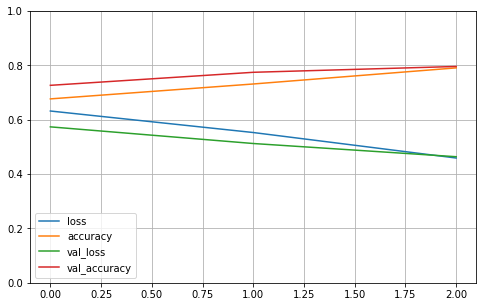

Train set ones/size 2833 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 307 / 980
Range of scores: 0.007770254 to 0.992593
Score threshold 0.5
Prediction set ones/size 251 / 980


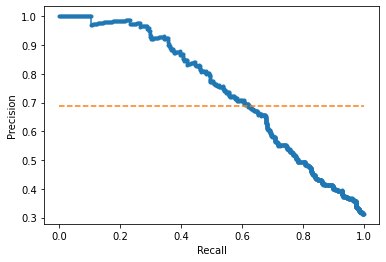

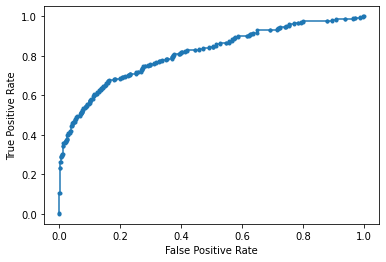

Accuracy: 79.59% Precision: 71.31% Recall: 58.31%
F1: 64.16% AUPRC: 74.23% AUROC: 81.28%
2023-02-06 19:43:51.331724
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:43:55.855333
PREDICT
2023-02-06 19:44:07.631750


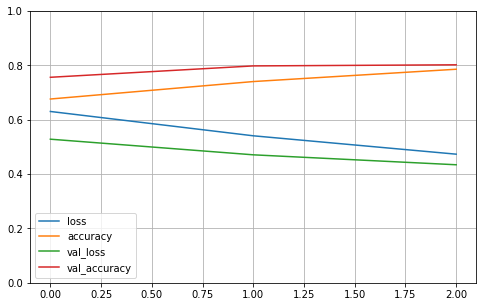

Train set ones/size 2869 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 271 / 980
Range of scores: 0.006805497 to 0.99211085
Score threshold 0.5
Prediction set ones/size 229 / 980


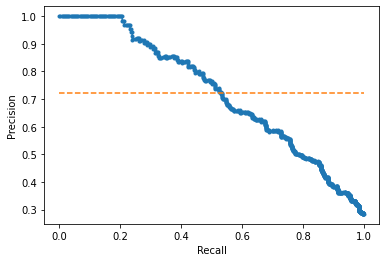

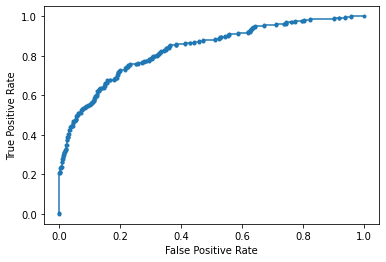

Accuracy: 80.20% Precision: 66.81% Recall: 56.46%
F1: 61.20% AUPRC: 72.53% AUROC: 83.31%
2023-02-06 19:44:08.744992
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:44:13.209765
PREDICT
2023-02-06 19:44:24.657072


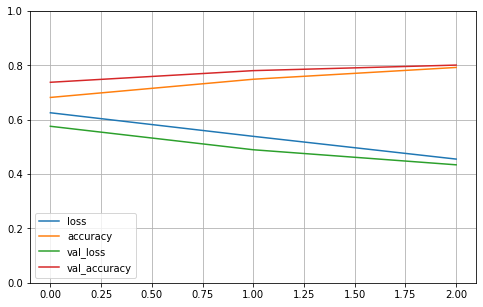

Train set ones/size 2815 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 325 / 980
Range of scores: 0.004034512 to 0.9877505
Score threshold 0.5
Prediction set ones/size 252 / 980


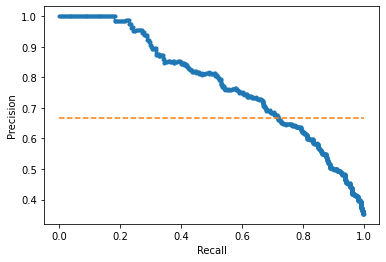

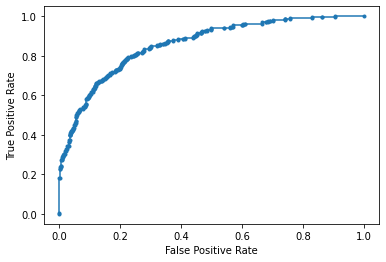

Accuracy: 80.10% Precision: 75.79% Recall: 58.77%
F1: 66.20% AUPRC: 78.04% AUROC: 85.87%
2023-02-06 19:44:25.562620
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:44:29.609367
PREDICT
2023-02-06 19:44:39.638278


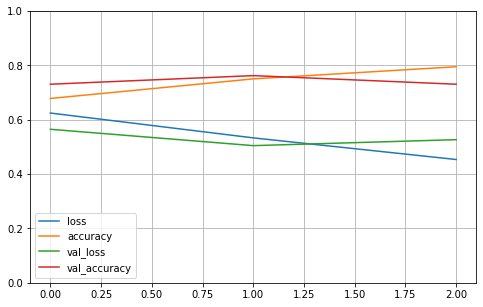

Train set ones/size 2820 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 320 / 980
Range of scores: 0.02124138 to 0.9975688
Score threshold 0.5
Prediction set ones/size 414 / 980


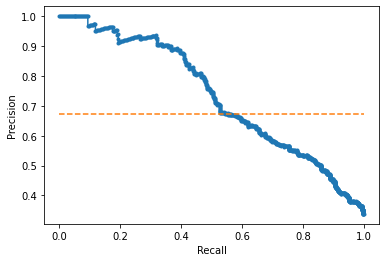

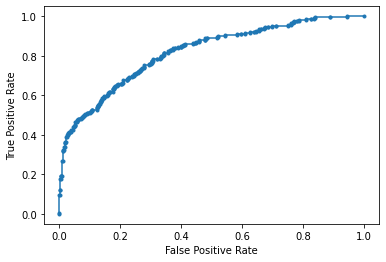

Accuracy: 73.06% Precision: 56.76% Recall: 73.44%
F1: 64.03% AUPRC: 73.53% AUROC: 81.79%
2023-02-06 19:44:40.437089

Completed cross validation 10 folds 3 epochs
 accuracy mean 78.07% +/- 2.15
 precision mean 74.57% +/- 9.77
 recall mean 52.09% +/- 11.64
 F1 mean 59.75% +/- 5.58
 AUPRC mean 73.98% +/- 1.89
 AUROC mean 82.20% +/- 1.49
Finished cell Line 12 GM12878

2023-02-06 19:44:41.893485
Start cell Line 13 K562
Number of RCI values loaded 958
Num RCI: 958
Load sequence...
Cross validation...
2023-02-06 19:44:52.480490
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:44:54.309911
PREDICT
2023-02-06 19:45:05.601779


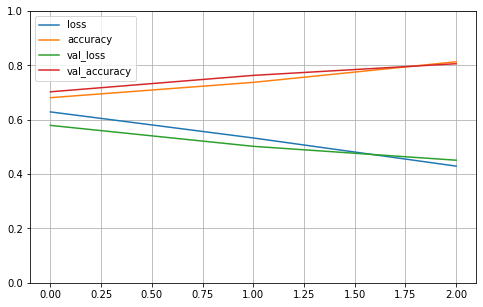

Train set ones/size 1756 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 187 / 629
Range of scores: 4.9875798e-05 to 0.9892917
Score threshold 0.5
Prediction set ones/size 171 / 629


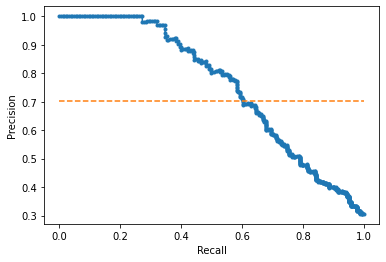

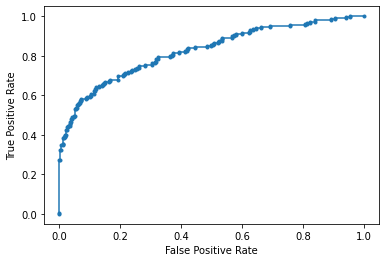

Accuracy: 80.60% Precision: 69.01% Recall: 63.10%
F1: 65.92% AUPRC: 75.61% AUROC: 82.54%
2023-02-06 19:45:06.311424
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:45:09.303025
PREDICT
2023-02-06 19:45:16.194434


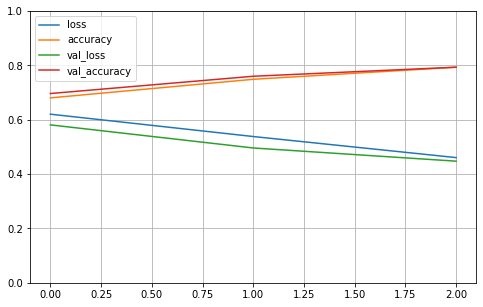

Train set ones/size 1753 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 190 / 629
Range of scores: 0.0067112017 to 0.96384144
Score threshold 0.5
Prediction set ones/size 100 / 629


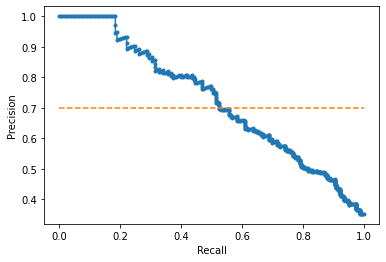

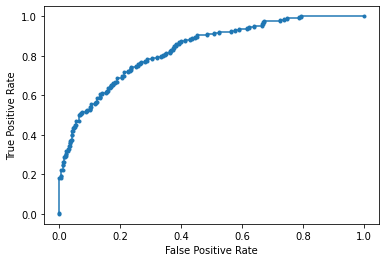

Accuracy: 79.33% Precision: 80.00% Recall: 42.11%
F1: 55.17% AUPRC: 72.49% AUROC: 83.39%
2023-02-06 19:45:17.017934
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:45:20.051805
PREDICT
2023-02-06 19:45:26.470712


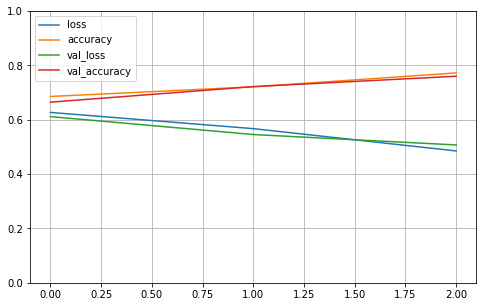

Train set ones/size 1731 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 212 / 629
Range of scores: 0.011540316 to 0.98449314
Score threshold 0.5
Prediction set ones/size 237 / 629


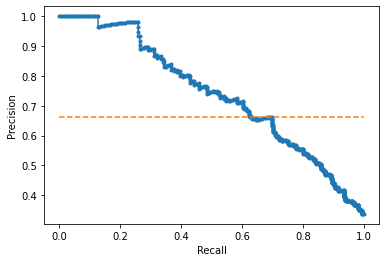

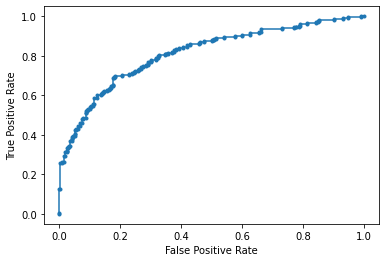

Accuracy: 75.99% Precision: 62.87% Recall: 70.28%
F1: 66.37% AUPRC: 74.05% AUROC: 81.31%
2023-02-06 19:45:27.419542
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:45:31.032639
PREDICT
2023-02-06 19:45:42.264201


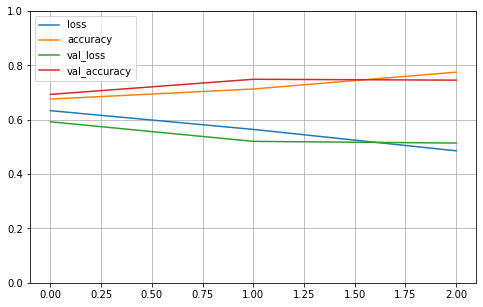

Train set ones/size 1750 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 193 / 629
Range of scores: 0.011405288 to 0.98643386
Score threshold 0.5
Prediction set ones/size 233 / 629


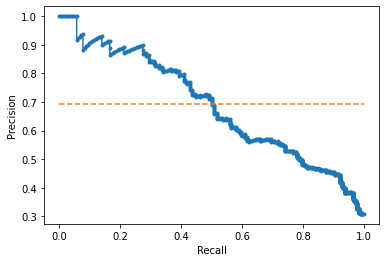

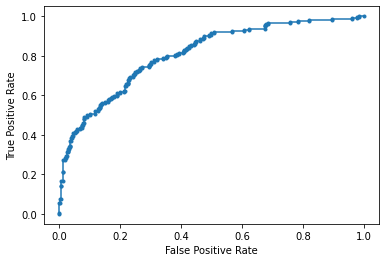

Accuracy: 74.56% Precision: 57.08% Recall: 68.91%
F1: 62.44% AUPRC: 68.83% AUROC: 80.83%
2023-02-06 19:45:43.045437
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:45:46.044980
PREDICT
2023-02-06 19:45:52.678748


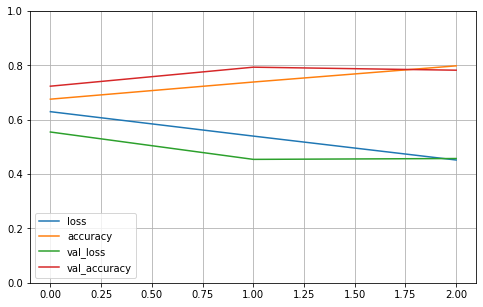

Train set ones/size 1762 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 181 / 629
Range of scores: 0.00647686 to 0.9838562
Score threshold 0.5
Prediction set ones/size 212 / 629


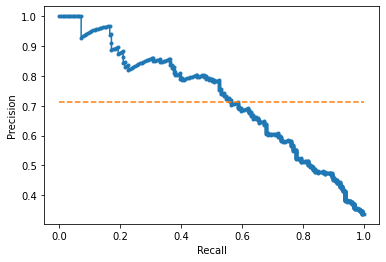

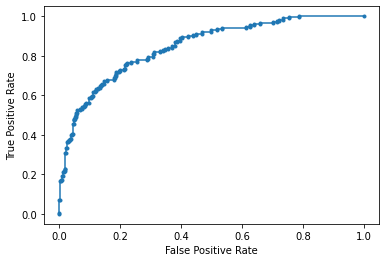

Accuracy: 78.22% Precision: 60.38% Recall: 70.72%
F1: 65.14% AUPRC: 72.34% AUROC: 84.76%
2023-02-06 19:45:53.696220
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:45:56.871078
PREDICT
2023-02-06 19:46:08.090698


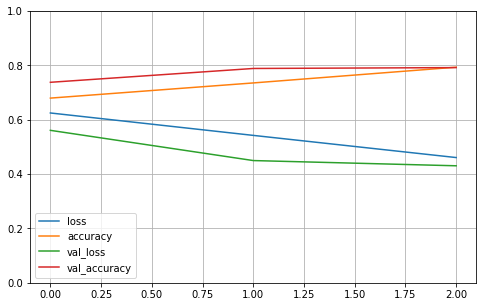

Train set ones/size 1757 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 186 / 629
Range of scores: 0.006000833 to 0.9887007
Score threshold 0.5
Prediction set ones/size 209 / 629


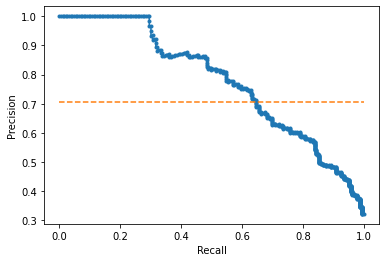

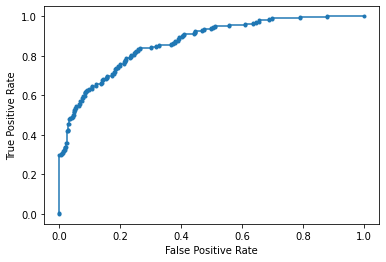

Accuracy: 79.17% Precision: 63.16% Recall: 70.97%
F1: 66.84% AUPRC: 77.87% AUROC: 86.74%
2023-02-06 19:46:08.822348
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:46:11.832308
PREDICT
2023-02-06 19:46:18.545055


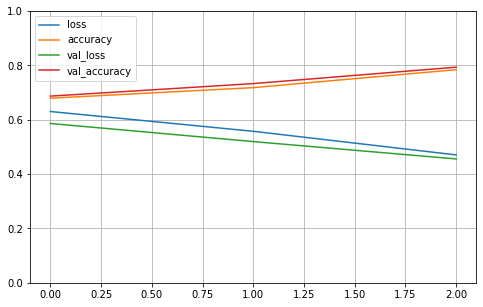

Train set ones/size 1746 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 197 / 629
Range of scores: 0.01371897 to 0.97917104
Score threshold 0.5
Prediction set ones/size 191 / 629


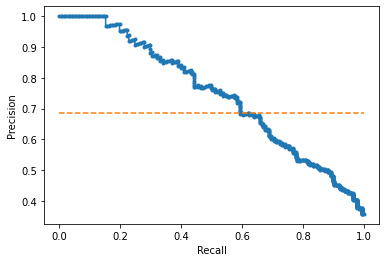

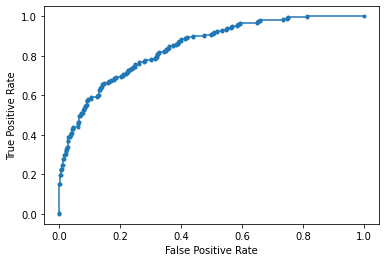

Accuracy: 79.33% Precision: 67.54% Recall: 65.48%
F1: 66.49% AUPRC: 74.64% AUROC: 84.29%
2023-02-06 19:46:19.441841
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:46:22.558043
PREDICT
2023-02-06 19:46:29.120326


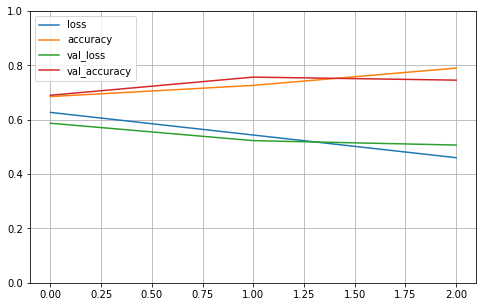

Train set ones/size 1742 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 201 / 629
Range of scores: 0.0135710845 to 0.98690796
Score threshold 0.5
Prediction set ones/size 259 / 629


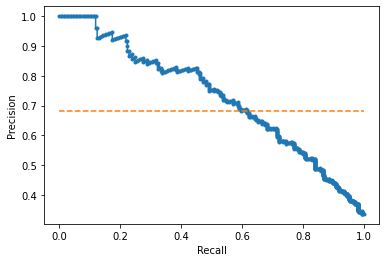

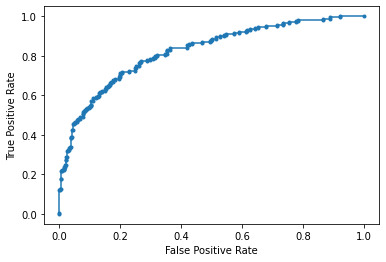

Accuracy: 74.56% Precision: 57.92% Recall: 74.63%
F1: 65.22% AUPRC: 72.85% AUROC: 82.41%
2023-02-06 19:46:29.867779
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:46:34.122190
PREDICT
2023-02-06 19:46:45.362067


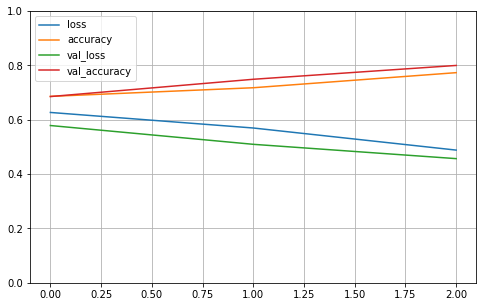

Train set ones/size 1744 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 199 / 629
Range of scores: 0.007568963 to 0.96903336
Score threshold 0.5
Prediction set ones/size 117 / 629


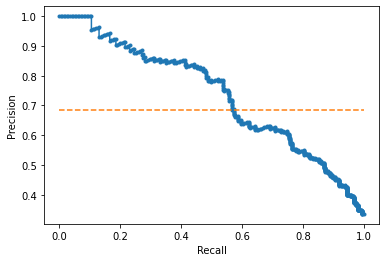

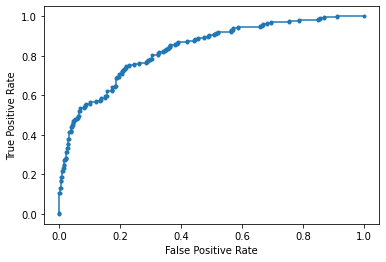

Accuracy: 79.97% Precision: 81.20% Recall: 47.74%
F1: 60.13% AUPRC: 73.54% AUROC: 83.36%
2023-02-06 19:46:46.329488
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:46:49.454475
PREDICT
2023-02-06 19:46:56.109423


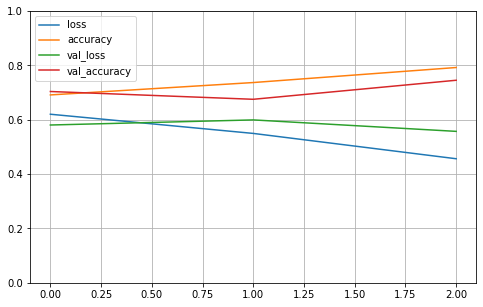

Train set ones/size 1746 / 5661
Compute valiation accuracy
Valid sizes (628, 4997) (628,)
Valid set ones/size 197 / 628
Range of scores: 0.0050491015 to 0.9307201
Score threshold 0.5
Prediction set ones/size 55 / 628


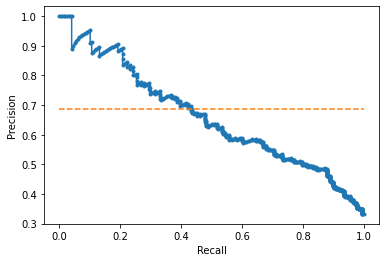

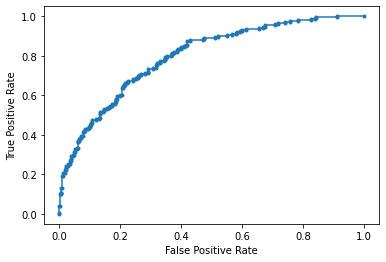

Accuracy: 74.52% Precision: 83.64% Recall: 23.35%
F1: 36.51% AUPRC: 66.15% AUROC: 79.74%
2023-02-06 19:46:56.882469

Completed cross validation 10 folds 3 epochs
 accuracy mean 77.63% +/- 2.45
 precision mean 68.28% +/- 9.95
 recall mean 59.73% +/- 16.62
 F1 mean 61.02% +/- 9.36
 AUPRC mean 72.84% +/- 3.32
 AUROC mean 82.94% +/- 2.05
Finished cell Line 13 K562

2023-02-06 19:46:58.403750
Start cell Line 14 IMR.90
Number of RCI values loaded 390
Num RCI: 390
Load sequence...
Cross validation...
2023-02-06 19:47:02.638793
splitting
Fold 1
RCI threshold derived from training set: 0
FIT
2023-02-06 19:47:03.473297
PREDICT
2023-02-06 19:47:06.881798


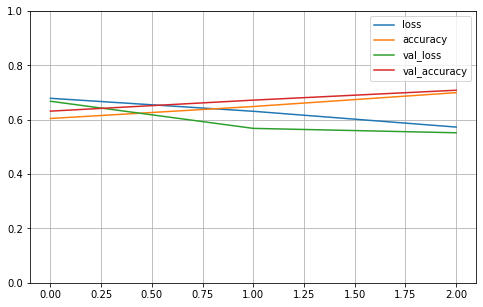

Train set ones/size 840 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 83 / 247
Range of scores: 0.02798727 to 0.81386656
Score threshold 0.5
Prediction set ones/size 35 / 247


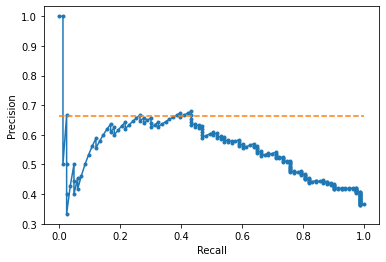

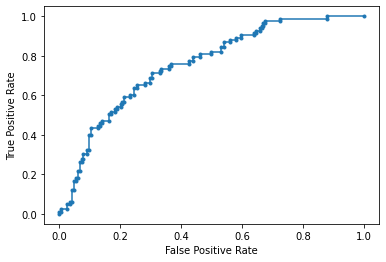

Accuracy: 70.85% Precision: 65.71% Recall: 27.71%
F1: 38.98% AUPRC: 55.51% AUROC: 75.42%
2023-02-06 19:47:07.569150
Fold 2
RCI threshold derived from training set: 0
FIT
2023-02-06 19:47:09.526391
PREDICT
2023-02-06 19:47:13.242648


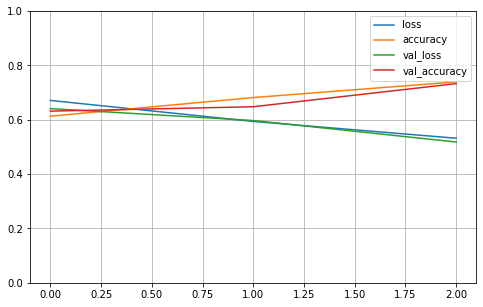

Train set ones/size 830 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 93 / 247
Range of scores: 0.008157375 to 0.9190949
Score threshold 0.5
Prediction set ones/size 71 / 247


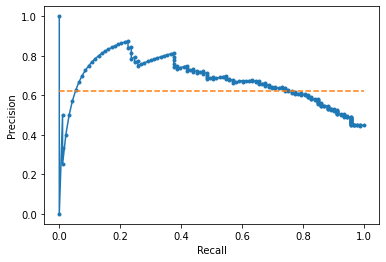

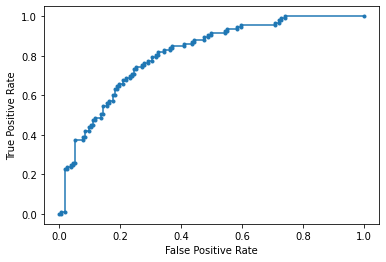

Accuracy: 73.28% Precision: 69.01% Recall: 52.69%
F1: 59.76% AUPRC: 66.95% AUROC: 81.06%
2023-02-06 19:47:13.928113
Fold 3
RCI threshold derived from training set: 0
FIT
2023-02-06 19:47:15.919907
PREDICT
2023-02-06 19:47:19.025588


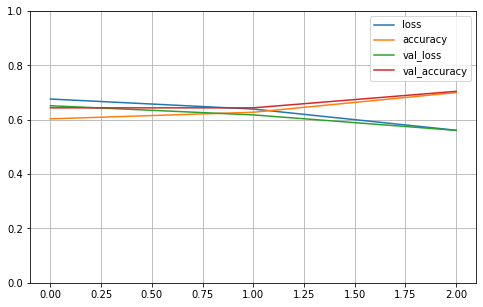

Train set ones/size 834 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 89 / 247
Range of scores: 0.025628837 to 0.9196346
Score threshold 0.5
Prediction set ones/size 98 / 247


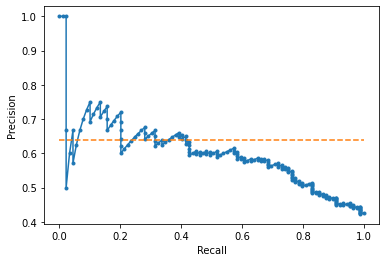

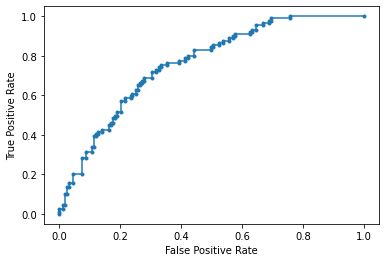

Accuracy: 70.45% Precision: 58.16% Recall: 64.04%
F1: 60.96% AUPRC: 59.95% AUROC: 76.06%
2023-02-06 19:47:19.706072
Fold 4
RCI threshold derived from training set: 0
FIT
2023-02-06 19:47:21.679573
PREDICT
2023-02-06 19:47:27.556817


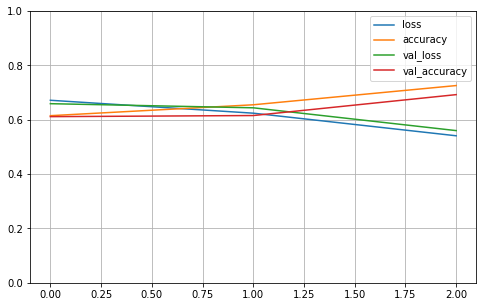

Train set ones/size 825 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 98 / 247
Range of scores: 0.014995156 to 0.7965401
Score threshold 0.5
Prediction set ones/size 52 / 247


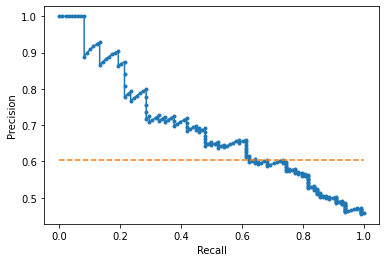

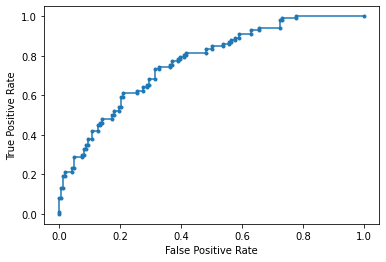

Accuracy: 69.23% Precision: 71.15% Recall: 37.76%
F1: 49.33% AUPRC: 68.99% AUROC: 76.73%
2023-02-06 19:47:28.220975
Fold 5
RCI threshold derived from training set: 0
FIT
2023-02-06 19:47:30.193622
PREDICT
2023-02-06 19:47:33.512304


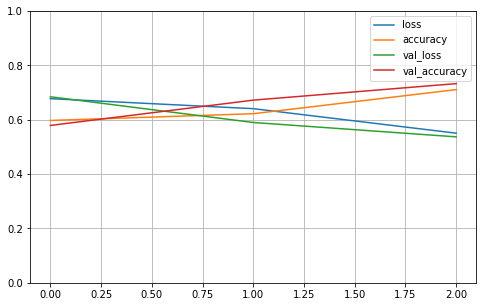

Train set ones/size 832 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 91 / 247
Range of scores: 0.0010426989 to 0.8756431
Score threshold 0.5
Prediction set ones/size 45 / 247


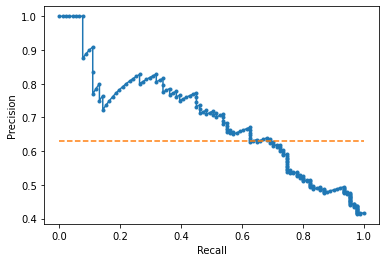

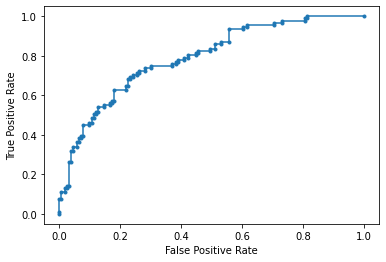

Accuracy: 73.28% Precision: 77.78% Recall: 38.46%
F1: 51.47% AUPRC: 69.33% AUROC: 79.16%
2023-02-06 19:47:34.209266
Fold 6
RCI threshold derived from training set: 0
FIT
2023-02-06 19:47:36.175130
PREDICT
2023-02-06 19:47:39.999751


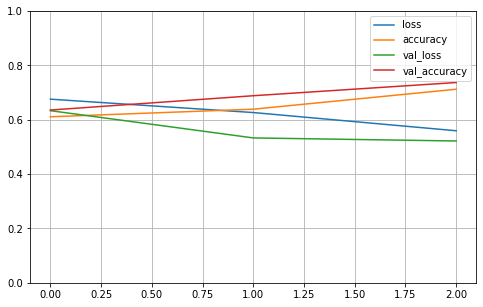

Train set ones/size 833 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 90 / 247
Range of scores: 0.02987885 to 0.96434313
Score threshold 0.5
Prediction set ones/size 121 / 247


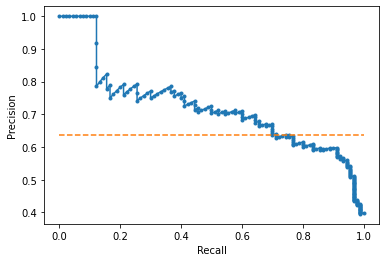

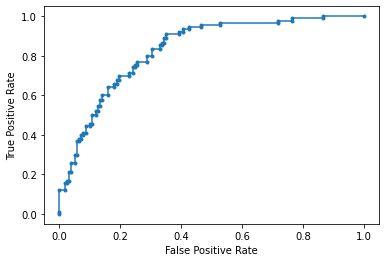

Accuracy: 73.68% Precision: 60.33% Recall: 81.11%
F1: 69.19% AUPRC: 72.16% AUROC: 83.38%
2023-02-06 19:47:40.707696
Fold 7
RCI threshold derived from training set: 0
FIT
2023-02-06 19:47:42.621622
PREDICT
2023-02-06 19:47:45.810095


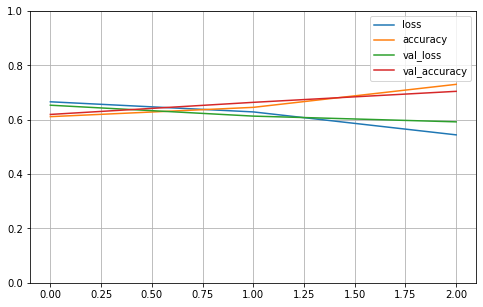

Train set ones/size 829 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 94 / 247
Range of scores: 0.025077311 to 0.9089627
Score threshold 0.5
Prediction set ones/size 51 / 247


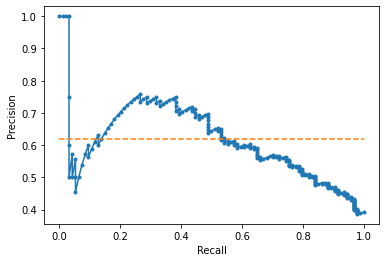

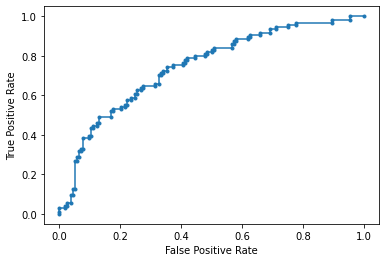

Accuracy: 70.45% Precision: 70.59% Recall: 38.30%
F1: 49.66% AUPRC: 61.49% AUROC: 74.54%
2023-02-06 19:47:46.441463
Fold 8
RCI threshold derived from training set: 0
FIT
2023-02-06 19:47:48.400796
PREDICT
2023-02-06 19:47:54.292013


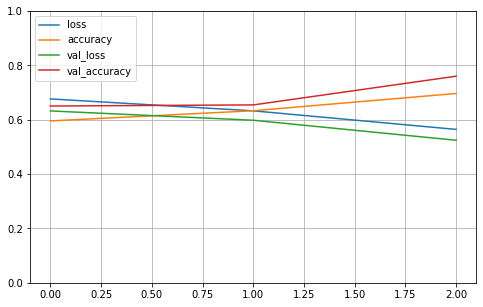

Train set ones/size 838 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 85 / 246
Range of scores: 0.009686578 to 0.9636501
Score threshold 0.5
Prediction set ones/size 96 / 246


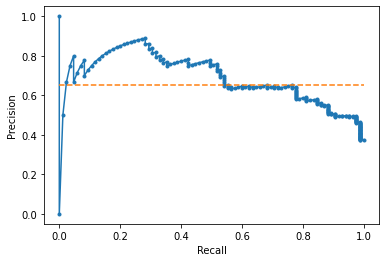

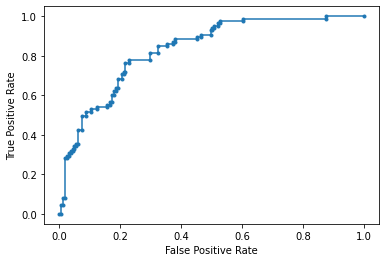

Accuracy: 76.02% Precision: 63.54% Recall: 71.76%
F1: 67.40% AUPRC: 68.57% AUROC: 83.35%
2023-02-06 19:47:54.985708
Fold 9
RCI threshold derived from training set: 0
FIT
2023-02-06 19:47:56.900693
PREDICT
2023-02-06 19:48:00.011626


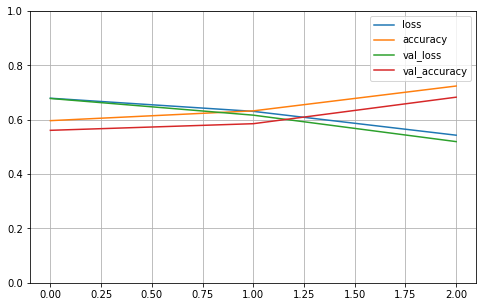

Train set ones/size 820 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 103 / 246
Range of scores: 0.0037759352 to 0.91513723
Score threshold 0.5
Prediction set ones/size 45 / 246


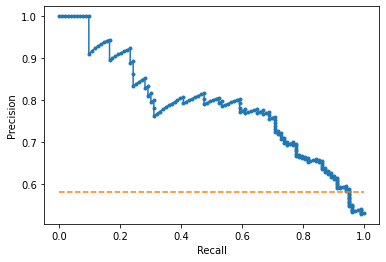

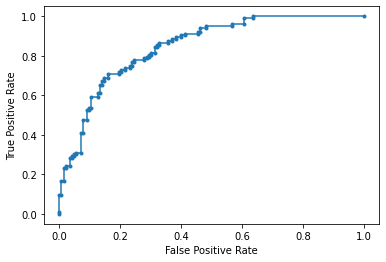

Accuracy: 68.29% Precision: 77.78% Recall: 33.98%
F1: 47.30% AUPRC: 78.57% AUROC: 84.77%
2023-02-06 19:48:00.702271
Fold 10
RCI threshold derived from training set: 0
FIT
2023-02-06 19:48:02.635998
PREDICT
2023-02-06 19:48:08.840137


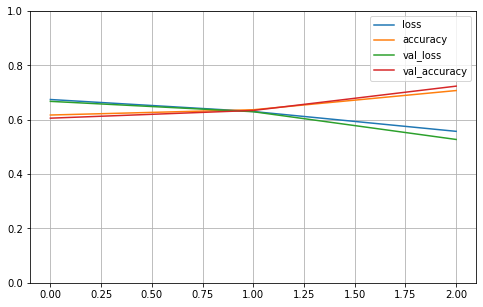

Train set ones/size 826 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 97 / 246
Range of scores: 0.011525515 to 0.907441
Score threshold 0.5
Prediction set ones/size 75 / 246


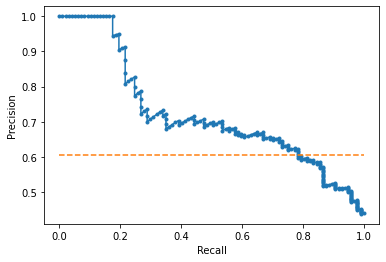

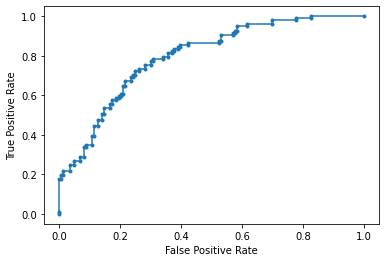

Accuracy: 72.36% Precision: 69.33% Recall: 53.61%
F1: 60.47% AUPRC: 72.13% AUROC: 79.76%
2023-02-06 19:48:09.548405

Completed cross validation 10 folds 3 epochs
 accuracy mean 71.79% +/- 2.34
 precision mean 68.34% +/- 6.58
 recall mean 49.94% +/- 17.74
 F1 mean 55.45% +/- 9.61
 AUPRC mean 67.36% +/- 6.75
 AUROC mean 79.42% +/- 3.67
Finished cell Line 14 IMR.90

2023-02-06 19:48:10.833257


In [10]:
for CELL_LINE in range(15):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy,ddof=1)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision,ddof=1)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall,ddof=1)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1,ddof=1)))
    print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc,ddof=1)))
    print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc,ddof=1)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())